In [1]:
import os
import sys
import pandas as pd

sys.path.append('/home/fboehning/fboehning')
#sys.path.append('C:/Users/felix/Documents/Studium Ingenieurinformatik/dAISY/fboehning')

import logging
logging.basicConfig(
    level=logging.INFO,
    #level=logging.DEBUG,
    format='%(asctime)s - %(filename)s - %(name)s - %(funcName)s - %(levelname)s - %(message)s')


os.environ["WANDB_DISABLED"] = "true"  # Completely disables wandb
sys.modules["wandb"] = None  # Prevent wandb from loading
# import wandb
# wandb.init()  # Will do nothing

In [2]:
TOOLKIT=[
    'beesup_llm.toolkit.llm_utils',
    'beesup_llm.toolkit.dict_utils',
    'beesup_llm.toolkit.setup_utils',
    'beesup_llm.toolkit.visualization',
    'beesup_llm.toolkit.display_settings',
    'beesup_llm.toolkit.retrieval_metrics',
]

DATASET=[
    'beesup_llm.dataset',
]

FINETUNING_PIPELINES=[
    'beesup_llm.finetuning_pipelines'
]

MODEL_PIPELINES=[
    'beesup_llm.model_pipelines'
]

INJECTION=[
    'beesup_llm.injection',
    'beesup_llm.injection.evaluator',
    'beesup_llm.injection.rag_pipeline',
    'beesup_llm.injection.taxomizer',
    'beesup_llm.injection.taxomizer_utils',
    'beesup_llm.injection.injection_experiment',
]

EXPERIMENT=[
    'beesup_llm.experiment',
]

import importlib
import beesup_llm;

import beesup_llm.toolkit.llm_utils; from beesup_llm.toolkit.llm_utils import *
import beesup_llm.toolkit.dict_utils; from beesup_llm.toolkit.dict_utils import *
import beesup_llm.toolkit.setup_utils; from beesup_llm.toolkit.setup_utils import *
import beesup_llm.toolkit.visualization; from beesup_llm.toolkit.visualization import *
import beesup_llm.toolkit.display_settings; from beesup_llm.toolkit.display_settings import *
import beesup_llm.toolkit.retrieval_metrics; from beesup_llm.toolkit.retrieval_metrics import *

import beesup_llm.dataset; from beesup_llm.dataset import *
#import beesup_llm.training; from beesup_llm.training import *
import beesup_llm.model_pipelines; from beesup_llm.model_pipelines import *
import beesup_llm.finetuning_pipelines; from beesup_llm.finetuning_pipelines import *

# import beesup_llm.extraction; from beesup_llm.extraction import *
# import beesup_llm.extraction.extraction_utils; from beesup_llm.extraction.extraction_utils import *
# import beesup_llm.extraction.extraction_pipeline; from beesup_llm.extraction.extraction_pipeline import *

# import beesup_llm.extraction.evaluation_utils; from beesup_llm.extraction.evaluation_utils import *
# import beesup_llm.extraction.evaluation_pipeline; from beesup_llm.extraction.evaluation_pipeline import *

# import beesup_llm.experiment; from beesup_llm.experiment import *
# import beesup_llm.experiment.extraction_experiment; from beesup_llm.experiment.extraction_experiment import *

import beesup_llm.experiment; from beesup_llm.experiment import *

import beesup_llm.injection; from beesup_llm.injection import *
import beesup_llm.injection.evaluator; from beesup_llm.injection.evaluator import *
import beesup_llm.injection.taxomizer; from beesup_llm.injection.taxomizer import *
import beesup_llm.injection.rag_pipeline; from beesup_llm.injection.rag_pipeline import *
import beesup_llm.injection.taxomizer_utils; from beesup_llm.injection.taxomizer_utils import * 
import beesup_llm.injection.injection_experiment; from beesup_llm.injection.injection_experiment import *


def reimport(pathlist=TOOLKIT+DATASET+MODEL_PIPELINES+FINETUNING_PIPELINES+INJECTION+EXPERIMENT):

    pathlist = ['beesup_llm'] + pathlist

    for module_path in pathlist:
        if module_path in sys.modules:
            # Reload if the module is already imported
            importlib.reload(sys.modules[module_path])
        else:

            importlib.import_module(module_path)
            # Import the module or submodule for the first time
            globals()[module_path.split('.')[0]] = importlib.import_module(module_path)

        module = sys.modules[module_path]
        globals().update({name: getattr(module, name) for name in dir(module) if not name.startswith('_')})

import logging
def set_info():
    logger = logging.getLogger('beesup_llm')
    logger.setLevel(logging.INFO)
    logging.getLogger().setLevel(logging.INFO)

def set_debug():
    logger = logging.getLogger('beesup_llm')
    logger.setLevel(logging.DEBUG)
    logging.getLogger().setLevel(logging.DEBUG)

set_info()
reimport()

2025-02-17 13:24:45,526 - config.py - datasets - <module> - INFO - PyTorch version 2.3.1 available.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# import wandb
# wandb.login()
# wandb.init(project="fboehning_beesup_injection", entity="mase-students", settings=wandb.Settings(init_timeout=120))

BrokenPipeError: [Errno 32] Broken pipe

In [3]:
#Load Model
llm_pipe=LlamaPipeline(1)
model=llm_pipe.get_model()
model2=copy.deepcopy(model)

2025-02-17 13:24:50,826 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 13:24:50,828 - __init__.py - beesup_llm - load_model - INFO - Loading model meta-llama/Meta-Llama-3.1-8B-Instruct
2025-02-17 13:24:51,964 - modeling.py - accelerate.utils.modeling - get_balanced_memory - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [46]:
reimport()

In [4]:
llm_pipe=LlamaPipeline(1,model=model2)
llm_pipe.prepare_inference()

2025-02-17 13:26:12,751 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised


Device set to use cuda:0


# Deepseek

In [215]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")
model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    device_map='auto',
    quantization_config=BitsAndBytesConfig(
        bnb_4bit_compute_dtype=torch.bfloat16,
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type='nf4',
    ),
    )


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.67G [00:00<?, ?B/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/7.39G [00:00<?, ?B/s]

2025-02-17 10:24:49,764 - modeling.py - accelerate.utils.modeling - get_balanced_memory - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [218]:
from transformers import pipeline
llm_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [219]:
llm_pipe("Hello")

[{'generated_text': "Hello, I'm trying to figure out how to solve this problem:\n\n**Problem Statement:**\nWe have"}]

# RAG Pipeline

In [26]:
reimport()

In [25]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Feb 14 13:01:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:D2:00.0 Off |                    0 |
|  0%   42C    P0            110W /  300W |    4623MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
from transformers import AutoModel, BitsAndBytesConfig

model=AutoModel.from_pretrained(
    'nvidia/NV-Embed-v2',
    device_map='auto',
    quantization_config=BitsAndBytesConfig(
        bnb_4bit_compute_dtype=torch.bfloat16,
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type='nf4',
    ),
    trust_remote_code=True
)

2025-02-14 13:33:08,088 - modeling.py - accelerate.utils.modeling - get_balanced_memory - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
from transformers.models.mistral import modeling_mistral

In [14]:
import torch
from transformers.models.mistral import modeling_mistral

# Define rotate_half if not already defined.
try:
    from transformers.models.mistral.modeling_mistral import rotate_half
except ImportError:
    def rotate_half(x):
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat([-x2, x1], dim=-1)

# Patch the rotary helper to ignore the provided cos and sin.
def patched_apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=None):
    # Determine the shape of the query tensor.
    # q: (batch, num_heads, seq_len, head_dim)
    batch, num_heads, seq_len, head_dim = q.shape
    device = q.device
    # Create identity rotary tensors that do nothing:
    # cos with ones and sin with zeros.
    cos_new = torch.ones(1, 1, seq_len, head_dim, device=device, dtype=q.dtype)
    sin_new = torch.zeros(1, 1, seq_len, head_dim, device=device, dtype=q.dtype)
    # Apply rotary transformation using the identity tensors.
    q_rot = (q * cos_new) + (rotate_half(q) * sin_new)
    k_rot = (k * cos_new) + (rotate_half(k) * sin_new)
    return q_rot, k_rot

# Replace the original rotary helper.
modeling_mistral.apply_rotary_pos_emb = patched_apply_rotary_pos_emb

# --- Patch the forward method of MistralAttention ---

# Store the original forward method only once.
if not hasattr(modeling_mistral.MistralAttention, "_orig_forward"):
    modeling_mistral.MistralAttention._orig_forward = modeling_mistral.MistralAttention.forward

def patched_forward(self, hidden_states, position_embeddings=None, *args, **kwargs):
    # If no position embeddings are provided, supply dummy values.
    # (They will be ignored by our patched apply_rotary_pos_emb.)
    if position_embeddings is None:
        dummy = torch.tensor(0, device=hidden_states.device)
        position_embeddings = (dummy, dummy)
    return modeling_mistral.MistralAttention._orig_forward(
        self, hidden_states, position_embeddings, *args, **kwargs
    )

# Apply the patched forward method.
modeling_mistral.MistralAttention.forward = patched_forward


In [6]:
import torch
from transformers.models.mistral import modeling_mistral

# Define rotate_half if it doesn't already exist.
try:
    from transformers.models.mistral.modeling_mistral import rotate_half
except ImportError:
    def rotate_half(x):
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat([-x2, x1], dim=-1)

# Patch the rotary helper (if needed).
def patched_apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=None):
    # Use the provided cos and sin as-is (bypassing any unsqueeze).
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

modeling_mistral.apply_rotary_pos_emb = patched_apply_rotary_pos_emb

# Only store the original forward once.
if not hasattr(modeling_mistral.MistralAttention, "_orig_forward"):
    modeling_mistral.MistralAttention._orig_forward = modeling_mistral.MistralAttention.forward

def patched_forward(self, hidden_states, position_embeddings=None, *args, **kwargs):
    if position_embeddings is None:
        # Determine the sequence length.
        seq_len = hidden_states.shape[1]
        # Get number of heads (default to 1 if not set).
        num_heads = getattr(self, "num_heads", 1)
        # Determine head dimension from q_proj.
        head_dim = self.q_proj.out_features // num_heads
        device = hidden_states.device
        # Create dummy rotary embeddings:
        cos = torch.ones(1, 1, seq_len, head_dim, device=device, dtype=hidden_states.dtype)
        sin = torch.zeros(1, 1, seq_len, head_dim, device=device, dtype=hidden_states.dtype)
        position_embeddings = (cos, sin)
    # Use the stored original forward method.
    return modeling_mistral.MistralAttention._orig_forward(self, hidden_states, position_embeddings, *args, **kwargs)

# Apply the patched forward.
modeling_mistral.MistralAttention.forward = patched_forward


In [47]:
from transformers.models.mistral import modeling_mistral

# Save the original forward function.
original_forward = modeling_mistral.MistralAttention.forward

def patched_forward(self, hidden_states, position_embeddings=None, *args, **kwargs):
    if position_embeddings is None:
        # Create identity rotary embeddings:
        # Here, we assume that rotary embeddings are applied per head.
        # For an identity effect, we want cos=1 and sin=0.
        # You may need to adjust the shapes according to your model’s requirements.
        seq_len = hidden_states.shape[1]
        # Assume the rotary dimension is half the hidden size.
        rotary_dim = hidden_states.shape[-1] // 2  
        device = hidden_states.device
        cos = torch.ones(seq_len, rotary_dim, device=device, dtype=hidden_states.dtype)
        sin = torch.zeros(seq_len, rotary_dim, device=device, dtype=hidden_states.dtype)
        position_embeddings = (cos, sin)
    return original_forward(self, hidden_states, position_embeddings, *args, **kwargs)

# Apply the monkey patch.
modeling_mistral.MistralAttention.forward = patched_forward

In [15]:
chunks=BaseDataset(6).df.sample(5)['o'].tolist()
chunks

2025-02-14 13:32:06,756 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised


['Halictus maculatus (Smith, 1848)',
 'Apidae',
 'Megachile ericetorum Lepeletier, 1841',
 'Anthophora fulvitarsis ist eine Biene aus der Familie der Apidae.',
 'Feldhummel']

In [20]:
embs=model.encode(chunks, instruction="Instruct: Retrieve the a suitable header for the chunk.\nChunk: ", use_cache=False)

#https://huggingface.co/nvidia/NV-Embed-v2/discussions/37
embs

IndexError: tuple index out of range

In [26]:
import transformers

In [27]:
transformers.__version__

'4.48.3'

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# Each query needs to be accompanied by an corresponding instruction describing the task.
task_name_to_instruct = {"example": "Given a question, retrieve passages that answer the question",}

query_prefix = "Instruct: "+task_name_to_instruct["example"]+"\nQuery: "
queries = [
    'are judo throws allowed in wrestling?', 
    'how to become a radiology technician in michigan?'
    ]

# No instruction needed for retrieval passages
passage_prefix = ""
passages = [
    "Since you're reading this, you are probably someone from a judo background or someone who is just wondering how judo techniques can be applied under wrestling rules. So without further ado, let's get to the question. Are Judo throws allowed in wrestling? Yes, judo throws are allowed in freestyle and folkstyle wrestling. You only need to be careful to follow the slam rules when executing judo throws. In wrestling, a slam is lifting and returning an opponent to the mat with unnecessary force.",
    "Below are the basic steps to becoming a radiologic technologist in Michigan:Earn a high school diploma. As with most careers in health care, a high school education is the first step to finding entry-level employment. Taking classes in math and science, such as anatomy, biology, chemistry, physiology, and physics, can help prepare students for their college studies and future careers.Earn an associate degree. Entry-level radiologic positions typically require at least an Associate of Applied Science. Before enrolling in one of these degree programs, students should make sure it has been properly accredited by the Joint Review Committee on Education in Radiologic Technology (JRCERT).Get licensed or certified in the state of Michigan."
]

# load model with tokenizer
model = AutoModel.from_pretrained('nvidia/NV-Embed-v2', 
            # quantization_config=BitsAndBytesConfig(
            #     bnb_4bit_compute_dtype=torch.bfloat16,
            #     load_in_4bit=True,
            #     bnb_4bit_use_double_quant=True,
            #     bnb_4bit_quant_type='nf4',

            #     ),
                trust_remote_code=True)

# get the embeddings
max_length = 32768
query_embeddings = model.encode(queries, instruction=query_prefix, max_length=max_length)
passage_embeddings = model.encode(passages, instruction=passage_prefix, max_length=max_length)

# normalize embeddings
query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
passage_embeddings = F.normalize(passage_embeddings, p=2, dim=1)

# get the embeddings with DataLoader (spliting the datasets into multiple mini-batches)
# batch_size=2
# query_embeddings = model._do_encode(queries, batch_size=batch_size, instruction=query_prefix, max_length=max_length, num_workers=32, return_numpy=True)
# passage_embeddings = model._do_encode(passages, batch_size=batch_size, instruction=passage_prefix, max_length=max_length, num_workers=32, return_numpy=True)

scores = (query_embeddings @ passage_embeddings.T) * 100
print(scores.tolist())
# [[87.42693328857422, 0.46283677220344543], [0.965264618396759, 86.03721618652344]]


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
emb_pipe=NVEmbedPipeline()
emb_pipe.get_config()

2025-02-14 10:44:47,733 - __init__.py - beesup_llm - __init__ - INFO - 0001_EMB_PIPELINE initialised


{'type': 'emb_pipeline',
 'id': 1,
 'name': '0001_emb_pipeline',
 'dir_name': 'emb_pipelines',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/emb_pipelines/0001_emb_pipeline',
 'name_or_path': 'nvidia/NV-Embed-v2',
 'bnb_config': {'load_in_4bit': True,
  'bnb_4bit_use_double_quant': True,
  'bnb_4bit_quant_type': 'nf4'},
 'model_load_config': {'trust_remote_code': True},
 'encode_config': {},
 'base_model': 'NV-Embed-v2',
 'timestamp_init': '2025-02-14_11-44-47'}

In [9]:
emb_pipe.load_model()

2025-02-14 10:44:49,865 - __init__.py - beesup_llm - load_model - INFO - Loading model nvidia/NV-Embed-v2
2025-02-14 10:44:52,897 - modeling.py - accelerate.utils.modeling - get_balanced_memory - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('nvidia/NV-Embed-v2')
tokenizer

LlamaTokenizerFast(name_or_path='nvidia/NV-Embed-v2', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [10]:
emb_model=emb_pipe.get_model()

In [36]:
tokenizer('hello world')

{'input_ids': [1, 6312, 28709, 1526], 'attention_mask': [1, 1, 1, 1]}

In [42]:
tokenizer.batch_encode_plus(['hello world','hello world'],padding=True)


{'input_ids': [[1, 6312, 28709, 1526], [1, 6312, 28709, 1526]], 'attention_mask': [[1, 1, 1, 1], [1, 1, 1, 1]]}

In [53]:
# Each query needs to be accompanied by an corresponding instruction describing the task.
task_name_to_instruct = {"example": "Given a question, retrieve passages that answer the question",}

query_prefix = "Instruct: "+task_name_to_instruct["example"]+"\nQuery: "
queries = [
    'are judo throws allowed in wrestling?', 
    'how to become a radiology technician in michigan?'
    ]

# No instruction needed for retrieval passages
passage_prefix = ""
passages = [
    "Since you're reading this, you are probably someone from a judo background or someone who is just wondering how judo techniques can be applied under wrestling rules. So without further ado, let's get to the question. Are Judo throws allowed in wrestling? Yes, judo throws are allowed in freestyle and folkstyle wrestling. You only need to be careful to follow the slam rules when executing judo throws. In wrestling, a slam is lifting and returning an opponent to the mat with unnecessary force.",
    "Below are the basic steps to becoming a radiologic technologist in Michigan:Earn a high school diploma. As with most careers in health care, a high school education is the first step to finding entry-level employment. Taking classes in math and science, such as anatomy, biology, chemistry, physiology, and physics, can help prepare students for their college studies and future careers.Earn an associate degree. Entry-level radiologic positions typically require at least an Associate of Applied Science. Before enrolling in one of these degree programs, students should make sure it has been properly accredited by the Joint Review Committee on Education in Radiologic Technology (JRCERT).Get licensed or certified in the state of Michigan."
]

# # load model with tokenizer
# model = AutoModel.from_pretrained('nvidia/NV-Embed-v2', trust_remote_code=True)

# get the embeddings
max_length = 32768
query_embeddings = emb_model.encode(queries, instruction=query_prefix, max_length=max_length)
#passage_embeddings = emb_model.encode(passages, instruction=passage_prefix, max_length=max_length)

TypeError: cannot unpack non-iterable NoneType object

In [48]:
# Encode queries correctly with the instruction
with torch.no_grad():
    query_embeddings = emb_model.encode(queries, instruction='query: ', max_length=1000, trust_remote_code=True)

TypeError: cannot unpack non-iterable NoneType object

In [19]:
from transformers import pipeline
pipe = pipeline("feature-extraction", model=emb_model, trust_remote_code=True)

Device set to use cuda:0


In [32]:
from transformers import FeatureExtractionPipeline

pipe=FeatureExtractionPipeline(model=emb_model, tokenizer=tokenizer, trust_remote_code=True)


Device set to use cuda:0


In [33]:
pipe(['hello'])

TypeError: cannot unpack non-iterable NoneType object

In [20]:
pipe(['Hello World'])

TypeError: 'NoneType' object is not callable

In [ ]:
from transformers import pipeline

emb_pipe = pipeline("feature-extraction", model="nvidia/NV-Embed-v2", trust_remote_code=True)

configuration_nvembed.py:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/NV-Embed-v2:
- configuration_nvembed.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/NV-Embed-v2:
- modeling_nvembed.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
BaseDataset.get_overview(keypaths=['remarks','n_rows'])

,id,name,remarks,n_rows
0,1,0001_dataset,"basic knowledge_df from wildbienen_db, no embe...",NaN
1,2,0002_dataset,"knowledge dataset with embeddings in subject, ...",NaN
2,3,0003_dataset,"knowledge dataset with embeddings in subject, ...",NaN
3,4,0004_dataset,"knowledge dataset with embeddings in subject, ...",NaN
4,5,0005_dataset,"knowledge dataset with embeddings in subject, ...",NaN
5,6,0006_dataset,"knowledge dataset with embeddings in subject, ...",NaN
6,7,0007_dataset,"with toc, english system prompt, german query ...",3412.0
7,8,0008_dataset,"without toc, english system prompt, german que...",3412.0
8,9,0009_dataset,small set for testing,10.0


In [25]:
reimport()

In [26]:
rag_pipe=RAGPipeline(
    dataset_ref=7
)
rag_pipe.get_config()
rag_pipe.df

2025-02-14 10:17:08,287 - __init__.py - beesup_llm - __init__ - INFO - 0001_RAG_PIPELINE initialised
2025-02-14 10:17:08,311 - __init__.py - beesup_llm - __init__ - INFO - 0007_DATASET initialised
2025-02-14 10:17:08,341 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised


,kidx,tidx,node_id,hpath,prompt_messages,gold_message,split,s,p,o,source_name,attr_type,n_units,n_words,emb
0,1916,1692,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': '""Als Nestpa...",train,"Hylaeus communis (Nylander, 1852)",Parasiten,"""Als Nestparasit wurden Schmalbauchwespen der ...",wikipedia,Text,1,22,"[0.011627321, -0.015591463, -0.001989269, 0.01..."
1,527,458,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Von der Art...",train,"Andrena nigroaenea (Kirby, 1802)",Systematik,Von der Art wurden mehrere Unterarten beschrie...,wikipedia,Text,1,27,"[-0.00032512893, -0.028085468, 0.017131323, -0..."
2,1070,939,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Deichhu...",train,"Bombus distinguendus (Morawitz, 1869)",Kurzbeschreibung,Die Deichhummel (Bombus distinguendus) ist ein...,wikipedia,Text,1,10,"[0.0026471736, -0.0005944702, 0.012585272, 0.0..."
3,3620,3182,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Sphecodes e...",train,"Sphecodes ephippius (Linnaeus, 1767)",Kurzbeschreibung,Sphecodes ephippius ist eine parasitische Bien...,wikipedia,Text,1,20,"[-0.01181556, 0.0044817245, 0.0042099343, 0.00..."
4,2189,1926,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Glocken...",train,"Lasioglossum costulatum (Kriechbaumer, 1873)",Kurzbeschreibung,Die Glockenblumen-Schmalbiene (Lasioglossum co...,wikipedia,Text,1,12,"[0.007582612, 0.005349722, 0.015507144, -3.243..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3661,3219,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Sphecodes e...",train,"Sphecodes hyalinatus (Hagens, 1882)",Lebensweise,Sphecodes ephippus ist wie alle Arten der Gatt...,wikipedia,Text,1,50,"[-0.013539648, -0.0041589825, 0.014827495, 0.0..."
3408,218,190,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'A. denticul...",train,"Andrena denticulata (Kirby, 1802)",Lebensweise,A. denticulata ist eine ausgesprochen spät fli...,wikipedia,Text,1,80,"[0.008542798, -0.017714411, 0.031433184, 0.001..."
3409,1509,1332,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Es mag über...",train,"Colletes hederae (Schmidt & Westrich, 1993)",Entdeckung,"Es mag überraschen, dass diese auffällige Art ...",wikipedia,Text,1,121,"[0.013819023, 0.0046297093, 0.020200646, -0.00..."
3410,1080,948,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Da die Eise...",train,"Bombus gerstaeckeri (Morawitz, 1881)",Nahrung,Da die Eisenhuthummel vollständig auf den Wolf...,wikipedia,Text,1,26,"[-0.0015764554, -0.010736704, 0.0049926317, -0..."


In [28]:
evaluator=Evaluator.from_ref(3)
evaluator_df=evaluator.df
evaluator_df.head(2)

2025-02-14 10:18:30,409 - __init__.py - beesup_llm - __init__ - INFO - 0003_LLM_EVALUATOR initialised


,sidx,kidx,tidx,add_kidc,add_tidc,emb_col,question,choices,answer
0,10,1420,1258,NaN,"[1302, 1301, 1300]",s,Welche Bienenarten sind bekannte Wirtsbienen v...,"[Megachile apicalis Spinola, 1808; Megachile l...",0
1,11,991,867,NaN,[],so,Woran kann man die Königin der Westlichen Honi...,[An ihrer Größe und dem verlängerten Hinterlei...,0


In [29]:
sample=evaluator_df.sample(1).iloc[0]

question=sample.question

In [15]:
BaseDataset(8).get_config()

2025-02-14 10:02:06,935 - __init__.py - beesup_llm - __init__ - INFO - 0008_DATASET initialised


{'type': 'dataset',
 'id': 8,
 'name': '0008_dataset',
 'dir_name': 'datasets',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/datasets/0008_dataset',
 'remarks': 'without toc, english system prompt, german query prompt',
 'n_rows': 3412,
 'emb_model_config': None,
 'parent_config': {'type': 'dataset',
  'id': 6,
  'name': '0006_dataset',
  'dir_name': 'datasets',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/datasets/0006_dataset',
  'remarks': 'knowledge dataset with embeddings in subject, predicate and object variations',
  'n_rows': None,
  'emb_model_config': {'type': 'emb_model',
   'id': 5,
   'name': '0005_emb_model',
   'path': '/home/fboehning/fboehning/cluster_lab/emb_models/0005_emb_model',
   'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/emb_models',
   'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
   'name_or_path': 'nvidia/NV-Embed-v2',
   'encode_config': {'instruction': 'Instruct: Retrieve the a suitable header for the

In [18]:
dataset.parent_config

{'type': 'dataset',
 'id': 6,
 'name': '0006_dataset',
 'dir_name': 'datasets',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/datasets/0006_dataset',
 'remarks': 'knowledge dataset with embeddings in subject, predicate and object variations',
 'n_rows': None,
 'emb_model_config': {'type': 'emb_model',
  'id': 5,
  'name': '0005_emb_model',
  'path': '/home/fboehning/fboehning/cluster_lab/emb_models/0005_emb_model',
  'parent_dir_path': '/home/fboehning/fboehning/cluster_lab/emb_models',
  'parent_lab_path': '/home/fboehning/fboehning/cluster_lab',
  'name_or_path': 'nvidia/NV-Embed-v2',
  'encode_config': {'instruction': 'Instruct: Retrieve the a suitable header for the chunk.\nChunk: ',
   'max_length': 32768},
  'timestamp_init': '2024-11-26_15-42-50',
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'model_load_config': {'trust_remote_code': True},
  'dir_name': 'emb_models',
  'lab_name': 'injection_lab',
 

In [22]:
dataset=BaseDataset(9)
dataset_df=dataset.df

parent_df=BaseDataset(dataset.parent_config).df

# add embedding combinations
add_cols=['s','p','o','source_name','attr_type','n_units','n_words']
emb_cols=[f"{c}_emb" for c in ['s','p','o','so','po','spo']]
dataset_df=dataset_df.merge(parent_df[add_cols+emb_cols], left_on='kidx', right_index=True, how='left')
dataset_df

2025-02-14 10:13:52,472 - __init__.py - beesup_llm - __init__ - INFO - 0009_DATASET initialised
2025-02-14 10:13:52,476 - __init__.py - beesup_llm - __init__ - INFO - 0010_DATASET initialised


AttributeError: 'BaseDataset' object has no attribute 'df'

In [14]:
dataset_df=BaseDataset(8).df
dataset_df

2025-02-14 10:01:50,387 - __init__.py - beesup_llm - __init__ - INFO - 0008_DATASET initialised


,kidx,tidx,node_id,hpath,prompt_messages,gold_message,split
0,1916,1692,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': '""Als Nestpa...",train
1,527,458,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Von der Art...",train
2,1070,939,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Deichhu...",train
3,3620,3182,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Sphecodes e...",train
4,2189,1926,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Glocken...",train
...,...,...,...,...,...,...,...
3407,3661,3219,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Sphecodes e...",train
3408,218,190,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'A. denticul...",train
3409,1509,1332,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Es mag über...",train
3410,1080,948,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Da die Eise...",train


# Testing Experiments

In [5]:
reimport()

In [11]:
BaseDataset.get_overview(keypaths=['remarks','n_rows'])

,id,name,remarks,n_rows
0,1,0001_dataset,"basic knowledge_df from wildbienen_db, no embe...",NaN
1,2,0002_dataset,"knowledge dataset with embeddings in subject, ...",NaN
2,3,0003_dataset,"knowledge dataset with embeddings in subject, ...",NaN
3,4,0004_dataset,"knowledge dataset with embeddings in subject, ...",NaN
4,5,0005_dataset,"knowledge dataset with embeddings in subject, ...",NaN
5,6,0006_dataset,"knowledge dataset with embeddings in subject, ...",NaN
6,7,0007_dataset,"with toc, english system prompt, german query ...",3412.0
7,8,0008_dataset,"without toc, english system prompt, german que...",3412.0
8,9,0009_dataset,small set for testing,10.0
9,10,0010_dataset,with toc in system prompt and branch in query ...,3412.0


In [7]:
dataset_df=BaseDataset(10).df.sample(10).reset_index(drop=True)
train_ds=Dataset.from_list(dataset_df.apply(lambda x: prepare_sample_for_chat_finetuning(x, llm_pipe.get_training_tokenizer(),use_as_id='kidx'),axis=1).to_list())
train_ds

2025-02-17 10:33:01,229 - __init__.py - beesup_llm - __init__ - INFO - 0010_DATASET initialised


Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'sample_id'],
    num_rows: 10
})

In [8]:
dataset=BaseDataset(
    df=dataset_df,
    remarks='small set for testing',
    )
dataset.get_config()
dataset.spawn()

2025-02-17 10:35:02,324 - __init__.py - beesup_llm - __init__ - INFO - 0011_DATASET initialised
2025-02-17 10:35:02,328 - __init__.py - beesup_llm - spawn_config - INFO - 0011_DATASET config spawned at injection_lab/datasets/0011_dataset
2025-02-17 10:35:02,329 - __init__.py - root - spawn - INFO - 0011_DATASET spawned at /home/fboehning/fboehning/injection_lab/datasets/0011_dataset


In [9]:
ftn_pipe=SFTLoraFinetuningPipeline(
    #llm_ref=llm_pipe,
    num_train_epochs=4,
    r=32,
    lora_alpha=4,
    )
ftn_pipe.get_config()
ftn_pipe.spawn()

2025-02-17 10:35:20,858 - __init__.py - beesup_llm - __init__ - INFO - 0003_FINETUNING_PIPELINE initialised
2025-02-17 10:35:20,870 - __init__.py - beesup_llm - spawn_config - INFO - 0003_FINETUNING_PIPELINE config spawned at injection_lab/finetuning_pipelines/0003_finetuning_pipeline
2025-02-17 10:35:20,871 - __init__.py - root - spawn - INFO - 0003_FINETUNING_PIPELINE spawned at /home/fboehning/fboehning/injection_lab/finetuning_pipelines/0003_finetuning_pipeline


In [10]:
FinetuningPipeline.from_ref(3).get_config()

2025-02-17 10:35:29,071 - __init__.py - beesup_llm - __init__ - INFO - 0003_FINETUNING_PIPELINE initialised


{'type': 'finetuning_pipeline',
 'id': 3,
 'name': '0003_finetuning_pipeline',
 'dir_name': 'finetuning_pipelines',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/finetuning_pipelines/0003_finetuning_pipeline',
 'trainer_config': {'seed': 33,
  'auto_find_batch_size': False,
  'per_device_train_batch_size': 4,
  'gradient_accumulation_steps': 1,
  'gradient_checkpointing_kwargs': {'use_reentrant': False},
  'warmup_steps': 0,
  'num_train_epochs': 4,
  'learning_rate': 0.0002,
  'output_dir': '/home/fboehning/fboehning/injection_lab/finetuning_pipelines/0003_finetuning_pipeline',
  'optim': 'paged_adamw_8bit',
  'per_device_eval_batch_size': 16,
  'save_strategy': 'no',
  'logging_strategy': 'steps',
  'logging_steps': 1,
  'logging_first_step': True,
  'do_train': True,
  'do_eval': True,
  'eval_strategy': 'epoch',
  'prediction_loss_only': False,
  'remove_unused_columns': False,
  'report_to': 'none'},
 'data_collator_config': {'padding': 'longest', 'label_pad_token_id':

In [8]:
Evaluator.get_overview(keypaths=['subtype','remarks','n_rows','add_special_tokens'])

,id,name,subtype,remarks,n_rows
0,1,0001_llm_evaluator,mcq,104 wild bee knowledge questions from dataset ...,NaN
1,2,0002_llm_evaluator,mcq,"100 general questions from cais/mmlu, sampled ...",NaN
2,3,0003_llm_evaluator,mcq,"wildbee mcq questions, mainly generated by gpt...",105.0
3,4,0004_llm_evaluator,mcq,"mmlu questions from cais/mmlu testset, 100 row...",100.0
4,5,0005_llm_evaluator,qdq,qdq questions only for 'Wissenschaftlicher Nam...,27.0
5,6,0006_llm_evaluator,ffq,free form questions from gpt-4o,5.0


In [12]:
experiment=InjectionExperiment(
    dataset_ref=BaseDataset(11),
    llm_ref=LanguageModelPipeline(1),
    ftn_ref=FinetuningPipeline(3),
    eval_refs=[
        #Evaluator.from_ref(3),
        Evaluator.from_ref(4, eval_epochs=[3])
        ],
    num_train_epochs=3
)
experiment.get_config()
experiment.spawn()

2025-02-17 10:37:06,681 - __init__.py - beesup_llm - __init__ - INFO - 0011_DATASET initialised
2025-02-17 10:37:06,693 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 10:37:06,731 - __init__.py - beesup_llm - __init__ - INFO - 0003_FINETUNING_PIPELINE initialised
2025-02-17 10:37:06,748 - __init__.py - beesup_llm - __init__ - INFO - 0004_LLM_EVALUATOR initialised
2025-02-17 10:37:06,758 - __init__.py - beesup_llm - __init__ - INFO - 0014_INJECTION_EXPERIMENT initialised
2025-02-17 10:37:06,761 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 10:37:06,766 - __init__.py - beesup_llm - __init__ - INFO - 0003_FINETUNING_PIPELINE initialised
2025-02-17 10:37:06,769 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 10:37:06,774 - __init__.py - beesup_llm - __init__ - INFO - 0011_DATASET initialised
2025-02-17 10:37:06,778 - __init__.py - beesup_llm - __init__ - INFO - 0004_LL

In [14]:
InjectionExperiment.get_overview(keypaths=['done','dataset_config.n_rows','dataset_config.remarks'])

,id,name,done,remarks,n_rows
0,1,0001_injection_experiment,True,10 instruction finetuning samples for testing,NaN
1,2,0002_injection_experiment,True,10 instruction finetuning samples for testing,NaN
2,3,0003_injection_experiment,True,100 instruction finetuning samples for testing,NaN
3,4,0004_injection_experiment,True,10 instruction finetuning samples for testing,NaN
4,5,0005_injection_experiment,True,all instruction finetuning samples for testing,NaN
5,6,0006_injection_experiment,True,"with toc, english system prompt, german query ...",3412.0
6,7,0007_injection_experiment,True,"without toc, english system prompt, german que...",3412.0
7,8,0008_injection_experiment,True,small set for testing,10.0
8,9,0009_injection_experiment,True,small set for testing,10.0
9,10,0010_injection_experiment,True,"with toc, english system prompt, german query ...",3412.0


In [42]:
InjectionExperiment.spawn_multirun_config()

2025-02-13 12:17:58,367 - injection_experiment.py - beesup_llm - spawn_multirun_config - INFO - Saved multirun_config to /home/fboehning/fboehning/injection_lab/injection_experiments/multirun_config.yaml



Run the following command to start the multirun:
	conda activate beesup; python /home/fboehning/fboehning/beesup_llm/injection/multirun_script.py /home/fboehning/fboehning/injection_lab/injection_experiments/multirun_config.yaml



,id,name,path,done
0,8,0008_injection_experiment,/home/fboehning/fboehning/injection_lab/inject...,False


In [35]:
reimport()

In [36]:
del model2
import gc
gc.collect()
torch.cuda.empty_cache()
model2=copy.deepcopy(model)
llm_pipe=LlamaPipeline(1,model=model2)

2025-02-13 12:14:52,374 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised


In [5]:
experiment=InjectionExperiment(
    14,
    llm_ref=llm_pipe,
    num_train_epochs=2,
    do_eval_base_model=False,
    do_finetuning=True,
    remove_unused_columns=False
    )
experiment.done=False
experiment.get_config()

2025-02-17 13:26:24,786 - __init__.py - beesup_llm - __init__ - INFO - 0014_INJECTION_EXPERIMENT initialised
2025-02-17 13:26:24,803 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised


2025-02-17 13:26:24,806 - __init__.py - beesup_llm - __init__ - INFO - 0003_FINETUNING_PIPELINE initialised
2025-02-17 13:26:24,813 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 13:26:24,815 - __init__.py - beesup_llm - __init__ - INFO - 0011_DATASET initialised
2025-02-17 13:26:24,819 - __init__.py - beesup_llm - __init__ - INFO - 0004_LLM_EVALUATOR initialised


{'type': 'injection_experiment',
 'id': 14,
 'name': '0014_injection_experiment',
 'dir_name': 'injection_experiments',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/injection_experiments/0014_injection_experiment',
 'done': False,
 'seed': 55,
 'do_eval_base_model': False,
 'do_finetuning': True,
 'llm_config': {'type': 'llm_pipeline',
  'id': 1,
  'name': '0001_llm_pipeline',
  'dir_name': 'llm_pipelines',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/llm_pipelines/0001_llm_pipeline',
  'name_or_path': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
  'pipeline_args': {'return_full_text': False,
   'clean_up_tokenization_spaces': True},
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'inference_tokenizer_config': {'padding_side': 'left',
   'padding': 'longest',
   'max_length': 8192,
   'pad_token': '<|begin_of_text|>',
   'pad_token_id': 128000},
  'training_tokenizer_config': {'padding_side': 'righ

In [16]:
experiment.ftn_pipe.get_config()

{'type': 'finetuning_pipeline',
 'id': 3,
 'name': '0003_finetuning_pipeline',
 'dir_name': 'finetuning_pipelines',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/finetuning_pipelines/0003_finetuning_pipeline',
 'trainer_config': {'seed': 55,
  'auto_find_batch_size': False,
  'per_device_train_batch_size': 4,
  'gradient_accumulation_steps': 1,
  'gradient_checkpointing_kwargs': {'use_reentrant': False},
  'warmup_steps': 0,
  'num_train_epochs': 3,
  'learning_rate': 0.0002,
  'output_dir': '/home/fboehning/fboehning/injection_lab/injection_experiments/0014_injection_experiment',
  'optim': 'paged_adamw_8bit',
  'per_device_eval_batch_size': 16,
  'save_strategy': 'no',
  'logging_strategy': 'steps',
  'logging_steps': 1,
  'logging_first_step': True,
  'do_train': True,
  'do_eval': False,
  'eval_strategy': 'no',
  'prediction_loss_only': False,
  'remove_unused_columns': False,
  'report_to': 'none',
  'fp16': False},
 'data_collator_config': {'padding': 'longest', 'lab

In [7]:
experiment.ftn_pipe.trainer

In [6]:
experiment.run()

2025-02-17 13:26:46,403 - injection_experiment.py - beesup_llm - run - INFO - RUNNING
2025-02-17 13:26:46,418 - system.py - root - set_seeds - INFO - Seed was set to 55
2025-02-17 13:26:46,420 - injection_experiment.py - beesup_llm - load_data - INFO - Loading Data
Device set to use cuda:0
2025-02-17 13:26:48,920 - __init__.py - beesup_llm - get_lora_model - INFO - Preparing lora model


trainable params: 83,886,080 || all params: 8,114,147,328 || trainable%: 1.0338249554642545


/home/fboehning/.conda/envs/beesup/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


AttributeError: 'float' object has no attribute 'backward'

In [3]:
experiment=InjectionExperiment(14)

2025-02-17 12:40:05,407 - __init__.py - beesup_llm - __init__ - INFO - 0014_INJECTION_EXPERIMENT initialised
2025-02-17 12:40:05,410 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 12:40:05,412 - __init__.py - beesup_llm - __init__ - INFO - 0003_FINETUNING_PIPELINE initialised
2025-02-17 12:40:05,414 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 12:40:05,417 - __init__.py - beesup_llm - __init__ - INFO - 0011_DATASET initialised
2025-02-17 12:40:05,420 - __init__.py - beesup_llm - __init__ - INFO - 0004_LLM_EVALUATOR initialised


In [26]:
log_df=experiment.get_log_history_df()
log_df

,loss,grad_norm,learning_rate,epoch,step
0,1.8999,1.343326,0.000178,0.333333,1
1,1.4581,1.635132,0.000156,0.666667,2
2,1.8791,1.362679,0.000133,1.000000,3
3,1.1203,0.855866,0.000111,1.333333,4
4,1.0126,2.015159,0.000089,1.666667,5
5,1.2554,1.050189,0.000067,2.000000,6
6,0.5293,1.912266,0.000044,2.333333,7
7,0.7568,1.012370,0.000022,2.666667,8
8,0.9329,0.817104,0.000000,3.000000,9


In [27]:
log_sample=log_df.sample(1).iloc[0]

epoch=int(log_sample.epoch)
step=int(log_sample.step)
loss=log_sample.loss
print(f"{epoch=}, {step=}, {loss=}")

step=int(log_sample.step)-1
epoch=int(log_sample.epoch-0.3333)

epoch=3, step=9, loss=0.9329


In [29]:
#epoch, step = 0,0

import gc
# del outputs
# del inputs
# del loss
gc.collect()
torch.cuda.empty_cache()

with open(f"{experiment._path}/{epoch}-{step}-inputs.pkl", 'rb') as f: inputs = pickle.load(f)
with open(f"{experiment._path}/{epoch}-{step}-outputs.pkl", 'rb') as f: outputs = pickle.load(f)
with open(f"{experiment._path}/{epoch}-{step}-loss.pkl", 'rb') as f: loss = pickle.load(f)

print(loss)

tensor(0.9329, device='cuda:0', requires_grad=True)


In [47]:
labels = copy.deepcopy(inputs['labels'])
labels = labels[..., 1:].contiguous()
print(f"labels: {labels.shape}")

logits = copy.deepcopy(outputs.logits)
logits = logits[..., :-1, :].contiguous()
logits = logits.permute(0,2,1)
print(f"logits: {logits.shape}")

loss_fct = torch.nn.CrossEntropyLoss()
loss = loss_fct(logits, labels)
loss

labels: torch.Size([2, 660])
logits: torch.Size([2, 128256, 660])


tensor(0.9326, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [82]:
TrainerState()

TrainerState(epoch=None, global_step=0, max_steps=0, logging_steps=500, eval_steps=500, save_steps=500, train_batch_size=None, num_train_epochs=0, num_input_tokens_seen=0, total_flos=0, log_history=[], best_metric=None, best_model_checkpoint=None, is_local_process_zero=True, is_world_process_zero=True, is_hyper_param_search=False, trial_name=None, trial_params=None, stateful_callbacks={})

In [85]:
loss_fct = torch.nn.CrossEntropyLoss()

tokens_per_sample=torch.tensor([(labs != -100).sum().item() for labs in labels])
token_proportions=tokens_per_sample/tokens_per_sample.sum()

loss_per_sample=torch.tensor(
    [loss_fct(logs.unsqueeze(0), labs.unsqueeze(0)).item() for logs, labs in zip(logits, labels)]
    )

tokens_per_sample
token_proportions
loss_per_sample

tensor([1.0209, 0.8168])

In [ ]:


loss_batch=[]
num_tokens=[]
for _logits, _labels in zip(logits, labels):
    _loss = loss_fct(_logits.unsqueeze(0), _labels.unsqueeze(0))
    loss_batch.append(_loss.item())
    num_tokens.append((_labels != -100).sum().item())

num_tokens=torch.tensor(num_tokens)
prop_tokens=(num_tokens/num_tokens.sum())

loss_batch=torch.tensor(loss_batch)


In [50]:
loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
loss_per_token = loss_fct(logits, labels)
loss_per_token

loss_per_sample = loss_per_token.mean(dim=1)
loss_per_sample


tensor([0.2862, 0.1745], device='cuda:0', grad_fn=<MeanBackward1>)

In [55]:
padding_mask = labels != -100  # Boolean mask of valid tokens
valid_token_count = padding_mask.sum(dim=1)
valid_token_count=valid_token_count
print(valid_token_count)

(loss_per_token.sum(dim=1)/valid_token_count).mean()

tensor([185, 141], device='cuda:0')


tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)

tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)

In [90]:
loss_per_sample.mean()

tensor(0.1381, device='cuda:0', grad_fn=<MeanBackward0>)

In [25]:
if "labels" in inputs:
    logits = outputs.logits  # (batch_size, seq_len, vocab_size)
    labels = inputs["labels"]  # (batch_size, seq_len)

    # Compute per-token loss (no reduction)
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    per_token_loss = loss_fct(
        logits.view(-1, logits.size(-1)), labels.view(-1)
    )
    # Reshape to (batch_size, seq_len)
    per_token_loss = per_token_loss.view(logits.size(0), logits.size(1))
    # Average loss over sequence length to get per-sample loss
    per_sample_loss = per_token_loss.mean(dim=1)

    # Retrieve sample IDs (assumes your data collator added a "sample_ids" tensor)
    
    sample_ids = inputs["sample_ids"].cpu().tolist()

    if "sample_ids" in inputs:
        sample_ids = inputs["sample_ids"].cpu().tolist()
    else:
        sample_ids = labels.size(0)*[0]  # fallback

    # # Create a list of dictionaries for this batch:
    # batch_losses = [
    #     dict(global_step=self.state.global_step, sample_id=s, loss=l)
    #     for s, l in zip(sample_ids, per_sample_loss.detach().cpu().tolist())
    # ]

    # # Now "push" these losses to any callback that implements `add_loss`
    # for callback in self.callback_handler.callbacks:
    #     if hasattr(callback, "add_loss_data"):
    #         callback.add_loss_data(batch_losses)

In [28]:
per_sample_loss

tensor([0.2313, 0.4080, 3.7034, 0.4071], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [24]:
outputs.logits.shape

torch.Size([4, 613, 128256])

In [21]:
loss

tensor(1.8999, device='cuda:0', requires_grad=True)

# Generate Taxonomy

In [7]:
reimport()

In [30]:
BaseDataset.get_overview(keypaths=['emb_model_config.task','remarks','emb_model_config.name_or_path'])

,id,name,remarks,task,name_or_path
0,1,0001_dataset,"basic knowledge_df from wildbienen_db, no embe...",NaN,NaN
1,2,0002_dataset,"knowledge dataset with embeddings in subject, ...",separation,jinaai/jina-embeddings-v3
2,3,0003_dataset,"knowledge dataset with embeddings in subject, ...",classification,jinaai/jina-embeddings-v3
3,4,0004_dataset,"knowledge dataset with embeddings in subject, ...",retrieval.passage,jinaai/jina-embeddings-v3
4,5,0005_dataset,"knowledge dataset with embeddings in subject, ...",text-matching,jinaai/jina-embeddings-v3
5,6,0006_dataset,"knowledge dataset with embeddings in subject, ...",NaN,nvidia/NV-Embed-v2


In [9]:
knowledge=BaseDataset(6)
knowledge_df=knowledge.df
knowledge_df=knowledge_df[knowledge_df.p!='Wissenschaftlicher Name'].copy()

def get_first_n_words(text, n=2):
    return ' '.join(re.split(r'[\s,;]',text)[:n])

knowledge_df['label']=knowledge_df.apply(lambda x: f'{get_first_n_words(x.s)}/ {x.p}', axis=1)

def compose_emb(row):
    s,p,o,so,po,spo=[row[f'{c}_emb'] for c in ['s','p','o','so','po','spo']]

    if row.attr_type=='Text':
        emb=po
    elif row.attr_type=='Attribute':
        emb=po

    # weights = np.array([0.0, 0.25, 0.75]) 
    # emb = np.average(np.array([s,p,o]), axis=0, weights=weights)
    #emb=spo-s
    #emb=po

    emb_normalized=emb/ np.linalg.norm(emb) #normalize
    return emb_normalized

chunks_df=knowledge_df.copy()
chunks_df['emb']=knowledge_df.apply(compose_emb, axis=1)
chunks_df=chunks_df[['spo','s','p','o','source_name','attr_type','n_units','n_words','label','emb']].copy()
chunks_df['label']=chunks_df.apply(lambda x: f"{get_first_n_words(x.p, n=4)}/ {get_first_n_words(x.o, n=10)}", axis=1)

chunks_df.rename(columns={
    'spo':'chunk',
    's':'subject',
    'p':'predicate',
    'o':'object',
    },inplace=True)

DROP_EMB_DUPLICATES=False
if DROP_EMB_DUPLICATES:
    chunks_df['emb_tuple']=chunks_df['emb'].apply(tuple)
    grouped = chunks_df.groupby('emb_tuple', group_keys=False).apply(lambda group: list(group.index), include_groups=False).reset_index(name='kidc')
    chunks_df = pd.merge(chunks_df, grouped, on='emb_tuple', how='left')
    chunks_df.drop_duplicates(subset='emb_tuple',keep='first',inplace=True)
    chunks_df.drop(columns=['emb_tuple'],inplace=True)
else:
    chunks_df = chunks_df.reset_index(names='kidx')

chunks_df

2025-02-07 08:31:06,562 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised


,kidx,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,label,emb
0,0,"Aglaoapis tridentata (Nylander, 1848)\nAussehe...","Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,Aussehen/ Die Biene ist schwarz etwa 8–10 mm ...,"[0.013315118, -0.0025690868, -0.002520601, -0...."
1,1,"Aglaoapis tridentata (Nylander, 1848)\nFamilie...","Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,Familie/ Megachilidae,"[-0.008217988, -0.017626682, 0.014735313, 0.00..."
2,2,"Aglaoapis tridentata (Nylander, 1848)\nKurzbes...","Aglaoapis tridentata (Nylander, 1848)",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23,Kurzbeschreibung/ Dunkle Zweizahnbiene (Aglaoa...,"[0.0050212676, -0.020270795, 0.03047962, -0.01..."
3,3,"Aglaoapis tridentata (Nylander, 1848)\nLebensr...","Aglaoapis tridentata (Nylander, 1848)",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38,Lebensraum/ Die Biene lebt auf trockenen blüt...,"[0.010719752, 0.007365582, 0.02396487, -0.0069..."
4,4,"Aglaoapis tridentata (Nylander, 1848)\nSozialv...","Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1,Sozialverhalten/ parasitisch,"[0.0032968458, 0.008870961, 0.024923155, 0.009..."
...,...,...,...,...,...,...,...,...,...,...,...
3407,3883,"Xylocopa violacea (Linnaeus, 1758)\nNistweise\...","Xylocopa violacea (Linnaeus, 1758)",Nistweise,hypergäisch-selbstgegrabene Hohlräume,wildbienen-kataster,Attribute,1,2,Nistweise/ hypergäisch-selbstgegrabene Hohlräume,"[0.0011781659, 0.0005463787, 0.036551803, 0.00..."
3408,3884,"Xylocopa violacea (Linnaeus, 1758)\nPollensamm...","Xylocopa violacea (Linnaeus, 1758)",Pollensammelverhalten,polylektisch,wildbienen-kataster,Attribute,1,1,Pollensammelverhalten/ polylektisch,"[0.0017042567, -0.013260176, 0.028913721, 0.00..."
3409,3885,"Xylocopa violacea (Linnaeus, 1758)\nRequisiten...","Xylocopa violacea (Linnaeus, 1758)",Requisiten,Totholz,wildbienen-kataster,Attribute,1,1,Requisiten/ Totholz,"[0.00826123, -0.0013367897, 0.031230105, -0.00..."
3410,3886,"Xylocopa violacea (Linnaeus, 1758)\nUmgangsspr...","Xylocopa violacea (Linnaeus, 1758)",Umgangssprachliche Bezeichnungen,Blauschwarze Holzbiene; Große Holzbiene,wildbienen-kataster,Attribute,2,4,Umgangssprachliche Bezeichnungen/ Blauschwarze...,"[0.02123162, 0.0107286265, 0.011301344, -0.010..."


In [13]:
taxomizer=Taxomizer(
    dist_flattening_config=dict(use_kneepoint=True),
    ddist_flattening_config=dict(use_kneepoint=True),
    llm_ref=llm_pipe
    )
taxomizer.get_config()

2025-02-07 08:32:56,441 - __init__.py - beesup_llm - __init__ - INFO - 0002_TAXOMIZER initialised
2025-02-07 08:32:56,453 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised


{'type': 'taxomizer',
 'id': 2,
 'name': '0002_taxomizer',
 'dir_name': 'taxomizers',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/taxomizers/0002_taxomizer',
 'dist_flattening_config': {'include_leaves': False,
  'use_kneepoint': True,
  'use_std': False,
  'std_factor': 1.0},
 'ddist_flattening_config': {'include_leaves': False,
  'use_kneepoint': True,
  'use_std': False,
  'std_factor': 1.0},
 'linkage_args': {'method': 'ward', 'optimal_ordering': False},
 'llm_config': {'type': 'llm_pipeline',
  'id': 1,
  'name': '0001_llm_pipeline',
  'dir_name': 'llm_pipelines',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/llm_pipelines/0001_llm_pipeline',
  'name_or_path': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
  'pipeline_args': {'return_full_text': False,
   'clean_up_tokenization_spaces': True},
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'inference_tokenizer_config': {'padding_side': 'left',


In [15]:
taxomizer.spawn()

2025-02-07 08:34:04,734 - __init__.py - beesup_llm - spawn_config - INFO - 0002_TAXOMIZER config spawned at injection_lab/taxomizers/0002_taxomizer


In [16]:
taxomizer.process(chunks_df, verbose=True)

2025-02-07 08:34:12,837 - taxomizer_utils.py - root - linkage_to_btree - INFO - {'num_nodes': 6823, 'height': 127, 'num_root_children': 2, 'num_leaves': 3412, 'branching': 2.0, 'avg_degree': 1.0, 'avg_balance': 4.32, 'dia': 236, 'avg_depth': 19.63, 'width': 656}
2025-02-07 08:34:13,012 - taxomizer_utils.py - root - get_dist_kneepoint - INFO - knee_dist: 1.0658, knee_index: 3369/ 3411
2025-02-07 08:34:13,369 - taxomizer_utils.py - root - do_dist_flattening - INFO - {'num_nodes': 3454, 'height': 9, 'num_root_children': 2, 'num_leaves': 3412, 'branching': 84.17, 'avg_degree': 1.0, 'avg_balance': 0.01, 'dia': 16, 'avg_depth': 5.24, 'width': 897}
2025-02-07 08:34:13,411 - taxomizer_utils.py - root - get_ddist_kneepoint - INFO - knee_ddist: 3.4228, knee_index: 35/ 41
2025-02-07 08:34:13,925 - taxomizer_utils.py - root - do_ddist_flattening - INFO - {'num_nodes': 3427, 'height': 4, 'num_root_children': 2, 'num_leaves': 3412, 'branching': 244.57, 'avg_degree': 1.0, 'avg_balance': 0.0, 'dia': 7

3412, 3413, 1/17                                        
2/17                                                                       
3/17                                                                       
4/17                                                                       
5/17                                                                       
6/17                                                                       
7/17                                                                       
8/17                                                                       
9/17                                                                       
10/17                                                                    
11/17                                                                    
12/17                                                                     
13/17                                                                    
14/17                                 

2025-02-07 08:35:34,566 - taxomizer.py - beesup_llm - get_embedding_tree - INFO - all chunks included in the tree: True


[6822] Wildbienen7971622943878174                                        
├──  [6820] Nist- und Bauverhalten von Wildbienen
│   ├──  [6796] Familienübersicht der Wildbienen
│   ├──  [6799] Pollensammelverhalten: Vielfalt und Präferenzen
│   ├──  [6806] Nistplatzwahl und Nistplatztypen
│   ├──  [6793] Sozialverhalten von Wildbienen
│   └──  [6807] Baumaterialien und Requisiten für die Nist- und Bauweise von Wildbienen
└──  [6821] Umgangssprachliche Bezeichnungen der Wildbienen
    ├──  [6817] Lebensweise und Merkmale
    │   ├──  [3412] Lebensweise und Nestbau


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


    │   ├──  [6798] Merkmale der Wildbienen
    │   ├──  [6797] Vorkommen und Lebensweise
    │   └──  [6801] Verbreitung und Lebensraum
    └──  [6818] Vorkommen und Lokalitäten der Dünen-Steppenbiene
        ├──  [3413] Umgangssprachliche Bezeichnungen der Wildbienen-Arten
        ├──  [6810] Kuckuckswespen (Nomaden)
        └──  [6812] Wildbienenarten der Dünen-Steppenbiene


In [7]:
taxomizer=Taxomizer(2)
taxomizer.get_config()

2025-02-07 08:18:41,910 - __init__.py - beesup_llm - __init__ - INFO - 0001_TAXOMIZER initialised


{'type': 'taxomizer',
 'id': 1,
 'name': '0001_taxomizer',
 'dir_name': 'taxomizers',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/taxomizers/0001_taxomizer',
 'dist_flattening_config': {'include_leaves': False,
  'use_kneepoint': True,
  'use_std': False,
  'std_factor': 1.0},
 'ddist_flattening_config': {'include_leaves': False,
  'use_kneepoint': True,
  'use_std': False,
  'std_factor': 1.0},
 'linkage_args': {'method': 'ward', 'optimal_ordering': False},
 'llm_config': {'type': 'llm_pipeline',
  'id': 2,
  'name': '0002_llm_pipeline',
  'dir_name': 'llm_pipelines',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/llm_pipelines/0002_llm_pipeline',
  'name_or_path': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
  'pipeline_args': {'return_full_text': False,
   'clean_up_tokenization_spaces': True},
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'inference_tokenizer_config': {'padding_side': 'left',


# Create Instruction Finetuning Dataset

- also consider finetuning not in chat-format
- provide whole table of content in system instruction?
- multiple queries in one conversation (alternating masking required)
- consider entitie-swap.. genus species (author, year) --> german synonym 
- include source in the query prompt .. "What does wikipedia write about _predicate_ of _subject_?"

In [189]:
knowledge=BaseDataset(6)
knowledge_df=knowledge.df
knowledge_df

2025-02-17 09:57:16,785 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised


,s,p,o,source_name,attr_type,n_units,n_words,s_emb,p_emb,o_emb,spo,spo_emb,po,po_emb,so,so_emb
0,"Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[-0.00241154, 0.018927356, 0.029465966, 0.0016...","[0.01207492, -0.00862774, 0.0006142589, -0.024...","Aglaoapis tridentata (Nylander, 1848)\nAussehe...","[0.017138824, -0.007862857, 0.0062451847, -0.0...","Aussehen\nDie Biene ist schwarz, etwa 8–10 mm ...","[0.013315118, -0.0025690868, -0.002520601, -0....","Aglaoapis tridentata (Nylander, 1848)\nDie Bie...","[0.015632853, -0.013067747, 0.005556736, -0.02..."
1,"Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[-0.017521149, -0.0039982847, 0.023655187, 0.0...","[-0.009079237, -0.009580155, 0.016292965, 0.01...","Aglaoapis tridentata (Nylander, 1848)\nFamilie...","[0.005252384, -0.036279034, 0.006696027, -0.00...",Familie\nMegachilidae,"[-0.008217988, -0.017626682, 0.014735313, 0.00...","Aglaoapis tridentata (Nylander, 1848)\nMegachi...","[0.006705275, -0.036509484, 0.010870452, -0.00..."
2,"Aglaoapis tridentata (Nylander, 1848)",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[0.005835669, 0.00046010816, 0.013336124, 0.00...","[0.0041770185, -0.026317475, 0.034765385, -0.0...","Aglaoapis tridentata (Nylander, 1848)\nKurzbes...","[0.0035359014, -0.01788473, 0.027300809, -0.01...",Kurzbeschreibung\nDunkle Zweizahnbiene (Aglaoa...,"[0.005021267, -0.020270793, 0.030479617, -0.01...","Aglaoapis tridentata (Nylander, 1848)\nDunkle ...","[0.0042278427, -0.021583805, 0.029263686, -0.0..."
3,"Aglaoapis tridentata (Nylander, 1848)",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[-0.00676674, 0.005776319, 0.015435509, 0.0075...","[0.007754282, 0.005550979, 0.02731938, -0.0074...","Aglaoapis tridentata (Nylander, 1848)\nLebensr...","[0.013944852, -0.0064185373, 0.027355487, -0.0...","Lebensraum\nDie Biene lebt auf trockenen, blüt...","[0.010719752, 0.007365582, 0.02396487, -0.0069...","Aglaoapis tridentata (Nylander, 1848)\nDie Bie...","[0.012453266, -0.006588385, 0.027248787, -0.01..."
4,"Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[0.0036254618, 0.009151482, 0.033454232, 0.006...","[0.003635382, 0.00020615666, 0.011989376, 0.01...","Aglaoapis tridentata (Nylander, 1848)\nSozialv...","[0.0068017743, -0.011348086, 0.027071316, 0.00...",Sozialverhalten\nparasitisch,"[0.0032968454, 0.00887096, 0.024923151, 0.0094...","Aglaoapis tridentata (Nylander, 1848)\nparasit...","[0.015163679, -0.020221671, 0.0124891335, 0.01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,"Xylocopa violacea (Linnaeus, 1758)",Pollensammelverhalten,polylektisch,wildbienen-kataster,Attribute,1,1,"[0.009752467, -0.021650426, -0.007450565, 0.01...","[0.0066927713, -0.009372412, 0.023364846, 0.00...","[-0.002670167, -0.006360698, 0.018829769, 0.00...","Xylocopa violacea (Linnaeus, 1758)\nPollensamm...","[0.010988698, -0.022081949, 0.0021539137, 0.00...",Pollensammelverhalten\npolylektisch,"[0.0017042567, -0.013260176, 0.028913721, 0.00...","Xylocopa violacea (Linnaeus, 1758)\npolylektisch","[0.013854192, -0.029805599, -0.0058516874, 0.0..."
3885,"Xylocopa violacea (Linnaeus, 1758)",Requisiten,Totholz,wildbienen-kataster,Attribute,1,1,"[0.009752467, -0.021650426, -0.007450565, 0.01...","[0.009611603, 0.002773139, 0.029174019, -0.006...","[-0.0038502081, -0.014879571, 0.025984177, 0.0...","Xylocopa violacea (Linnaeus, 1758)\nRequisiten...","[0.015425433, -0.014480818, 0.008214226, -0.00...",Requisiten\nTotholz,"[0.008261229, -0.0013367896, 0.031

In [179]:
taxomizer=Taxomizer(2)
taxomizer.get_config()
tree=taxomizer.header_tree
taxomizer_df=taxomizer.df.copy()
taxomizer_df.sort_values(by='node_id',ascending=False,inplace=True)
taxomizer_df.head(3)

2025-02-17 09:46:24,251 - __init__.py - beesup_llm - __init__ - INFO - 0002_TAXOMIZER initialised


,kidx,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,label,emb,node_id
1692,1916,"Hylaeus communis (Nylander, 1852)\nParasiten\n...","Hylaeus communis (Nylander, 1852)",Parasiten,"""Als Nestparasit wurden Schmalbauchwespen der ...",wikipedia,Text,1,22,"Parasiten/ ""Als Nestparasit wurden Schmalbauch...","[0.010434585, -0.02319299, -0.0005728865, 0.02...",6812
458,527,"Andrena nigroaenea (Kirby, 1802)\nSystematik\n...","Andrena nigroaenea (Kirby, 1802)",Systematik,Von der Art wurden mehrere Unterarten beschrie...,wikipedia,Text,1,27,Systematik/ Von der Art wurden mehrere Unterar...,"[0.013902873, -0.018704087, 0.012390775, -0.00...",6812
939,1070,"Bombus distinguendus (Morawitz, 1869)\nKurzbes...","Bombus distinguendus (Morawitz, 1869)",Kurzbeschreibung,Die Deichhummel (Bombus distinguendus) ist ein...,wikipedia,Text,1,10,Kurzbeschreibung/ Die Deichhummel (Bombus dist...,"[0.004863024, 0.006708058, 0.0067056306, 0.007...",6812


In [ ]:
# INSTRUCTION PROMPTING
def get_n_words_str(n_words, lang='de'):
    n_words_str=None

    if lang=='de':
        if n_words==1: n_words_str='einem Wort'
        elif n_words==2: n_words_str='zwei Wörtern'
        elif n_words==3: n_words_str='drei Wörtern'
        elif n_words==4: n_words_str='vier Wörtern'
        elif n_words==5: n_words_str='fünf Wörtern'
        elif n_words < 10: n_words_str='weniger als zehn Wörtern'
        elif n_words < 20: n_words_str='weniger als zwanzig Wörtern'
        else:
            n_words_str=f'etwa {round(n_words, -1)} Wörtern'
    
    if lang =='en':
        if n_words==1: n_words_str='one word'
        elif n_words==2: n_words_str='two words'
        elif n_words==3: n_words_str='three words'
        elif n_words==4: n_words_str='four words'
        elif n_words==5: n_words_str='five words'
        elif n_words < 10: n_words_str='less than ten words'
        elif n_words < 20: n_words_str='less than twenty words'
        else:
            n_words_str=f'approximately {round(n_words, -1)} words'
    
    return n_words_str

def get_system_prompt(toc):
    prompt=""
    prompt+="""
You are a knowledge-oriented AI assistant specialised in wild bee knowledge. \
You provide factual knowledge about the user's input in the style of a lexicon entry, without any additional commentary, conversational language, or speculation. \
You only respond in German, using single words or brief descriptions like in an encyclopedia. \
""".strip()
    
    prompt+="\n\nYour wild-bee knowledge is organized in the following knowledge-tree:\n"
    prompt+=f"{toc}"

    return prompt
    
def get_query_prompt(sample):

    prompt=""
    prompt+=f"Innerhalb des Knowledge Tree befinden wir uns an folgender Stelle:\n"
    prompt+="{toc}\n".format(**sample)

    prompt+="Was weißt du über die Eigenschaft '{predicate}' von {subject}? ".format(**sample)
    prompt+=f"Antworte mit {get_n_words_str(sample.n_words, lang='de')}!"

    return prompt

def get_prompt_messages(sample, toc):
    
    prompt_messages=[]
    prompt_messages.append({'role':'system','content':get_system_prompt(toc)})
    prompt_messages.append({'role':'user','content':get_query_prompt(sample)})

    return prompt_messages


In [ ]:
# Create Finetuning dataset
dataset_df=taxomizer_df.copy()

toc=get_table_of_contents(tree)
toc_dict=dict()
hpath_dict=dict()
for node_id in dataset_df.node_id.unique():
    the_node=get_node(node_id, tree)
    hpath_dict[node_id]=get_headerpath_until(the_node,tree)
    toc_dict[node_id]=get_table_of_contents(get_tree_branch_until(the_node, tree))

dataset_df['toc']=dataset_df.node_id.map(toc_dict)
dataset_df['hpath']=dataset_df.node_id.map(hpath_dict)

dataset_df['prompt_messages']=dataset_df.apply(lambda x: get_prompt_messages(x, toc), axis=1)
dataset_df['gold_message']=dataset_df['object'].apply(lambda x: [{'role':'assistant','content':x}])
dataset_df.reset_index(drop=False, names='tidx', inplace=True) #preserve taxomizer index as tidx

# add embedding combinations
emb_cols=[f"{c}_emb" for c in ['s','p','o','so','po','spo']]
dataset_df=dataset_df.merge(knowledge_df[emb_cols], left_on='kidx', right_index=True, how='left')
dataset_df

,tidx,kidx,chunk,subject,predicate,object,source_name,attr_type,n_units,n_words,...,toc,hpath,prompt_messages,gold_message,s_emb,p_emb,o_emb,so_emb,po_emb,spo_emb
0,1692,1916,"Hylaeus communis (Nylander, 1852)\nParasiten\n...","Hylaeus communis (Nylander, 1852)",Parasiten,"""Als Nestparasit wurden Schmalbauchwespen der ...",wikipedia,Text,1,22,...,Wildbienen\n└── Umgangssprachliche Bezeichnu...,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': '""Als Nestpa...","[0.0074964184, -0.006532411, 0.010707644, 0.00...","[0.0067741987, -0.00579156, 0.012198386, 0.006...","[0.006624135, -0.016266031, 0.0042751855, 0.02...","[0.0175043, -0.012922153, -0.0012822307, 0.013...","[0.010434584, -0.023192989, -0.00057288643, 0....","[0.011627321, -0.015591463, -0.001989269, 0.01..."
1,458,527,"Andrena nigroaenea (Kirby, 1802)\nSystematik\n...","Andrena nigroaenea (Kirby, 1802)",Systematik,Von der Art wurden mehrere Unterarten beschrie...,wikipedia,Text,1,27,...,Wildbienen\n└── Umgangssprachliche Bezeichnu...,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Von der Art...","[-0.003798669, -0.025593871, 0.009554575, -0.0...","[0.008728638, -0.0020928406, 0.026165051, -0.0...","[0.003310302, -0.018220898, 0.018383589, -0.00...","[-0.0030643565, -0.026073407, 0.01752103, -0.0...","[0.013902873, -0.018704087, 0.012390775, -0.00...","[-0.00032512893, -0.028085468, 0.017131323, -0..."
2,939,1070,"Bombus distinguendus (Morawitz, 1869)\nKurzbes...","Bombus distinguendus (Morawitz, 1869)",Kurzbeschreibung,Die Deichhummel (Bombus distinguendus) ist ein...,wikipedia,Text,1,10,...,Wildbienen\n└── Umgangssprachliche Bezeichnu...,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Deichhu...","[0.0035069948, -0.030443307, 0.00828194, 0.002...","[0.005835669, 0.00046010816, 0.013336124, 0.00...","[0.0011134875, 0.001320186, 0.0057929945, 0.00...","[0.00798141, -0.002544037, 0.010852625, 0.0044...","[0.0048630238, 0.0067080576, 0.00670563, 0.007...","[0.0026471736, -0.0005944702, 0.012585272, 0.0..."
3,3182,3620,"Sphecodes ephippius (Linnaeus, 1767)\nKurzbesc...","Sphecodes ephippius (Linnaeus, 1767)",Kurzbeschreibung,Sphecodes ephippius ist eine parasitische Bien...,wikipedia,Text,1,20,...,Wildbienen\n└── Umgangssprachliche Bezeichnu...,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Sphecodes e...","[-0.004589162, -0.027405059, -0.0027844561, 0....","[0.005835669, 0.00046010816, 0.013336124, 0.00...","[-0.010704446, 0.006089516, 0.0037873902, 0.00...","[-0.010260817, 0.003773774, 0.007520293, -0.00...","[-0.010285014, 0.010988846, 0.0028065783, 0.00...","[-0.01181556, 0.0044817245, 0.0042099343, 0.00..."
4,1926,2189,"Lasioglossum costulatum (Kriechbaumer, 1873)\n...","Lasioglossum costulatum (Kriechbaumer, 1873)",Kurzbeschreibung,Die Glockenblumen-Schmalbiene (Lasioglossum co...,wikipedia,Text,1,12,...,Wildbienen\n└── Umgangssprachliche Bezeichnu...,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Glocken...","[0.012257211, -0.014003468, 0.012141728, 0.003...","[0.005835669, 0.00046010816, 0.013336124, 0.00...","[0.0023955784, -0.0008903179, 0.013634946, 0.0...","[0.0080582155, 0.0026082508, 0.017733106, -0.0...","[0.0026733035, 0.0025412277, 0.010954422, 0.00...","[0.007582612, 0.005349722, 0.015507144, -3.243..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3219,3661,"Sphecodes hyalinatus (Hagens, 1882)\nLebenswei...","Sphecodes hyalinatus (Hagens, 1882)",Lebensweise,Sphecodes ephippus ist wie alle Arten der Gatt...,wikipedia,Text,1,50,...,Wildbienen\n└── Um

In [212]:
print(dataset_df.iloc[38].prompt_messages[1]['content'])

Innerhalb des Knowledge Tree befinden wir uns an folgender Stelle:
 Wildbienen
└──  Umgangssprachliche Bezeichnungen der Wildbienen
    └──  Vorkommen und Lokalitäten der Dünen-Steppenbiene
        └──  Wildbienenarten der Dünen-Steppenbiene

Was weißt du über die Eigenschaft 'Kurzbeschreibung' von Nomada ferruginata (Linnaeus, 1767)? Antworte mit weniger als zwanzig Wörtern!


In [ ]:
dataset_df=dataset_df[['kidx','tidx','node_id','hpath','prompt_messages','gold_message']].copy()
dataset_df['split']='train'

dataset=BaseDataset(df=dataset_df, parent_ref=6)
dataset_config=dict(
    remarks='without toc, english system prompt, german query prompt',
    tax_config=taxomizer.get_config(),
)
dataset.update_config(dataset_config)
dataset.get_config()
#dataset.spawn()

2025-02-17 10:09:26,200 - __init__.py - beesup_llm - __init__ - INFO - 0010_DATASET initialised
2025-02-17 10:09:26,209 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised
2025-02-17 10:09:26,556 - __init__.py - beesup_llm - spawn_config - INFO - 0010_DATASET config spawned at injection_lab/datasets/0010_dataset
2025-02-17 10:09:26,558 - __init__.py - root - spawn - INFO - 0010_DATASET spawned at /home/fboehning/fboehning/injection_lab/datasets/0010_dataset


In [214]:
BaseDataset.get_overview(keypaths=['n_rows','remarks','tax_config','split'])


,id,name,remarks,n_rows,tax_config
0,1,0001_dataset,"basic knowledge_df from wildbienen_db, no embe...",NaN,NaN
1,2,0002_dataset,"knowledge dataset with embeddings in subject, ...",NaN,NaN
2,3,0003_dataset,"knowledge dataset with embeddings in subject, ...",NaN,NaN
3,4,0004_dataset,"knowledge dataset with embeddings in subject, ...",NaN,NaN
4,5,0005_dataset,"knowledge dataset with embeddings in subject, ...",NaN,NaN
5,6,0006_dataset,"knowledge dataset with embeddings in subject, ...",NaN,NaN
6,7,0007_dataset,"with toc, english system prompt, german query ...",3412.0,"{'type': 'taxomizer', 'id': 2, 'name': '0002_t..."
7,8,0008_dataset,"without toc, english system prompt, german que...",3412.0,"{'type': 'taxomizer', 'id': 2, 'name': '0002_t..."
8,9,0009_dataset,small set for testing,10.0,NaN
9,10,0010_dataset,with toc in system prompt and branch in query ...,3412.0,"{'type': 'taxomizer', 'id': 2, 'name': '0002_t..."


# Create Questions

In [347]:
dataset=BaseDataset(7)
dataset_df=dataset.df

knowledge_df=BaseDataset(dataset.parent_config).df

# add embedding combinations
add_cols=['s','p','o','source_name','attr_type','n_units','n_words']
emb_cols=[f"{c}_emb" for c in ['s','p','o','so','po','spo']]
dataset_df=dataset_df.merge(knowledge_df[add_cols+emb_cols], left_on='kidx', right_index=True, how='left')
dataset_df


2025-02-07 14:07:52,064 - __init__.py - beesup_llm - __init__ - INFO - 0007_DATASET initialised
2025-02-07 14:07:52,090 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised


,kidx,tidx,node_id,hpath,prompt_messages,gold_message,split,s,p,o,source_name,attr_type,n_units,n_words,s_emb,p_emb,o_emb,so_emb,po_emb,spo_emb
0,1916,1692,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': '""Als Nestpa...",train,"Hylaeus communis (Nylander, 1852)",Parasiten,"""Als Nestparasit wurden Schmalbauchwespen der ...",wikipedia,Text,1,22,"[0.0074964184, -0.006532411, 0.010707644, 0.00...","[0.0067741987, -0.00579156, 0.012198386, 0.006...","[0.006624135, -0.016266031, 0.0042751855, 0.02...","[0.0175043, -0.012922153, -0.0012822307, 0.013...","[0.010434584, -0.023192989, -0.00057288643, 0....","[0.011627321, -0.015591463, -0.001989269, 0.01..."
1,527,458,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Von der Art...",train,"Andrena nigroaenea (Kirby, 1802)",Systematik,Von der Art wurden mehrere Unterarten beschrie...,wikipedia,Text,1,27,"[-0.003798669, -0.025593871, 0.009554575, -0.0...","[0.008728638, -0.0020928406, 0.026165051, -0.0...","[0.003310302, -0.018220898, 0.018383589, -0.00...","[-0.0030643565, -0.026073407, 0.01752103, -0.0...","[0.013902873, -0.018704087, 0.012390775, -0.00...","[-0.00032512893, -0.028085468, 0.017131323, -0..."
2,1070,939,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Deichhu...",train,"Bombus distinguendus (Morawitz, 1869)",Kurzbeschreibung,Die Deichhummel (Bombus distinguendus) ist ein...,wikipedia,Text,1,10,"[0.0035069948, -0.030443307, 0.00828194, 0.002...","[0.005835669, 0.00046010816, 0.013336124, 0.00...","[0.0011134875, 0.001320186, 0.0057929945, 0.00...","[0.00798141, -0.002544037, 0.010852625, 0.0044...","[0.0048630238, 0.0067080576, 0.00670563, 0.007...","[0.0026471736, -0.0005944702, 0.012585272, 0.0..."
3,3620,3182,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Sphecodes e...",train,"Sphecodes ephippius (Linnaeus, 1767)",Kurzbeschreibung,Sphecodes ephippius ist eine parasitische Bien...,wikipedia,Text,1,20,"[-0.004589162, -0.027405059, -0.0027844561, 0....","[0.005835669, 0.00046010816, 0.013336124, 0.00...","[-0.010704446, 0.006089516, 0.0037873902, 0.00...","[-0.010260817, 0.003773774, 0.007520293, -0.00...","[-0.010285014, 0.010988846, 0.0028065783, 0.00...","[-0.01181556, 0.0044817245, 0.0042099343, 0.00..."
4,2189,1926,6812,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Glocken...",train,"Lasioglossum costulatum (Kriechbaumer, 1873)",Kurzbeschreibung,Die Glockenblumen-Schmalbiene (Lasioglossum co...,wikipedia,Text,1,12,"[0.012257211, -0.014003468, 0.012141728, 0.003...","[0.005835669, 0.00046010816, 0.013336124, 0.00...","[0.0023955784, -0.0008903179, 0.013634946, 0.0...","[0.0080582155, 0.0026082508, 0.017733106, -0.0...","[0.0026733035, 0.0025412277, 0.010954422, 0.00...","[0.007582612, 0.005349722, 0.015507144, -3.243..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3661,3219,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Sphecodes e...",train,"Sphecodes hyalinatus (Hagens, 1882)",Lebensweise,Sphecodes ephippus ist wie alle Arten der Gatt...,wikipedia,Text,1,50,"[0.0031964243, -0.014885427, -0.0057354365, 0....","[0.015797619, 0.0071725207, 0.023838716, -0.00...","[-0.02218734, -0.007309703, 0.021173999, 0.007...","[-0.016588943, -0.008555522, 0.013912918, 0.00...","[-0.017442727, -0.0017777351, 0.023208305, 0.0...","[-0.013539648, -0.0041589825, 0.014827495, 0.0..."
3408,218,190,3412,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 's

In [370]:
from sklearn.metrics.pairwise import cosine_similarity

def fetch_similar_samples(sample, samples_df, emb_col='spo_emb'):
    if not emb_col.endswith('_emb'): emb_col=f"{emb_col}_emb"

    sample_embs=np.vstack(samples_df[emb_col].values)
    sample_emb=sample[emb_col]

    match_matrix=cosine_similarity(sample_emb.reshape(1,-1),sample_embs)[0]

    similar_df=samples_df[['kidx','tidx','s','p','o']].copy()
    similar_df['score']=match_matrix
    

    similar_df.sort_values(by='score',ascending=False,inplace=True)

    similar_df=similar_df[similar_df.kidx!=sample.kidx].copy()
    similar_df.reset_index(drop=True,inplace=True)
    return similar_df

def add_sample(sample, path):
    samples_df=pd.read_pickle(path)
    samples_df=pd.concat([samples_df, pd.DataFrame([sample])], ignore_index=True)
    samples_df.to_pickle(path)
    return samples_df

## MCQ Evaluator

### generate multiple choice questions

In [102]:
def get_mcq_generation_prompt(sample,samples_df, emb_col=None):

    CHUNK_TEMPLATE="{s}\t{p}\t{o}"
    get_mcq_generation_prompt.add_kidc=[]
    
    add_chunks=False
    if sample.attr_type=='Attribute': add_chunks=True

    if emb_col is None: emb_col=random.choice(['s','p','o','so','po','spo'])
    get_mcq_generation_prompt.emb_col=emb_col
    
    prompt=""
    prompt+="Create a multiple-choice question that tests the understanding of the following knowledge chunk. "
    prompt+="Ensure the question is clear, concise, and relevant to the key knowledge in the chunk. "
    prompt+="Provide four answer options, with one correct answer and three plausible but incorrect wrong choices."
    if add_chunks:
        prompt+=" I also will provide some additional knowledge chunks that you can use to make up the wrong choices. "
        prompt+="But the main focus lies on the knowledge chunk initially provided."
    
    prompt+="\n\n"
    prompt+="""
Return the output in the following format as a JSON string:
{
    "question": "Here goes the generated question in German",
    "right_choice": "the correct answer",
    "wrong_choices": ["first wrong answer", "second wrong answer", "third wrong answer"] # List of three wrong answer options
}
""".strip()
    
    prompt+="\n\n"

    if add_chunks: prompt+="### MAIN KNOWLEDGE-CHUNK:\n\n"
    else: prompt+="### KNOWLEDGE-CHUNK:\n\n"
    prompt+=CHUNK_TEMPLATE.format(**sample)+'\n\n'

    if add_chunks:
        similar_df=fetch_similar_samples(sample, samples_df, emb_col=emb_col)

        prompt+="### ADDITIONAL KNOWLEDGE-CHUNKS:\n\n"
        chars, max_chars = 0, 600
        for i,similar_sample in similar_df.iterrows():
            line=CHUNK_TEMPLATE.format(**similar_sample)+'\n\n'
            prompt+=line
            chars+=len(line)
            get_mcq_generation_prompt.add_kidc.append(similar_sample.kidx)
            if chars>max_chars: break
            if i>4: break
    
    prompt+="### QUESTION:\n"

    return prompt


In [105]:
new_samples_df=dataset_df.sample(100, random_state=None).copy()
new_samples_df.reset_index(drop=True, inplace=True)
new_samples_df

,kidx,tidx,node_id,hpath,prompt_messages,gold_message,split,s,p,o,source_name,attr_type,n_units,n_words,s_emb,p_emb,o_emb,so_emb,po_emb,spo_emb
0,635,551,6798,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Weibche...",train,"Andrena proxima (Kirby, 1802)",Merkmale,Die Weibchen dieser Sandbiene sind ca. 9 bis 1...,wikipedia,Text,1,98,"[0.0008072834, -0.028953291, 0.016739747, -0.0...","[-0.0061423453, -0.0048425547, 0.019819293, -0...","[0.004521345, 0.0060171573, 0.009871953, -0.00...","[0.008377177, -0.010645693, 0.014183677, -0.01...","[0.0048229573, 0.0028101604, 0.00591885, -0.00...","[0.009204846, -0.011883186, 0.014200246, -0.01..."
1,2543,2227,6807,"[Wildbienen, Nist- und Bauverhalten von Wildbi...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Totholz'}]",train,"Lithurgus chrysurus (Fonscolombe, 1834)",Requisiten,Totholz,wildbienen-kataster,Attribute,1,1,"[-0.008092702, -0.010585132, 0.012372567, 0.00...","[0.009611603, 0.002773139, 0.029174019, -0.006...","[-0.0038502081, -0.014879571, 0.025984177, 0.0...","[-0.0149837, -0.013633011, 0.014211607, 0.0012...","[0.008261229, -0.0013367896, 0.031230103, -0.0...","[0.005153158, -0.0057438803, 0.027318576, -0.0..."
2,2886,2533,6797,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Die Art ist...",train,"Nomada castellana (Dusmet y Alonso, 1913)",Vorkommen und Lebensweise,"Die Art ist in Süd-, Mittel- und Osteuropa ver...",wikipedia,Text,1,33,"[-6.084886e-05, -0.012234403, 0.014304865, 0.0...","[0.024019513, 0.0069985026, 0.027007056, -0.00...","[0.0064658187, -0.013199007, 0.02406804, 0.004...","[0.005557789, -0.012217172, 0.027850483, -0.00...","[0.010790672, -0.0103467675, 0.02491543, 0.003...","[0.008645264, -0.0130505245, 0.031027328, 0.00..."
3,3795,3331,6810,"[Wildbienen, Umgangssprachliche Bezeichnungen ...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Hoplitis ac...",train,"Stelis ornatula (Klug, 1807)",Wirtsbienen,"Hoplitis acuticornis (Dufour & Perris, 1840); ...",wildbienen-kataster,Attribute,7,31,"[-0.00017535561, -0.02494646, 0.007870729, 0.0...","[0.0021889533, 0.003912768, 0.027358979, -0.01...","[-0.013402254, -0.012226291, -0.006685878, 0.0...","[-0.0074112094, -0.022139786, -0.0013497253, 0...","[-0.008743792, -0.011472839, -0.00366245, -0.0...","[-0.0050220257, -0.015230891, 9.633621e-05, -0..."
4,2644,2318,6807,"[Wildbienen, Nist- und Bauverhalten von Wildbi...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'Blattstücke'}]",train,"Megachile lagopoda (Linnaeus, 1761)",Baumaterial,Blattstücke,wildbienen-kataster,Attribute,1,1,"[-0.000731122, -0.016388932, 0.007082363, 3.07...","[-0.0052415705, -0.005533913, 0.022423591, -0....","[0.014902174, -0.0060134586, 0.021639897, -0.0...","[0.015076236, -0.00888917, 0.016492717, -0.002...","[0.009664617, -0.0025492227, 0.016610626, -0.0...","[0.014208033, -0.009797516, 0.019821424, -0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,606,526,6806,"[Wildbienen, Nist- und Bauverhalten von Wildbi...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', 'content': 'endogäisch-...",train,"Andrena polita (Smith, 1847)",Nistweise,endogäisch-selbstgegrabene Hohlräume,wildbienen-kataster,Attribute,1,2,"[0.0033432895, -0.025133671, 0.0035302297, 0.0...","[0.011682943, -0.005001527, 0.036846403, 0.003...","[-0.0002908062, 0.009349991, 0.03383516, 0.007...","[0.00056549674, -0.011211174, 0.018195521, 0.0...","[-0.0020187253, 0.0049945214, 0.038034555, 0.0...","[-0.0030578903, -0.015467134, 0.021294516, 0.0..."
96,3113,2732,6793,"[Wildbienen, Nist- und Bauverhalten von Wildbi...","[{'role': 'system', 'content': 'You are a know...","[{'role': 'assistant', '

In [89]:
import openai
openai.api_key = os.getenv('OPENAI_API_KEY')
client = openai.OpenAI()

logging.getLogger("openai").setLevel(logging.WARNING)
logging.getLogger("httpx").setLevel(logging.WARNING)

In [346]:
print(get_mcq_generation_prompt(sample, dataset_df))

Create a multiple-choice question that tests the understanding of the following knowledge chunk. Ensure the question is clear, concise, and relevant to the key knowledge in the chunk. Provide four answer options, with one correct answer and three plausible but incorrect wrong choices.

Return the output in the following format as a JSON string:
{
    "question": "Here goes the generated question in German",
    "right_choice": "the correct answer",
    "wrong_choices": ["first wrong answer", "second wrong answer", "third wrong answer"] # List of three wrong answer options
}

### KNOWLEDGE-CHUNK:

Andrena proxima (Kirby, 1802)	Merkmale	Die Weibchen dieser Sandbiene sind ca. 9 bis 11 mm lang, die Männchen ca. 8 bis 10 mm. Die Weibchen haben am Hinterleib auf den Tergiten 2 bis 4 schräg nach außen gerichtete Haarbinden, die in der Mitte unterbrochen sind. Die Endfranse ist gelbbraun, die Schienenbürste weiß. Der Kopf ist sehr breit. Die Seitenfelder des Propodeums (Körbchen) sind bedeckt 

In [106]:
for i,sample in new_samples_df.iterrows():

    prompt=get_mcq_generation_prompt(sample, dataset_df)

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[dict(role='user',content=prompt)],
        ).choices[0].message.content
    
    mcq_sample=dict(
        kidx=sample.kidx,
        tidx=sample.tidx,
        add_kidc=get_mcq_generation_prompt.add_kidc,
        emb_col=get_mcq_generation_prompt.emb_col,
        prompt=prompt,
        completion=completion,
        timestamp=pd.to_datetime(get_timestamp(), format='%Y-%m-%d_%H-%M-%S')
    )

    mcq_samples_df=add_sample(mcq_sample,'mcq_samples_df.pkl')
    print(f"{i+1}/{len(new_samples_df)}"+25*" ", end="\r")
    break

### create MCQ Dataset

In [151]:
#PREPARE WILDBEE MCQ QUESTIONS

def get_mcq_dict(mcq_sample):
    completion=mcq_sample.completion
    completion=re.sub(r'```json\s*([\s\S]*?)\s*```', r'\1', completion.strip())

    try:
        completion_dict=json.loads(completion)
    except Exception as e:
        return dict(question=str(e)) 
    
    choices=[completion_dict['right_choice']]+completion_dict['wrong_choices']
    random.shuffle(choices)
    
    mcq_dict=dict(
        question=completion_dict['question'],
        choices=choices,
        answer=choices.index(completion_dict['right_choice'])
    )

    return mcq_dict

mcq_samples_df=pd.read_pickle('mcq_samples_df.pkl')

evaluator_df=mcq_samples_df.copy()
evaluator_df=evaluator_df[
    (evaluator_df.timestamp > '2025-02-05')
    ]

evaluator_df.reset_index(names='sidx', inplace=True)

# convert to standard mcq format
evaluator_df['mcq_dict']=evaluator_df.apply(get_mcq_dict, axis=1)
evaluator_df = evaluator_df.join(pd.json_normalize(evaluator_df['mcq_dict']))

# display parsing errors
invalid_df=evaluator_df[evaluator_df.answer.isna()].copy()
if not invalid_df.empty:
    logging.warning(f"Found {len(invalid_df)} invalid completion(s)")
    #display(invalid_df)
evaluator_df.drop(index=invalid_df.index, inplace=True)
evaluator_df.reset_index(drop=True, inplace=True)
evaluator_df.drop(columns=['mcq_dict'], inplace=True)

int_cols=['sidx','kidx','tidx','answer']
evaluator_df[int_cols]=evaluator_df[int_cols].astype(int)

use_cols=['sidx','kidx','tidx','add_kidc','add_tidc','emb_col','question','choices','answer']
evaluator_df=evaluator_df[use_cols].copy()

evaluator_df

2025-02-07 10:50:24,609 - 1435031688.py - root - <module> - WARNING - Found 1 invalid completion(s)


,sidx,kidx,tidx,add_kidc,add_tidc,emb_col,question,choices,answer
0,10,1420,1258,NaN,"[1302, 1301, 1300]",s,Welche Bienenarten sind bekannte Wirtsbienen v...,"[Megachile apicalis Spinola, 1808; Megachile l...",0
1,11,991,867,NaN,[],so,Woran kann man die Königin der Westlichen Honi...,[An ihrer Größe und dem verlängerten Hinterlei...,0
2,12,646,560,NaN,"[461, 310, 2160]",po,Welche Kuckucksbiene ist bei Andrena rhenana (...,"[Nomada femoralis Morawitz, 1869, Nomada rufic...",2
3,13,1172,1034,NaN,[],p,In welchem Lebensraum ist die Grauweiße Hummel...,[In den Küstenregionen Südosteuropas unterhalb...,2
4,14,3366,2956,NaN,[],spo,Welches Merkmal unterscheidet das Weibchen der...,"[Das Weibchen ist zwischen 12 und 14 mm lang.,...",1
...,...,...,...,...,...,...,...,...,...
100,111,2103,1854,NaN,"[46, 3398, 1879]",p,Welche Nistweise hat Hylaeus styriacus (Förste...,"[endogäisch-selbstgegrabene Hohlräume, markhal...",2
101,112,3118,2736,NaN,[864],p,Zu welcher Familie gehört Nomada mutica?,"[Apidae, Felidae, Canidae, Hominidae]",0
102,113,2808,2465,NaN,[],s,In welchem geografischen Gebiet ist die Zahntr...,"[Nur in Südengland, Ausschließlich in Schweden...",2
103,114,59,52,NaN,[872],p,Wie lautet der umgangssprachliche Name für die...,"[Honigbiene, Ostbiene, Westliche Zangensandbie...",2


In [176]:
# PREPARE MMLU MCQ QUESTIONS

mmlu_dataset=datasets.load_dataset("cais/mmlu", "all")
mmlu_samples_df=mmlu_dataset['test'].to_pandas()
evaluator_df=mmlu_samples_df.sample(100, random_state=1).copy()
evaluator_df.reset_index(names='mmluidx', inplace=True)
evaluator_df

,mmluidx,question,subject,choices,answer
0,272,The so-called dark energy is a model to explai...,astronomy,"[the radiation of black holes., the mass distr...",2
1,4300,The positive square root of 200 is what percen...,high_school_mathematics,"[29, 14, 27, 11]",0
2,9465,How is iron transported in the circulation fro...,nutrition,"[As simple Fe2+ in the serum, Bound to albumin...",3
3,1060,Which of the following is not a sentence that ...,college_computer_science,"[xyz, xy, xxzy, xxxxy]",0
4,588,What is hypochlorhydria?,clinical_knowledge,"[Increased amount of gastric acid., Gastric ul...",2
...,...,...,...,...,...
95,2090,Find the number that makes the statement true:...,elementary_mathematics,"[32, 3.2, 3,200, 320]",0
96,10188,The Nazca geoglyphs extend over miles and repr...,prehistory,[entrances to subterranean tombs of the elite....,2
97,8965,For which of these two scenarios does the main...,moral_scenarios,"[Wrong, Wrong, Wrong, Not wrong, Not wrong, Wr...",0
98,6148,"With respect to marital satisfaction, most lon...",human_aging,[Show high satisfaction through all the years ...,2


In [153]:
reimport()

In [177]:
evaluator=MCQEvaluator(
    df=evaluator_df,
    llm_ref=llm_pipe,
    remarks="mmlu questions from cais/mmlu testset, 100 rows sampled with random_state=1"
    )

evaluator.get_config()

2025-02-07 11:14:28,600 - __init__.py - beesup_llm - __init__ - INFO - 0004_LLM_EVALUATOR initialised
2025-02-07 11:14:28,616 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised


{'type': 'llm_evaluator',
 'id': 4,
 'name': '0004_llm_evaluator',
 'dir_name': 'llm_evaluators',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/llm_evaluators/0004_llm_evaluator',
 'subtype': 'mcq',
 'remarks': 'mmlu questions from cais/mmlu testset, 100 rows sampled with random_state=1',
 'n_rows': 100,
 'llm_config': {'type': 'llm_pipeline',
  'id': 1,
  'name': '0001_llm_pipeline',
  'dir_name': 'llm_pipelines',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/llm_pipelines/0001_llm_pipeline',
  'name_or_path': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
  'pipeline_args': {'return_full_text': False,
   'clean_up_tokenization_spaces': True},
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'inference_tokenizer_config': {'padding_side': 'left',
   'padding': 'longest',
   'add_special_tokens': True,
   'max_length': 8192,
   'pad_token': '<|begin_of_text|>',
   'pad_token_id': 128000},
  'training_tok

In [178]:
evaluator.spawn()


    

2025-02-07 11:14:35,981 - __init__.py - beesup_llm - spawn_config - INFO - 0004_LLM_EVALUATOR config spawned at injection_lab/llm_evaluators/0004_llm_evaluator
2025-02-07 11:14:35,982 - __init__.py - root - spawn - INFO - 0004_LLM_EVALUATOR spawned at /home/fboehning/fboehning/injection_lab/llm_evaluators/0004_llm_evaluator


In [168]:
reimport()

In [179]:
evaluator=BaseEvaluator.from_ref(4, llm_ref=llm_pipe)
evaluator.get_config()

2025-02-07 11:15:02,621 - __init__.py - beesup_llm - __init__ - INFO - 0004_LLM_EVALUATOR initialised
2025-02-07 11:15:02,636 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised


{'type': 'llm_evaluator',
 'id': 4,
 'name': '0004_llm_evaluator',
 'dir_name': 'llm_evaluators',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/llm_evaluators/0004_llm_evaluator',
 'subtype': 'mcq',
 'remarks': 'mmlu questions from cais/mmlu testset, 100 rows sampled with random_state=1',
 'n_rows': 100,
 'llm_config': {'type': 'llm_evaluator',
  'id': 1,
  'name': '0001_llm_pipeline',
  'dir_name': 'llm_pipelines',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/llm_pipelines/0001_llm_pipeline',
  'name_or_path': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
  'pipeline_args': {'return_full_text': False,
   'clean_up_tokenization_spaces': True},
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'inference_tokenizer_config': {'padding_side': 'left',
   'padding': 'longest',
   'add_special_tokens': True,
   'max_length': 8192,
   'pad_token': '<|begin_of_text|>',
   'pad_token_id': 128000},
  'training_to

In [180]:
eval_df=evaluator()
eval_df=eval_df.join(pd.json_normalize(eval_df['eval_dict']))
print(eval_df.tp.mean())
eval_df

,mmluidx,question,subject,choices,answer,prompt_messages,pred_completion,eval_dict,pred_choice,gold_choice,tp
0,272,The so-called dark energy is a model to explai...,astronomy,"[the radiation of black holes., the mass distr...",2,"[{'role': 'user', 'content': 'You are provided...",C,"{'pred_choice': 'c', 'gold_choice': 'c', 'tp': 1}",c,c,1
1,4300,The positive square root of 200 is what percen...,high_school_mathematics,"[29, 14, 27, 11]",0,"[{'role': 'user', 'content': 'You are provided...",C,"{'pred_choice': 'c', 'gold_choice': 'a', 'tp': 0}",c,a,0
2,9465,How is iron transported in the circulation fro...,nutrition,"[As simple Fe2+ in the serum, Bound to albumin...",3,"[{'role': 'user', 'content': 'You are provided...",D,"{'pred_choice': 'd', 'gold_choice': 'd', 'tp': 1}",d,d,1
3,1060,Which of the following is not a sentence that ...,college_computer_science,"[xyz, xy, xxzy, xxxxy]",0,"[{'role': 'user', 'content': 'You are provided...",A,"{'pred_choice': 'a', 'gold_choice': 'a', 'tp': 1}",a,a,1
4,588,What is hypochlorhydria?,clinical_knowledge,"[Increased amount of gastric acid., Gastric ul...",2,"[{'role': 'user', 'content': 'You are provided...",C,"{'pred_choice': 'c', 'gold_choice': 'c', 'tp': 1}",c,c,1
...,...,...,...,...,...,...,...,...,...,...,...
95,2090,Find the number that makes the statement true:...,elementary_mathematics,"[32, 3.2, 3,200, 320]",0,"[{'role': 'user', 'content': 'You are provided...",D,"{'pred_choice': 'd', 'gold_choice': 'a', 'tp': 0}",d,a,0
96,10188,The Nazca geoglyphs extend over miles and repr...,prehistory,[entrances to subterranean tombs of the elite....,2,"[{'role': 'user', 'content': 'You are provided...",C,"{'pred_choice': 'c', 'gold_choice': 'c', 'tp': 1}",c,c,1
97,8965,For which of these two scenarios does the main...,moral_scenarios,"[Wrong, Wrong, Wrong, Not wrong, Not wrong, Wr...",0,"[{'role': 'user', 'content': 'You are provided...",C),"{'pred_choice': 'c', 'gold_choice': 'a', 'tp': 0}",c,a,0
98,6148,"With respect to marital satisfaction, most lon...",human_aging,[Show high satisfaction through all the years ...,2,"[{'role': 'user', 'content': 'You are provided...",D,"{'pred_choice': 'd', 'gold_choice': 'c', 'tp': 0}",d,c,0


## QDQ - Query Driven Questions

- Attribute-Based Understanding
- test the ability to connect and contextualize information from disparate chunks into a unified understanding.
- only cover knowlege with attr_type=='Attribute'
- Assesses categorization skills by identifying entities that fall into predefined groups based on their attributes.
- the answers cannot be derived from a single chunk but involve synthesizing information from several chunks
- "SQL-like" answer


In [246]:
# get attrs_df
attrs_df=dataset_df[dataset_df['attr_type']=='Attribute'].copy()
attrs_df=attrs_df[['s','p','o']]
attrs_df.rename(
    columns={
        's':'Wissenschaftlicher Name',
        'p':'attribute',
        'o':'value'
        },inplace=True)

attrs_df=attrs_df.pivot(index='Wissenschaftlicher Name', columns='attribute', values='value').reset_index()
attrs_df.columns.name=None
attrs_df = attrs_df.reset_index(drop=True)
attrs_df.fillna('', inplace=True)
attrs_df

,Wissenschaftlicher Name,Baumaterial,Familie,Kuckucksbienen,Kuckuckswespen,Nistweise,Pollensammelverhalten,Requisiten,Sozialverhalten,Umgangssprachliche Bezeichnungen,Wirtsbienen
0,"Aglaoapis tridentata (Nylander, 1848)",,Megachilidae,,,,,,parasitisch,Dunkle Zweizahnbiene; Zweizahnbiene,"Hoplitis anthocopoides (Schenck, 1853); Hoplit..."
1,"Amegilla quadrifasciata (de Villers, 1789)",,Apidae,"Thyreus histrionicus (Illiger, 1806)",,endogäisch-selbstgegrabene Hohlräume,polylektisch,,,Weiße Bindenpelzbiene,
2,"Ammobates punctatus (Fabricius, 1804)",,Apidae,,,,,,parasitisch,Große Sandgängerbiene; Sandgänger-Biene,"Anthophora bimaculata (Panzer, 1798)"
3,"Ammobatoides abdominalis (Eversmann, 1852)",,,,,,,,,Steppenglanzbiene,
4,"Andrena afzeliella (Kirby, 1802)",,Andrenidae,,,endogäisch-selbstgegrabene Hohlräume,,,,Kleine Kleesandbiene; Kleine Kleesandbiene,
...,...,...,...,...,...,...,...,...,...,...,...
506,"Thyreus orbatus (Lepeletier, 1841)",,Apidae,,,,,,parasitisch,Fleckenbiene; Schwarzgesichtige Fleckenbiene,"Anthophora borealis Morawitz, 1864; Anthophora..."
507,"Trachusa byssina (Panzer, 1798)","Blattstücke, Harz",Megachilidae,"Coelioxys conica (Linnaeus, 1758)",,endogäisch-selbstgegrabene Hohlräume,oligolektisch,,,Große Harzbiene,
508,"Xylocopa iris (Christ, 1791)",Mark,Apidae,,,hypergäisch-selbstgegrabene Hohlräume,polylektisch,Pflanzenstängel,,Kleine Holzbiene,
509,"Xylocopa valga (Gerstäcker, 1872)",Holzgenagsel,,,Polochrum repandum Spinola 1806,hypergäisch-selbstgegrabene Hohlräume,,Totholz,,Schwarzfühler-Holzbiene; Südliche Holzbiene; Ö...,


In [334]:
# Query Driven Questions
QDQ_SAMPLES=[
dict(
    conditions=(
        (attrs_df['Umgangssprachliche Bezeichnungen'].str.contains('Natternkopf'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen können als Natternkopf-Bienen bezeichnet werden?'
),
dict(
    conditions=(
        (attrs_df.Familie=='Megachilidae')
        &(attrs_df.Pollensammelverhalten.str.contains('polylektisch'))
        &(attrs_df['Baumaterial'].str.contains('Blattstücke'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen der Familie Megachilidae sammelen Pollen von vielen verschiedenen Pflanzenarten und bauen ihre Nester aus Blattstücken?'
),
dict(
    conditions=(
        (attrs_df.Kuckucksbienen.str.contains('Nomada panzeri'))  
    ),
    target_attr='Familie',
    question='Für die Wildbienen welcher Familien ist Nomada panzeri eine Kuckucksbiene?'
),
dict(
    conditions=(
        (attrs_df['Umgangssprachliche Bezeichnungen'].str.contains('Zwergsandbiene')) 
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen werden umgangssprachlich als Zwergsandbienen bezeichnet?'
),
dict(
    conditions=(
        (attrs_df.Familie.str.contains('Halictidae'))
        & (attrs_df['Nistweise'].str.contains('endogäisch'))
        & (attrs_df['Pollensammelverhalten'].str.contains('oligolektisch'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen der Familie Halictidae bauen ihre Nester in der Erde und sammeln Pollen von wenigen Pflanzenarten?'
),
dict(
    conditions=(
        (attrs_df['Nistweise'].str.contains('hypergäisch'))
        & (attrs_df['Baumaterial'].str.contains('Harz'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen bauen ihre Nester oberirdisch und verwenden Harz als Baumaterial?'
),
dict(
    conditions=(
        (attrs_df.Familie.str.contains('Halictidae'))
        & (attrs_df['Umgangssprachliche Bezeichnungen'].str.contains('Furchenbiene'))
        & (attrs_df.Pollensammelverhalten.str.contains('polylektisch')) 
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen der Familie Halictidae werden als Furchenbienen bezeichnet und sammeln Pollen von vielen verschiedenen Pflanzenarten?'
),
dict(
    conditions=(
        (attrs_df['Wissenschaftlicher Name'].str.contains('Morawitz'))
        & (attrs_df['Umgangssprachliche Bezeichnungen'].str.contains('Wespenbiene'))  
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wespenbienen wurden durch Morawitz beschrieben?'
),
dict(
    conditions=(
        (attrs_df.Familie.str.contains('Halictidae'))
        & (attrs_df['Wirtsbienen'].str.contains('Andrena'))       
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen der Familie Halictidae parasitieren die Gattung Andrena?'
),
dict(
    conditions=(
        (attrs_df['Sozialverhalten'].str.contains('komunal'))  
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen haben ein komunales Sozialverhalten?'
),
dict(
    conditions=(
        (attrs_df['Umgangssprachliche Bezeichnungen'].str.contains('Filzbiene'))  
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen werden als Filzbienen bezeichnet?'
),
dict(
    conditions=(
        (attrs_df['Kuckuckswespen'].str.contains('Sapyga'))
        & (attrs_df.Pollensammelverhalten.str.contains('polylektisch')) 
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen sammeln Pollen von vielen verschiedenen Pflanzenarten und haben Kuckuckswespen der Gattung Sapyga?'
),
dict(
    conditions=(
        (attrs_df['Kuckuckswespen'].str.contains('Sapyga'))
        & (attrs_df.Pollensammelverhalten.str.contains('oligolektisch')) 
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen sammeln Pollen von wenigen Pflanzenarten und haben Kuckuckswespen der Gattung Sapyga?'
),
dict(
    conditions=(
        (attrs_df['Baumaterial'].str.contains('Lehm'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen verwenden unter anderem Lehm als Baumaterial?'
),
dict(
    conditions=(
        (attrs_df['Nistweise'].str.contains('Insektenfraßgänge'))
        &(attrs_df['Baumaterial'].str.contains('Blattstücke'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen bauen ihre Nester in Insektenfraßgängen und verwenden Blattstücke als Baumaterial?'
),
dict(
    conditions=(
        (attrs_df['Nistweise'].str.contains('Mauerfugen'))
        &(attrs_df.Pollensammelverhalten.str.contains('polylektisch'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen sammeln Pollen von vielen verschiedenen Pflanzenarten und bauen ihre Nester in Mauerfugen?'
),
dict(
    conditions=(
        (attrs_df.Kuckucksbienen.str.contains('Aglaoapis'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Für welche Wildbienen sind Bienen der Gattung Aglaoapis mögliche Kuckucksbienen?'
),
dict(
    conditions=(
        (attrs_df.Familie.str.contains('Colletidae'))
        &(attrs_df['Requisiten'].str.contains('Sand'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen der Familie Colletidae verwenden Sand als Requisiten?'
),
dict(
    conditions=(
        (attrs_df['Requisiten'].str.contains('Schnecken'))
        &(attrs_df.Kuckucksbienen.str.contains('Stelis odontopyga'))

    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen bauen ihre Nester in Schneckenhäusern und haben Stelis odontopyga als Kuckucksbiene?'
),
dict(
    conditions=(

        (attrs_df['Umgangssprachliche Bezeichnungen'].str.contains('Maskenbiene'))
        &(attrs_df.Pollensammelverhalten.str.contains('breit-oligolektisch'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen sind als Maskenbienen bekannt und zeigen ein breit-oligolektisches Pollensammelverhalten?'
),
dict(
    conditions=(
        (attrs_df['Sozialverhalten'].str.contains('solitär'))
        &(attrs_df['Nistweise'].str.contains('vorhanden'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen haben ein solitäres Sozialverhalten und nutzen bereits vorhandene Nistplätze?'
),
dict(
    conditions=(
        (attrs_df['Kuckucksbienen'].str.contains('Sphecodes'))
    ),
    target_attr='Familie',
    question='Für die Wildbienen welcher Familien ist sind individuen der Gattung Sphecodes Kuckucksbienen?'
),
dict(
    conditions=(
        (attrs_df['Sozialverhalten'].str.contains('solitär'))
        &(~attrs_df['Pollensammelverhalten'].str.contains('polylektisch'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen leben solitär und zeigen kein polyektisches Pollensammelverhalten?'
),
dict(
    conditions=(
        (attrs_df['Sozialverhalten'].str.contains('solitär'))
        &(~attrs_df['Nistweise'].str.contains('hypergäisch'))
        &(attrs_df['Pollensammelverhalten'].str.contains('starke Präf. Apiaceae'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen leben solitär, bauen keine oberirdischen Nester und zeigen beim Sammeln von Pollen eine starke Vorliebe für Apiaceae?'
),
dict(
    conditions=(
        (attrs_df['Sozialverhalten'].str.contains('solitär'))
        &(attrs_df['Requisiten'].str.contains('Steilwände'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen leben solitär und bauen Nester an Steilwänden?'
),
dict(
    conditions=(
        (attrs_df['Wissenschaftlicher Name'].str.contains('Lasioglossum'))
        &(attrs_df['Sozialverhalten'].str.contains('solitär'))
        &(~attrs_df['Kuckucksbienen'].str.contains('Sphecodes'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen haben keine Kuckucksbienen der Gattung Sphecodes, leben solitär und gehören selbst der Gattung Lasioglossum an?'
),
dict(
    conditions=(
        (attrs_df['Wissenschaftlicher Name'].str.contains('Lasioglossum'))
        &(attrs_df['Sozialverhalten'].str.contains('solitär'))
        &(~attrs_df['Kuckucksbienen'].str.contains('Nomada'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen haben keine Kuckucksbienen der Gattung Nomada, leben solitär und gehören selbst der Gattung Lasioglossum an?'
),
dict(
    conditions=(
        (attrs_df['Sozialverhalten'].str.contains('sozial'))
        &(attrs_df['Kuckucksbienen'].str.contains('Sphecodes'))
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen leben sozial und sind Wirtsbienen der Gattung Sphecodes?'
),
dict(
    conditions=(
        (attrs_df['Sozialverhalten'].str.contains('sozial'))
        &(attrs_df['Nistweise'].str.contains('hypergäisch'))
        &(attrs_df['Kuckucksbienen']=='')
    ),
    target_attr='Wissenschaftlicher Name',
    question='Welche Wildbienen leben sozial in überirdischen Nester und werden nicht durch Kuckucksbienen parasitiert?'
),
# dict(
#     conditions=(
#         #(attrs_df['Wissenschaftlicher Name'].str.contains('Lasioglossum'))
#         (attrs_df['Sozialverhalten'].str.contains('sozial'))
#         &(attrs_df['Nistweise'].str.contains('hypergäisch'))
#         &(attrs_df['Kuckucksbienen']=='')
#         #&(attrs_df['Pollensammelverhalten'].str.contains('starke Präf. Apiaceae'))
#     ),
#     target_attr='Wissenschaftlicher Name',
#     question='Welche Wildbienen leben sozial in überirdischen Nester und werden nicht durch Kuckucksbienen parasitiert?'
# ),

]

print(len(QDQ_SAMPLES))
all_conditions=[str(s['conditions'].to_list()) for s in QDQ_SAMPLES]
if len(set(all_conditions))!=len(all_conditions):
    print("Duplicate conditions found!")

attrs_df[QDQ_SAMPLES[-1]['conditions']]

29


,Wissenschaftlicher Name,Baumaterial,Familie,Kuckucksbienen,Kuckuckswespen,Nistweise,Pollensammelverhalten,Requisiten,Sozialverhalten,Umgangssprachliche Bezeichnungen,Wirtsbienen
139,"Bombus confusus (Schenck, 1861)",,Apidae,,,endogäisch-vorhandene Hohlräume; hypergäisch-K...,polylektisch,,sozial,Samthummel,
142,"Bombus distinguendus (Morawitz, 1869)",,Apidae,,,endogäisch-vorhandene Hohlräume; hypergäisch-K...,polylektisch,,sozial,Deichhummel,
154,"Bombus muscorum (Linnaeus, 1758)",,Apidae,,,"hypergäisch-Krautschicht, vorhand. Hohlräume",polylektisch,,sozial,Mooshummel,
169,"Bombus veteranus (Fabricius, 1793)",,Apidae,,,endogäisch-vorhandene Hohlräume; hypergäisch-K...,polylektisch,,sozial,Sandhummel,


In [267]:
evaluator_df=pd.read_pickle('evaluation_pipelines/0002_evaluation_pipeline/df.pkl')
evaluator_df

,question,target_attr,gold_items
0,Welche Wildbienenarten können als Natternkopf-...,scientific_name,"[Hoplitis anthocopoides (Schenck, 1853), Hopli..."
1,Welche Bienenarten der Megachilidae sammelen P...,scientific_name,"[Megachile leachella (Curtis, 1828), Megachile..."
2,Für welche Wildbienenarten ist die Art Nomada ...,scientific_name,"[Andrena varians (Kirby, 1802), Andrena fulva ..."
3,Welche unterschiedlichen Arten der Zwergsandbi...,scientific_name,"[Andrena semilaevis (Pérez, 1903), Andrena ant..."
4,Welche Wildbienenarten der Familie Halictidae ...,scientific_name,"[Dufourea minuta (Lepeletier, 1841), Rhophitoi..."
5,Welche Wildbienenarten bauen ihre Nester oberi...,scientific_name,"[Anthidiellum strigatum (Panzer, 1804), Megach..."
6,Welche Wildbienenarten der Familie Halictidae ...,scientific_name,"[Halictus quadricinctus (Fabricius, 1776), Hal..."
7,Welche Wespenbienen wurden durch Morawitz besc...,scientific_name,"[Nomada mutabilis (Morawitz, 1870), Nomada sim..."
8,Welche Wildbienenarten der Familie Halictidae ...,scientific_name,"[Sphecodes monilicornis (Kirby, 1802), Sphecod..."
9,Welche Wildbienenarten haben ein komunales Soz...,scientific_name,"[Andrena carantonica (Pérez, 1902), Andrena bu..."


In [277]:
qdq_sample=QDQ_SAMPLES[7]

attrs_df[qdq_sample['conditions']]['Pollensammelverhalten'].to_list()


['', '', '', '', '', '', '']

In [337]:
evaluator_data=[]

for qdq_sample in QDQ_SAMPLES:

    if qdq_sample['target_attr'] not in ['Wissenschaftlicher Name']: continue

    gold_items=attrs_df[qdq_sample['conditions']][qdq_sample['target_attr']].to_list()
    gold_items=[item for item in gold_items if bool(item)]
    gold_items=list(set(gold_items))


    evaluator_data.append(
        dict(
            question=qdq_sample['question'],
            target_attr=qdq_sample['target_attr'],
            gold_items=gold_items
        )
    )

evaluator_df=pd.DataFrame(evaluator_data)
evaluator_df

,question,target_attr,gold_items
0,Welche Wildbienen können als Natternkopf-Biene...,Wissenschaftlicher Name,"[Hoplitis adunca (Panzer, 1798), Hoplitis anth..."
1,Welche Wildbienen der Familie Megachilidae sam...,Wissenschaftlicher Name,"[Megachile nigriventris (Schenck, 1870), Megac..."
2,Welche Wildbienen werden umgangssprachlich als...,Wissenschaftlicher Name,"[Andrena pauxilla (E.Stöckhert, 1935), Andrena..."
3,Welche Wildbienen der Familie Halictidae bauen...,Wissenschaftlicher Name,"[Rophites algirus (Pérez, 1895), Rophites quin..."
4,Welche Wildbienen bauen ihre Nester oberirdisc...,Wissenschaftlicher Name,"[Anthidiellum strigatum (Panzer, 1804), Megach..."
5,Welche Wildbienen der Familie Halictidae werde...,Wissenschaftlicher Name,"[Halictus langobardicus (Blüthgen, 1944), Hali..."
6,Welche Wespenbienen wurden durch Morawitz besc...,Wissenschaftlicher Name,"[Nomada mutica (Morawitz, 1872), Nomada emargi..."
7,Welche Wildbienen der Familie Halictidae paras...,Wissenschaftlicher Name,"[Sphecodes pellucidus (Smith, 1845), Sphecodes..."
8,Welche Wildbienen haben ein komunales Sozialve...,Wissenschaftlicher Name,"[Andrena bucephala (Stephens, 1846), Andrena c..."
9,Welche Wildbienen werden als Filzbienen bezeic...,Wissenschaftlicher Name,"[Epeolus alpinus (Friese, 1893), Epeolus varie..."


In [336]:
reimport()

In [338]:
evaluator=QDQEvaluator(
    df=evaluator_df,
    llm_ref=llm_pipe,
    remarks="qdq questions only for 'Wissenschaftlicher Name' target_attr"
)

evaluator.get_config()

2025-02-07 13:45:13,937 - __init__.py - beesup_llm - __init__ - INFO - 0005_LLM_EVALUATOR initialised
2025-02-07 13:45:13,955 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised


{'type': 'llm_evaluator',
 'id': 5,
 'name': '0005_llm_evaluator',
 'dir_name': 'llm_evaluators',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/llm_evaluators/0005_llm_evaluator',
 'subtype': 'qdq',
 'remarks': "qdq questions only for 'Wissenschaftlicher Name' target_attr",
 'n_rows': 27,
 'llm_config': {'type': 'llm_pipeline',
  'id': 1,
  'name': '0001_llm_pipeline',
  'dir_name': 'llm_pipelines',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/llm_pipelines/0001_llm_pipeline',
  'name_or_path': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
  'pipeline_args': {'return_full_text': False,
   'clean_up_tokenization_spaces': True},
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'inference_tokenizer_config': {'padding_side': 'left',
   'padding': 'longest',
   'add_special_tokens': True,
   'max_length': 8192,
   'pad_token': '<|begin_of_text|>',
   'pad_token_id': 128000},
  'training_tokenizer_config': 

In [339]:
evaluator.spawn()

2025-02-07 13:45:40,222 - __init__.py - beesup_llm - spawn_config - INFO - 0005_LLM_EVALUATOR config spawned at injection_lab/llm_evaluators/0005_llm_evaluator
2025-02-07 13:45:40,223 - __init__.py - root - spawn - INFO - 0005_LLM_EVALUATOR spawned at /home/fboehning/fboehning/injection_lab/llm_evaluators/0005_llm_evaluator


In [340]:
# 25 items = 6 min

eval_df=evaluator()
eval_df

2025-02-07 13:46:45,289 - __init__.py - beesup_llm - get_pred_df - INFO - max_new_tokens: 452


,question,target_attr,gold_items,prompt_messages,pred_completion,eval_dict
0,Welche Wildbienen der Familie Megachilidae sam...,Wissenschaftlicher Name,"[Megachile nigriventris (Schenck, 1870), Megac...","[{'role': 'user', 'content': 'You are provided...","Die Wildbienen der Familie Megachilidae, die P...",NaN
1,Welche Wildbienen werden umgangssprachlich als...,Wissenschaftlicher Name,"[Andrena pauxilla (E.Stöckhert, 1935), Andrena...","[{'role': 'user', 'content': 'You are provided...",Welche Wildbienen werden umgangssprachlich als...,NaN
2,Welche Wildbienen der Familie Halictidae bauen...,Wissenschaftlicher Name,"[Rophites algirus (Pérez, 1895), Rophites quin...","[{'role': 'user', 'content': 'You are provided...","Lasioglossum calcaris (Schulz, 1903); Lasioglo...",NaN
3,Welche Wildbienen bauen ihre Nester oberirdisc...,Wissenschaftlicher Name,"[Anthidiellum strigatum (Panzer, 1804), Megach...","[{'role': 'user', 'content': 'You are provided...",Welche Wildbienen bauen ihre Nester oberirdisc...,NaN
4,Welche Wildbienen der Familie Halictidae werde...,Wissenschaftlicher Name,"[Halictus langobardicus (Blüthgen, 1944), Hali...","[{'role': 'user', 'content': 'You are provided...",Die Furchenbienen der Familie Halictidae sind:...,NaN
5,Welche Wespenbienen wurden durch Morawitz besc...,Wissenschaftlicher Name,"[Nomada mutica (Morawitz, 1872), Nomada emargi...","[{'role': 'user', 'content': 'You are provided...",Welche Wespenbienen wurden durch Morawitz besc...,NaN
6,Welche Wildbienen der Familie Halictidae paras...,Wissenschaftlicher Name,"[Sphecodes pellucidus (Smith, 1845), Sphecodes...","[{'role': 'user', 'content': 'You are provided...","Lasioglossum andrenae (Schletter, 1882); Lasio...",NaN
7,Welche Wildbienen haben ein komunales Sozialve...,Wissenschaftlicher Name,"[Andrena bucephala (Stephens, 1846), Andrena c...","[{'role': 'user', 'content': 'You are provided...","Apis mellifera (Linnaeus, 1758); Bombus prator...",NaN
8,Welche Wildbienen werden als Filzbienen bezeic...,Wissenschaftlicher Name,"[Epeolus alpinus (Friese, 1893), Epeolus varie...","[{'role': 'user', 'content': 'You are provided...",Welche Wildbienen werden als Filzbienen bezeic...,NaN
9,Welche Wildbienen sammeln Pollen von vielen ve...,Wissenschaftlicher Name,"[Hoplitis claviventris (Thomson, 1872), Osmia ...","[{'role': 'user', 'content': 'You are provided...","Colletes hedemannii (Schletter, 1889); Collete...",NaN


## FFQ - Free Form Questions
- General Understanding/ General Abilities because an Answertext must be formulated

### generate samples

In [380]:
def get_ffq_generation_prompt(sample, samples_df, emb_col=None):
    CHUNK_TEMPLATE = "{s}\t{p}\t{o}"
    get_ffq_generation_prompt.add_kidc = []
    
    if emb_col is None:
        emb_col = random.choice(['s', 'p', 'o', 'so', 'po', 'spo'])
    get_ffq_generation_prompt.emb_col = emb_col
    
    prompt = ""
    prompt += "Create a free-form question that requires an open-ended response based strictly on the provided knowledge chunks. "
    prompt += "Ensure the question is clear, focuses on a single topic, and does not introduce external knowledge. "
    prompt += "The question should be answerable solely using the information contained in the given chunks, especially the main chunk. "
    prompt += "If additional knowledge chunks are provided, use them only to enrich the question while maintaining the main knowledge chunk as the primary focus. "
    prompt += "The generated answer should be concise, ideally one or two sentences long. "
    
    prompt += "\n\n"
    prompt += """
Return the output in the following format as a JSON string:
{
    "question": "Here goes the generated open-ended question in German",
    "answer": "Here goes the optimal answer in one or two sentences, strictly based on the provided knowledge chunks"
}
""".strip()
    
    prompt += "\n\n"
    prompt += "### MAIN KNOWLEDGE-CHUNK:\n\n"

    prompt += CHUNK_TEMPLATE.format(**sample) + '\n\n'

    if not len(CHUNK_TEMPLATE.format(**sample))>400:

        similar_df = fetch_similar_samples(sample, samples_df, emb_col=emb_col)
        prompt += "\n### ADDITIONAL KNOWLEDGE-CHUNKS:\n\n"
        chars, max_chars = 0, 600
        for i, similar_sample in similar_df.iterrows():
            line = CHUNK_TEMPLATE.format(**similar_sample) + '\n\n'
            prompt += line
            chars += len(line)
            get_ffq_generation_prompt.add_kidc.append(similar_sample.kidx)
            if chars > max_chars:
                break
            if i > 2:
                break
    
    prompt += "### QUESTION:\n"
    
    return prompt

In [379]:
len(sample.o)

1045

In [388]:
new_samples_df=dataset_df[dataset_df.attr_type=='Text'].sample(100, random_state=1).copy()
sample=new_samples_df.sample(1).iloc[0]

prompt=get_ffq_generation_prompt(sample, dataset_df)
print(prompt)

#sample = dataset_df.sample(1).iloc[0]

Create a free-form question that requires an open-ended response based strictly on the provided knowledge chunks. Ensure the question is clear, focuses on a single topic, and does not introduce external knowledge. The question should be answerable solely using the information contained in the given chunks, especially the main chunk. If additional knowledge chunks are provided, use them only to enrich the question while maintaining the main knowledge chunk as the primary focus. The generated answer should be concise, ideally one or two sentences long. 

Return the output in the following format as a JSON string:
{
    "question": "Here goes the generated open-ended question in German",
    "answer": "Here goes the optimal answer in one or two sentences, strictly based on the provided knowledge chunks"
}

### MAIN KNOWLEDGE-CHUNK:

Nomada trapeziformis (Schmiedeknecht, 1882)	Vorkommen und Lebensweise	Die Art ist in Süddeutschland, Österreich und Tschechien verbreitet. Die Tiere fliegen i

In [389]:
ffq_sample=dict(
    kidx=sample.kidx,
    tidx=sample.tidx,
    add_kidc=get_ffq_generation_prompt.add_kidc,
    emb_col=get_ffq_generation_prompt.emb_col,
    prompt=prompt,
    completion=None,
    timestamp=pd.to_datetime(get_timestamp(), format='%Y-%m-%d_%H-%M-%S')
)

ffq_sample['completion']="""
{
    "question": "Welche Wirtsarten parasitiert Nomada trapeziformis vermutlich?",
    "answer": "Nomada trapeziformis parasitiert vermutlich Andrena barbareae und Andrena limata."
}
""".strip()

ffq_samples_df=add_sample(ffq_sample,'ffq_samples_df.pkl')
ffq_samples_df.tail(5)


,kidx,tidx,add_kidc,emb_col,prompt,completion,timestamp
0,3028,2657,[2968],spo,Create a free-form question that requires an o...,"{\n ""question"": ""Woran kann man die Männche...",2025-02-07 15:36:18
1,2022,1783,"[2024, 2021]",s,Create a free-form question that requires an o...,"{\n ""question"": ""Wie unterscheiden sich die...",2025-02-07 15:40:14
2,222,194,[],so,Create a free-form question that requires an o...,"{\n ""question"": ""Warum werden die Arten der...",2025-02-07 15:41:17
3,2943,2582,"[1924, 814]",p,Create a free-form question that requires an o...,"{\n ""question"": ""Zu welcher Familie gehört ...",2025-02-07 15:42:06
4,3284,2882,"[3298, 3194, 2987]",po,Create a free-form question that requires an o...,"{\n ""question"": ""Welche Wirtsarten parasiti...",2025-02-07 15:43:21


In [ ]:
import openai
openai.api_key = os.getenv('OPENAI_API_KEY')
client = openai.OpenAI()

logging.getLogger("openai").setLevel(logging.WARNING)
logging.getLogger("httpx").setLevel(logging.WARNING)

In [ ]:
for i,sample in new_samples_df.iterrows():

    prompt=get_ffq_generation_prompt(sample, dataset_df)

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[dict(role='user',content=prompt)],
        ).choices[0].message.content
    
    ffq_sample=dict(
        kidx=sample.kidx,
        tidx=sample.tidx,
        add_kidc=get_ffq_generation_prompt.add_kidc,
        emb_col=get_ffq_generation_prompt.emb_col,
        prompt=prompt,
        completion=completion,
        timestamp=pd.to_datetime(get_timestamp(), format='%Y-%m-%d_%H-%M-%S')
    )

    ffq_samples_df=add_sample(ffq_sample,'ffq_samples_df.pkl')
    print(f"{i+1}/{len(new_samples_df)}"+25*" ", end="\r")
    break

### create evaluator

In [391]:
#PREPARE WILDBEE MCQ QUESTIONS

def get_ffq_dict(ffq_sample):
    completion=ffq_sample.completion
    completion=re.sub(r'```json\s*([\s\S]*?)\s*```', r'\1', completion.strip())

    try:
        completion_dict=json.loads(completion)
    except Exception as e:
        return dict(question=str(e)) 
  
    mcq_dict=dict(
        question=completion_dict['question'],
        answer=completion_dict['answer']
    )

    return mcq_dict

ffq_samples_df=pd.read_pickle('ffq_samples_df.pkl')

evaluator_df=ffq_samples_df.copy()
evaluator_df=evaluator_df[
    (evaluator_df.timestamp > '2025-02-05')
    ]

evaluator_df.reset_index(names='sidx', inplace=True)

# convert to standard mcq format
evaluator_df['ffq_dict']=evaluator_df.apply(get_ffq_dict, axis=1)
evaluator_df = evaluator_df.join(pd.json_normalize(evaluator_df['ffq_dict']))

# display parsing errors
invalid_df=evaluator_df[evaluator_df.answer.isna()].copy()
if not invalid_df.empty:
    logging.warning(f"Found {len(invalid_df)} invalid completion(s)")
    #display(invalid_df)
evaluator_df.drop(index=invalid_df.index, inplace=True)
evaluator_df.reset_index(drop=True, inplace=True)
evaluator_df.drop(columns=['ffq_dict'], inplace=True)

int_cols=['sidx','kidx','tidx']
evaluator_df[int_cols]=evaluator_df[int_cols].astype(int)

use_cols=['sidx','kidx','tidx','add_kidc','emb_col','question','answer']
evaluator_df=evaluator_df[use_cols].copy()

evaluator_df

,sidx,kidx,tidx,add_kidc,emb_col,question,answer
0,0,3028,2657,[2968],spo,Woran kann man die Männchen und Weibchen von N...,Die Männchen von Nomada guttulata sehen den We...
1,1,2022,1783,"[2024, 2021]",s,Wie unterscheiden sich die Männchen und Weibch...,Die Weibchen von Hylaeus nigritus haben eine d...
2,2,222,194,[],so,Warum werden die Arten der Untergattung Cnemid...,Die Arten der Untergattung Cnemidandrena werde...
3,3,2943,2582,"[1924, 814]",p,Zu welcher Familie gehört die Bienenart Nomada...,Nomada femoralis gehört zur Familie der Apidae.
4,4,3284,2882,"[3298, 3194, 2987]",po,Welche Wirtsarten parasitiert Nomada trapezifo...,Nomada trapeziformis parasitiert vermutlich An...


In [392]:
reimport()

In [393]:
evaluator=FFQEvaluator(
    df=evaluator_df,
    llm_ref=llm_pipe,
    remarks="free form questions from gpt-4o"
    )

evaluator.get_config()

2025-02-07 14:51:29,898 - __init__.py - beesup_llm - __init__ - INFO - 0006_LLM_EVALUATOR initialised
2025-02-07 14:51:29,915 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised


{'type': 'llm_evaluator',
 'id': 6,
 'name': '0006_llm_evaluator',
 'dir_name': 'llm_evaluators',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/llm_evaluators/0006_llm_evaluator',
 'subtype': 'ffq',
 'remarks': 'free form questions from gpt-4o',
 'n_rows': 5,
 'llm_config': {'type': 'llm_pipeline',
  'id': 1,
  'name': '0001_llm_pipeline',
  'dir_name': 'llm_pipelines',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/llm_pipelines/0001_llm_pipeline',
  'name_or_path': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
  'pipeline_args': {'return_full_text': False,
   'clean_up_tokenization_spaces': True},
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'inference_tokenizer_config': {'padding_side': 'left',
   'padding': 'longest',
   'add_special_tokens': True,
   'max_length': 8192,
   'pad_token': '<|begin_of_text|>',
   'pad_token_id': 128000},
  'training_tokenizer_config': {'padding_side': 'right',
   '

In [394]:
evaluator.spawn()

2025-02-07 14:51:49,242 - __init__.py - beesup_llm - spawn_config - INFO - 0006_LLM_EVALUATOR config spawned at injection_lab/llm_evaluators/0006_llm_evaluator
2025-02-07 14:51:49,244 - __init__.py - root - spawn - INFO - 0006_LLM_EVALUATOR spawned at /home/fboehning/fboehning/injection_lab/llm_evaluators/0006_llm_evaluator


In [395]:
eval_df=evaluator()
eval_df

,sidx,kidx,tidx,add_kidc,emb_col,question,answer,prompt_messages,pred_completion,eval_dict
0,0,3028,2657,[2968],spo,Woran kann man die Männchen und Weibchen von N...,Die Männchen von Nomada guttulata sehen den We...,"[{'role': 'user', 'content': 'Woran kann man d...",Die Unterscheidung zwischen den Männchen und W...,{'info': 'NotImplemented'}
1,1,2022,1783,"[2024, 2021]",s,Wie unterscheiden sich die Männchen und Weibch...,Die Weibchen von Hylaeus nigritus haben eine d...,"[{'role': 'user', 'content': 'Wie unterscheide...",Die Maskenbiene Hylaeus nigritus ist eine Art ...,{'info': 'NotImplemented'}
2,2,222,194,[],so,Warum werden die Arten der Untergattung Cnemid...,Die Arten der Untergattung Cnemidandrena werde...,"[{'role': 'user', 'content': 'Warum werden die...",Die Arten der Untergattung Cnemidandrena werde...,{'info': 'NotImplemented'}
3,3,2943,2582,"[1924, 814]",p,Zu welcher Familie gehört die Bienenart Nomada...,Nomada femoralis gehört zur Familie der Apidae.,"[{'role': 'user', 'content': 'Zu welcher Famil...",Die Bienenart Nomada femoralis gehört zur Fami...,{'info': 'NotImplemented'}
4,4,3284,2882,"[3298, 3194, 2987]",po,Welche Wirtsarten parasitiert Nomada trapezifo...,Nomada trapeziformis parasitiert vermutlich An...,"[{'role': 'user', 'content': 'Welche Wirtsarte...",Ich konnte keine genauen Informationen über di...,{'info': 'NotImplemented'}


In [396]:
Evaluator.get_overview(keypaths=['n_rows','remarks'])

,id,name,remarks,n_rows
0,1,0001_llm_evaluator,104 wild bee knowledge questions from dataset ...,NaN
1,2,0002_llm_evaluator,"100 general questions from cais/mmlu, sampled ...",NaN
2,3,0003_llm_evaluator,"wildbee mcq questions, mainly generated by gpt...",105.0
3,4,0004_llm_evaluator,"mmlu questions from cais/mmlu testset, 100 row...",100.0
4,5,0005_llm_evaluator,qdq questions only for 'Wissenschaftlicher Nam...,27.0
5,6,0006_llm_evaluator,free form questions from gpt-4o,5.0


# Create Experiments

In [6]:
BaseDataset.get_overview(keypaths=['n_rows','remarks'])

,id,name,remarks,n_rows
0,1,0001_dataset,"basic knowledge_df from wildbienen_db, no embe...",NaN
1,2,0002_dataset,"knowledge dataset with embeddings in subject, ...",NaN
2,3,0003_dataset,"knowledge dataset with embeddings in subject, ...",NaN
3,4,0004_dataset,"knowledge dataset with embeddings in subject, ...",NaN
4,5,0005_dataset,"knowledge dataset with embeddings in subject, ...",NaN
5,6,0006_dataset,"knowledge dataset with embeddings in subject, ...",NaN
6,7,0007_dataset,"with toc, english system prompt, german query ...",3412.0
7,8,0008_dataset,"without toc, english system prompt, german que...",3412.0
8,9,0009_dataset,small set for testing,10.0


In [5]:
InjectionExperiment.get_overview(keypaths=['done','n_rows','dataset_config.id','num_train_epochs'])

2025-02-14 12:32:39,068 - __init__.py - root - get_overview - WARNING - Multiple values found for 'n_rows' in config_dict: [3412, None]
2025-02-14 12:32:39,130 - __init__.py - root - get_overview - WARNING - Multiple values found for 'n_rows' in config_dict: [3412, None]


,id,name,done,dataset_config.id,num_train_epochs,n_rows
0,1,0001_injection_experiment,True,7,2,NaN
1,2,0002_injection_experiment,True,7,10,NaN
2,3,0003_injection_experiment,True,8,10,NaN
3,4,0004_injection_experiment,True,7,3,NaN
4,5,0005_injection_experiment,True,10,20,NaN
5,6,0006_injection_experiment,True,7,20,NaN
6,7,0007_injection_experiment,True,8,20,NaN
7,8,0008_injection_experiment,True,9,5,10.0
8,9,0009_injection_experiment,True,9,3,10.0


In [4]:
Evaluator.get_overview(keypaths=['n_rows','remarks'])

,id,name,remarks,n_rows
0,1,0001_llm_evaluator,104 wild bee knowledge questions from dataset ...,NaN
1,2,0002_llm_evaluator,"100 general questions from cais/mmlu, sampled ...",NaN
2,3,0003_llm_evaluator,"wildbee mcq questions, mainly generated by gpt...",105.0
3,4,0004_llm_evaluator,"mmlu questions from cais/mmlu testset, 100 row...",100.0
4,5,0005_llm_evaluator,qdq questions only for 'Wissenschaftlicher Nam...,27.0
5,6,0006_llm_evaluator,free form questions from gpt-4o,5.0


In [12]:
experiment=InjectionExperiment(
    dataset_ref=BaseDataset(8),
    llm_ref=LanguageModelPipeline(1),
    ftn_ref=FinetuningPipeline(2),
    eval_refs=[
        Evaluator.from_ref(3),
        Evaluator.from_ref(4),
        Evaluator.from_ref(5, eval_epochs=[0,2,4,6,8,10,12,14,16,18,20]),
        Evaluator.from_ref(6, eval_epochs=[0,2,4,6,8,10,12,14,16,18,20]),
        ],
    do_eval_base_model=True,
    num_train_epochs=20,
    r=4,
    lora_alpha=4
)
experiment.get_config()
experiment.spawn()

2025-02-14 12:38:39,083 - __init__.py - beesup_llm - __init__ - INFO - 0008_DATASET initialised
2025-02-14 12:38:39,100 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-14 12:38:39,106 - __init__.py - beesup_llm - __init__ - INFO - 0002_FINETUNING_PIPELINE initialised
2025-02-14 12:38:39,117 - __init__.py - beesup_llm - __init__ - INFO - 0003_LLM_EVALUATOR initialised
2025-02-14 12:38:39,125 - __init__.py - beesup_llm - __init__ - INFO - 0004_LLM_EVALUATOR initialised
2025-02-14 12:38:39,133 - __init__.py - beesup_llm - __init__ - INFO - 0005_LLM_EVALUATOR initialised


2025-02-14 12:38:39,141 - __init__.py - beesup_llm - __init__ - INFO - 0006_LLM_EVALUATOR initialised
2025-02-14 12:38:39,144 - __init__.py - beesup_llm - __init__ - INFO - 0013_INJECTION_EXPERIMENT initialised
2025-02-14 12:38:39,146 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-14 12:38:39,149 - __init__.py - beesup_llm - __init__ - INFO - 0002_FINETUNING_PIPELINE initialised
2025-02-14 12:38:39,151 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-14 12:38:39,155 - __init__.py - beesup_llm - __init__ - INFO - 0008_DATASET initialised
2025-02-14 12:38:39,176 - __init__.py - beesup_llm - __init__ - INFO - 0003_LLM_EVALUATOR initialised
2025-02-14 12:38:39,180 - __init__.py - beesup_llm - __init__ - INFO - 0004_LLM_EVALUATOR initialised
2025-02-14 12:38:39,184 - __init__.py - beesup_llm - __init__ - INFO - 0005_LLM_EVALUATOR initialised
2025-02-14 12:38:39,187 - __init__.py - beesup_llm - __init__ - INFO - 0006_L

In [13]:
InjectionExperiment.spawn_multirun_config()

2025-02-14 12:38:48,062 - injection_experiment.py - beesup_llm - spawn_multirun_config - INFO - Saved multirun_config to /home/fboehning/fboehning/injection_lab/injection_experiments/multirun_config.yaml



Run the following command to start the multirun:
	conda activate beesup; python /home/fboehning/fboehning/beesup_llm/injection/multirun_script.py /home/fboehning/fboehning/injection_lab/injection_experiments/multirun_config.yaml



,id,name,path,done
0,10,0010_injection_experiment,/home/fboehning/fboehning/injection_lab/inject...,False
1,11,0011_injection_experiment,/home/fboehning/fboehning/injection_lab/inject...,False
2,12,0012_injection_experiment,/home/fboehning/fboehning/injection_lab/inject...,False
3,13,0013_injection_experiment,/home/fboehning/fboehning/injection_lab/inject...,False


# Evaluate Experiments

In [92]:
reimport()

In [ ]:
# RENAME CALLBACKS
experiment=InjectionExperiment(10)
experiment.get_config()

fns=os.listdir(experiment._path)
fns=[fn for fn in fns if fn.endswith('callback_df.pkl')]

_global_step=0
_epoch=0
for fn in fns:
    global_step, evaluator_type, evaluator_id = re.match(r'(\d+)_([a-z]+)(\d+).*',fn).groups()
    global_step, evaluator_id = int(global_step), int(evaluator_id)

    if global_step > _global_step:
        _epoch+=1
        _global_step = global_step

    old_fn=f"{experiment._path}/{fn}"
    new_fn=f"{experiment._path}/{str(int(_epoch))}-{str(global_step)}_{evaluator_type}-{evaluator_id}_callback_df.pkl"
    #os.rename(old_fn, new_fn)
    print(f'renamed {old_fn} to {new_fn}')

In [93]:
# SELECT EXPERIMENTS
experiments_df=InjectionExperiment.get_overview(keypaths=['done','dataset_config.id','dataset_config.remarks','num_train_epochs','timestamp_done', 'r', 'p_trainable_params', 'lora_alpha'])

experiments_df=experiments_df[
    (experiments_df.done==True)
    & (experiments_df.id.isin([6,7,10,11,12,13]))
    #& (experiments_df.id>=7)
    ].copy()

experiments_df

,id,name,done,dataset_config.id,remarks,num_train_epochs,r,lora_alpha,timestamp_done,p_trainable_params
5,6,0006_injection_experiment,True,7,"with toc, english system prompt, german query ...",20,32,3,2025-02-08_04-56-16,0.010338
6,7,0007_injection_experiment,True,8,"without toc, english system prompt, german que...",20,32,3,2025-02-08_16-13-53,0.010338
9,10,0010_injection_experiment,True,7,"with toc, english system prompt, german query ...",20,8,8,2025-02-15_01-59-29,0.002605
10,11,0011_injection_experiment,True,8,"without toc, english system prompt, german que...",20,8,8,2025-02-15_11-50-13,0.002605
11,12,0012_injection_experiment,True,7,"with toc, english system prompt, german query ...",20,4,4,2025-02-15_23-00-19,0.001304
12,13,0013_injection_experiment,True,8,"without toc, english system prompt, german que...",20,4,4,2025-02-16_08-51-21,0.001304


In [94]:
callbacks_df=pd.DataFrame()

from IPython.display import clear_output
for i,experiment_row in experiments_df.iterrows():
    experiment=InjectionExperiment(experiment_row.id)
    experiment_callbacks_df=experiment.get_callbacks_df()
    experiment_callbacks_df['dataset_id']=experiment_row['dataset_config.id']
    experiment_callbacks_df['experiment_id']=experiment_row.id

    callbacks_df=pd.concat([callbacks_df,experiment_callbacks_df], ignore_index=True)
    clear_output()

#re-evaluate metrics
callbacks_df.loc[callbacks_df.evaluator_type=='mcq','eval_dict']=callbacks_df.loc[callbacks_df.evaluator_type=='mcq'].apply(MCQEvaluator.get_eval_dict, axis=1)
callbacks_df.loc[callbacks_df.evaluator_type=='qdq','eval_dict']=callbacks_df.loc[callbacks_df.evaluator_type=='qdq'].apply(QDQEvaluator.get_eval_dict, axis=1)

# callbacks_df = callbacks_df.join(pd.json_normalize(callbacks_df['eval_dict']))
# callbacks_df.drop(columns=['eval_dict'], inplace=True)

print(callbacks_df.columns.to_list())
callbacks_df

['sidx', 'kidx', 'tidx', 'add_kidc', 'add_tidc', 'emb_col', 'question', 'choices', 'answer', 'prompt_messages', 'pred_completion', 'eval_dict', 'epoch', 'global_step', 'evaluator_type', 'evaluator_id', 'mmluidx', 'subject', 'target_attr', 'gold_items', 'dataset_id', 'experiment_id', 'sample_id', 'loss']


,sidx,kidx,tidx,add_kidc,add_tidc,emb_col,question,choices,answer,prompt_messages,...,evaluator_type,evaluator_id,mmluidx,subject,target_attr,gold_items,dataset_id,experiment_id,sample_id,loss
0,10.0,1420.0,1258.0,NaN,"[1302, 1301, 1300]",s,Welche Bienenarten sind bekannte Wirtsbienen v...,"[Megachile apicalis Spinola, 1808; Megachile l...",0.0,"[{'role': 'user', 'content': 'You are provided...",...,mcq,3,NaN,NaN,NaN,NaN,7,6,NaN,NaN
1,11.0,991.0,867.0,NaN,[],so,Woran kann man die Königin der Westlichen Honi...,[An ihrer Größe und dem verlängerten Hinterlei...,0.0,"[{'role': 'user', 'content': 'You are provided...",...,mcq,3,NaN,NaN,NaN,NaN,7,6,NaN,NaN
2,12.0,646.0,560.0,NaN,"[461, 310, 2160]",po,Welche Kuckucksbiene ist bei Andrena rhenana (...,"[Nomada femoralis Morawitz, 1869, Nomada rufic...",2.0,"[{'role': 'user', 'content': 'You are provided...",...,mcq,3,NaN,NaN,NaN,NaN,7,6,NaN,NaN
3,13.0,1172.0,1034.0,NaN,[],p,In welchem Lebensraum ist die Grauweiße Hummel...,[In den Küstenregionen Südosteuropas unterhalb...,2.0,"[{'role': 'user', 'content': 'You are provided...",...,mcq,3,NaN,NaN,NaN,NaN,7,6,NaN,NaN
4,14.0,3366.0,2956.0,NaN,[],spo,Welches Merkmal unterscheidet das Weibchen der...,"[Das Weibchen ist zwischen 12 und 14 mm lang.,...",1.0,"[{'role': 'user', 'content': 'You are provided...",...,mcq,3,NaN,NaN,NaN,NaN,7,6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301451,0.0,3028.0,2657.0,[2968],NaN,spo,Woran kann man die Männchen und Weibchen von N...,NaN,Die Männchen von Nomada guttulata sehen den We...,"[{'role': 'user', 'content': 'Woran kann man d...",...,ffq,6,NaN,NaN,NaN,NaN,8,13,NaN,NaN
301452,1.0,2022.0,1783.0,"[2024, 2021]",NaN,s,Wie unterscheiden sich die Männchen und Weibch...,NaN,Die Weibchen von Hylaeus nigritus haben eine d...,"[{'role': 'user', 'content': 'Wie unterscheide...",...,ffq,6,NaN,NaN,NaN,NaN,8,13,NaN,NaN
301453,2.0,222.0,194.0,[],NaN,so,Warum werden die Arten der Untergattung Cnemid...,NaN,Die Arten der Untergattung Cnemidandrena werde...,"[{'role': 'user', 'content': 'Warum werden die...",...,ffq,6,NaN,NaN,NaN,NaN,8,13,NaN,NaN
301454,3.0,2943.0,2582.0,"[1924, 814]",NaN,p,Zu welcher Familie gehört die Bienenart Nomada...,NaN,Nomada femoralis gehört zur Familie der Apidae.,"[{'role': 'user', 'content': 'Zu welcher Famil...",...,ffq,6,NaN,NaN,NaN,NaN,8,13,NaN,NaN


In [ ]:
#callbacks_df.to_pickle(f'{get_timestamp()}_callbacks_df.pkl')

In [96]:
callbacks_df[callbacks_df.evaluator_type=='mce']

,sidx,kidx,tidx,add_kidc,add_tidc,emb_col,question,choices,answer,prompt_messages,...,evaluator_type,evaluator_id,mmluidx,subject,target_attr,gold_items,dataset_id,experiment_id,sample_id,loss
10148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,7,10,786.0,1.281549
10149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,7,10,897.0,3.453295
10150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,7,10,2230.0,0.507211
10151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,7,10,2926.0,0.470658
10152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,7,10,753.0,6.258847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,8,13,1857.0,2.192861
301216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,8,13,1801.0,3.317171
301217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,8,13,3676.0,1.095829
301218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mce,None,NaN,NaN,NaN,NaN,8,13,1897.0,1.048690


In [ ]:
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

def get_evaluator_styledict(row):

    styledict=dict()
    if row.evaluator_type=='mce':
        styledict['label']='MCE Loss'
        styledict['marker']='x'

    if row.evaluator_id==3:
        styledict['label']='MCQ BEESUP'
        styledict['marker']='o'
    
    if row.evaluator_id==4:
        styledict['label']='MCQ MMLU'
        styledict['marker']='^'
    
    if row.evaluator_id==5:
        styledict['label']='QDQ BEESUP'
        styledict['marker']='*'
    
    return styledict

def get_dataset_styledict(row):
    styledict=dict()

    if row.dataset_id==7:
        styledict['label']='with tree'
        styledict['color']=mcolors.to_rgb('blue')
    
    if row.dataset_id==8:
        styledict['label']='without tree'
        styledict['color']=mcolors.to_rgb('green')
    
    return styledict

def get_lora_styledict(row):

    styledict=dict()
    styledict['label']=f'p_train = {row.p_trainable_params*100:.2f} %'

    if row.r==32:
        styledict['linestyle']='solid'
    
    if row.r==8:
        styledict['linestyle']='dashed'
    
    if row.r==4:
        styledict['linestyle']='dotted'
    
    return styledict


In [144]:
def get_stylerows_df(plot_df):

    stylerow_keys=[c for c in plot_df.columns if c.endswith('_styledict')]
    stylerow_dfs=[pd.DataFrame(plot_df[k].to_list()) for k in stylerow_keys]

    stylerows_data=[]
    for key, stylerow_df in zip(stylerow_keys, stylerow_dfs):
        for i,stylerow in stylerow_df.iterrows():
            n = len(stylerow.keys())
            
            for r,(col,val) in enumerate(stylerow.to_dict().items()):

                if pd.isna(val): continue

                stylerows_data.append(dict(
                    i=i,
                    scope=key.replace('_styledict',''),
                    key=col,
                    val=val,
                    rr=1/(r+1),
                    p=1/(n),
                ))

    stylerows_df=pd.DataFrame(stylerows_data)
    stylerows_df['rrp']=stylerows_df['rr']*stylerows_df['p']

    return stylerows_df

def get_stylemap_dict(stylerows_df):

    stylemap_df=stylerows_df.groupby(['key','scope']).agg(list).reset_index(drop=False)
    stylemap_df['rrp']=stylemap_df['rrp'].apply(lambda x: np.sum(x))
    stylemap_df=stylemap_df.sort_values(by=['rrp'], ascending=False)

    stylemap_df=stylemap_df[stylemap_df['key']!='label']

    stylemap_df=stylemap_df[['scope','key','rrp']]
    stylemap_df=stylemap_df.drop_duplicates(subset=['key'], keep='first')

    stylemap_df=stylemap_df.groupby('scope').agg(list).reset_index()
    stylemap_dict=stylemap_df[['scope','key']].set_index('scope')['key'].to_dict()

    return stylemap_dict

def get_merged_styledict(plot_row, stylemap_dict):

    styledicts=[plot_row[k].copy() for k in plot_row.keys() if k.endswith('_styledict')]
    scopes=[k.replace('_styledict','') for k in plot_row.keys() if k.endswith('_styledict')]

    merged_styledict=dict(
        color=mcolors.to_rgb('black'),
        marker=',',
        linestyle='solid',
    )
    for scope, styledict in zip(scopes, styledicts):
        for map_key in stylemap_dict[scope]:
            if map_key in styledict:
                merged_styledict[map_key]=styledict[map_key]
    
    merged_styledict={k: merged_styledict[k] for i, k in enumerate(merged_styledict) if i < len(scopes)}
    
    return merged_styledict

def get_handles(plot_df):

    handles_df=pd.DataFrame(plot_df['styledict'].to_list())
    stylerow_keys=[c for c in plot_df.columns if c.endswith('_styledict')]

    for key in stylerow_keys:
        handles_df[key.replace('styledict','label')]=plot_df[key].apply(lambda x: x['label']).to_list()

    default_styledict=dict(
        color=mcolors.to_rgb('black'),
        linestyle='solid',
    )

    handles=[]
    for scope in [k.replace('_styledict','') for k in stylerow_keys]:

        scope_title=r"$\bf{"+scope+r"}$"
        handles.append(mlines.Line2D([],[], color=mcolors.to_rgb('white'), label=scope_title, linestyle='None'))
        
        for label in handles_df[f'{scope}_label'].unique():
            df=handles_df[handles_df[f'{scope}_label']==label].copy()

            df.rename(columns={f'{scope}_label':'label'},inplace=True)

            for col in df.columns:
                if col.endswith('_label'): df.drop(columns=[col], inplace=True)


            df=df.loc[:, df.apply(lambda col: col.dropna().nunique() == 1, axis=0)].copy()
            df=df.drop_duplicates().copy()

            # if len(df)==1:
            #     df=df[[df.columns[0],df.columns[-1]]]

            styledict=update_dict(df.iloc[0].to_dict(),default_styledict, overwrite_if_conflict=False)

            handles.append(mlines.Line2D([], [], **styledict))
        
        handles.append(mlines.Line2D([], [], color=mcolors.to_rgb('white'))) #empty handle for spacing

    return handles[:-1]


## Score Evaluation/ Overview

In [100]:
# GET Scores_df

def get_mcq_score(sample):
    return sample['tp']

def get_qdq_score(sample):
    return f1_score(use_fuzzy=True, **sample)

def get_ffq_score(sample):
    return 0.0

def get_mce_loss(sample):
    return sample['loss']

def get_score(sample):

    evaluator_type=sample.evaluator_type

    if evaluator_type=='mce': return get_mce_loss(sample)

    if hasattr(sample,'eval_dict'):
        sample=sample.eval_dict

    if evaluator_type=='mcq': return get_mcq_score(sample)
    if evaluator_type=='qdq': return get_qdq_score(sample)
    if evaluator_type=='ffq': return get_ffq_score(sample)


scores_df=callbacks_df[
    (callbacks_df.evaluator_type.isin(['mcq','qdq','mce']))
].copy()


use_cols=['experiment_id','dataset_id','evaluator_type','evaluator_id','epoch','score']

scores_df['score']=scores_df.apply(get_score, axis=1)
scores_df=scores_df[use_cols]
scores_df

,experiment_id,dataset_id,evaluator_type,evaluator_id,epoch,score
0,6,7,mcq,3,0,0.000000
1,6,7,mcq,3,0,1.000000
2,6,7,mcq,3,0,0.000000
3,6,7,mcq,3,0,0.000000
4,6,7,mcq,3,0,0.000000
...,...,...,...,...,...,...
301446,13,8,qdq,5,20,0.000000
301447,13,8,qdq,5,20,0.000000
301448,13,8,qdq,5,20,0.133333
301449,13,8,qdq,5,20,0.000000


In [101]:
# GROUP over Epochs
scores_df=scores_df.groupby(['experiment_id','dataset_id','evaluator_type','evaluator_id','epoch'], dropna=False).agg('mean').reset_index()
#scores_df.sort_values(by=['experiment_id','evaluator_id','epoch'], inplace=True, ascending=True)
scores_df

# GROUP over Evaluators
scores_df=scores_df.groupby(['experiment_id','dataset_id','evaluator_type','evaluator_id'], dropna=False).agg(list).reset_index()
scores_df

,experiment_id,dataset_id,evaluator_type,evaluator_id,epoch,score
0,6,7,mcq,3.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6285714285714286, 0.7523809523809524, 0.695..."
1,6,7,mcq,4.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.63, 0.68, 0.66, 0.63, 0.63, 0.64, 0.62, 0.6..."
2,6,7,qdq,5.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.016297043010752684, 0.0, 0.0, 0.03230494995..."
3,7,8,mcq,3.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6285714285714286, 0.7142857142857143, 0.752..."
4,7,8,mcq,4.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.63, 0.63, 0.66, 0.63, 0.67, 0.64, 0.62, 0.6..."
5,7,8,qdq,5.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.016297043010752684, 0.0, 0.0, 0.03598901098..."
6,10,7,mce,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2.57568488059323, 2.733146349959521, 2.843305..."
7,10,7,mcq,3.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6095238095238096, 0.6857142857142857, 0.714..."
8,10,7,mcq,4.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.64, 0.64, 0.66, 0.62, 0.65, 0.63, 0.61, 0.5..."
9,10,7,qdq,5.0,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]","[0.016297043010752684, 0.0, 0.0171911421911421..."


In [176]:
plot_df=scores_df[
    (scores_df.evaluator_id.isin([3,4]))
    & (scores_df.dataset_id.isin([7]))
    #(scores_df.evaluator_type.isin(['mce']))
    ].copy()


add_cols=['id','r','p_trainable_params']

plot_df=plot_df.merge(experiments_df[add_cols], left_on='experiment_id', right_on='id', how='left')

plot_df['evaluator_styledict']=plot_df.apply(get_evaluator_styledict, axis=1)
plot_df['dataset_styledict']=plot_df.apply(get_dataset_styledict, axis=1)
plot_df['lora_styledict']=plot_df.apply(get_lora_styledict, axis=1)

stylerows_df=get_stylerows_df(plot_df)
stylemap_dict=get_stylemap_dict(stylerows_df)
plot_df['styledict']=plot_df.apply(lambda x: get_merged_styledict(x, stylemap_dict),axis=1)

plot_df


,experiment_id,dataset_id,evaluator_type,evaluator_id,epoch,score,id,r,p_trainable_params,evaluator_styledict,dataset_styledict,lora_styledict,styledict
0,6,7,mcq,3.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6285714285714286, 0.7523809523809524, 0.695...",6,32,0.010338,"{'label': 'MCQ BEESUP', 'marker': 'o'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'label': 'p_train = 1.03 %', 'linestyle': 'so...","{'color': (0.0, 0.0, 1.0), 'marker': 'o', 'lin..."
1,6,7,mcq,4.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.63, 0.68, 0.66, 0.63, 0.63, 0.64, 0.62, 0.6...",6,32,0.010338,"{'label': 'MCQ MMLU', 'marker': '^'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'label': 'p_train = 1.03 %', 'linestyle': 'so...","{'color': (0.0, 0.0, 1.0), 'marker': '^', 'lin..."
2,10,7,mcq,3.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6095238095238096, 0.6857142857142857, 0.714...",10,8,0.002605,"{'label': 'MCQ BEESUP', 'marker': 'o'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'label': 'p_train = 0.26 %', 'linestyle': 'da...","{'color': (0.0, 0.0, 1.0), 'marker': 'o', 'lin..."
3,10,7,mcq,4.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.64, 0.64, 0.66, 0.62, 0.65, 0.63, 0.61, 0.5...",10,8,0.002605,"{'label': 'MCQ MMLU', 'marker': '^'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'label': 'p_train = 0.26 %', 'linestyle': 'da...","{'color': (0.0, 0.0, 1.0), 'marker': '^', 'lin..."
4,12,7,mcq,3.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6095238095238096, 0.7238095238095238, 0.714...",12,4,0.001304,"{'label': 'MCQ BEESUP', 'marker': 'o'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'label': 'p_train = 0.13 %', 'linestyle': 'do...","{'color': (0.0, 0.0, 1.0), 'marker': 'o', 'lin..."
5,12,7,mcq,4.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.64, 0.7, 0.69, 0.66, 0.66, 0.67, 0.66, 0.67...",12,4,0.001304,"{'label': 'MCQ MMLU', 'marker': '^'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'label': 'p_train = 0.13 %', 'linestyle': 'do...","{'color': (0.0, 0.0, 1.0), 'marker': '^', 'lin..."


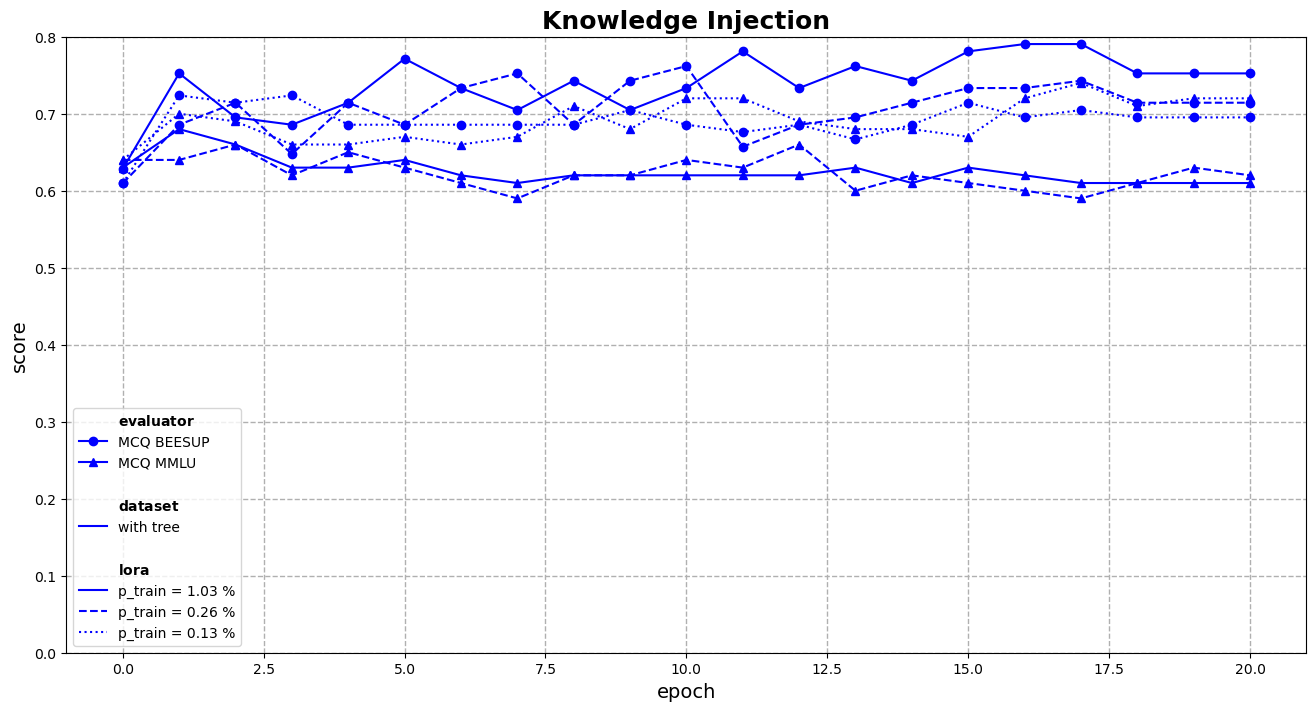

In [178]:
import matplotlib.pyplot as plt

TITLE_FONTSIZE=18
AX_FONTSIZE=14

plt.figure(figsize=(16, 8))

x_col='epoch'
y_col='score'

for i,plot_row in plot_df.iterrows():
    plt.plot(plot_row[x_col],plot_row[y_col],**plot_row['styledict'])

plt.legend(
    handles=get_handles(plot_df),
    #loc='lower right',
    #bbox_to_anchor=(1, 1.0,0.0,0.0),
    #ncol=1,
    #fontsize=AX_FONTSIZE
    )

plt.grid(axis='x', which='major', linestyle='--', linewidth='1.0') #for presentation linewidth='2.0' better
plt.grid(axis='y', which='major', linestyle='--', linewidth='1.0')
plt.grid(axis='y', which='minor', linestyle=':', linewidth='1.0')

plt.ylim(0,0.8)

plt.title('Knowledge Injection',fontweight='bold',fontsize=TITLE_FONTSIZE)
plt.xlabel(x_col,fontsize=AX_FONTSIZE)
plt.ylabel(y_col,fontsize=AX_FONTSIZE)

plt.show()

## Multiclass Cross Entropy Loss

In [152]:
experiment=InjectionExperiment(10)
experiment.get_config()

2025-02-17 09:20:56,596 - __init__.py - beesup_llm - __init__ - INFO - 0010_INJECTION_EXPERIMENT initialised
2025-02-17 09:20:56,599 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 09:20:56,602 - __init__.py - beesup_llm - __init__ - INFO - 0002_FINETUNING_PIPELINE initialised
2025-02-17 09:20:56,603 - __init__.py - beesup_llm - __init__ - INFO - 0001_LLM_PIPELINE initialised
2025-02-17 09:20:56,606 - __init__.py - beesup_llm - __init__ - INFO - 0007_DATASET initialised
2025-02-17 09:20:56,623 - __init__.py - beesup_llm - __init__ - INFO - 0003_LLM_EVALUATOR initialised
2025-02-17 09:20:56,626 - __init__.py - beesup_llm - __init__ - INFO - 0004_LLM_EVALUATOR initialised
2025-02-17 09:20:56,629 - __init__.py - beesup_llm - __init__ - INFO - 0005_LLM_EVALUATOR initialised
2025-02-17 09:20:56,632 - __init__.py - beesup_llm - __init__ - INFO - 0006_LLM_EVALUATOR initialised


{'type': 'injection_experiment',
 'id': 10,
 'name': '0010_injection_experiment',
 'dir_name': 'injection_experiments',
 'lab_name': 'injection_lab',
 'rel_path': 'injection_lab/injection_experiments/0010_injection_experiment',
 'done': True,
 'seed': 55,
 'do_eval_base_model': True,
 'do_finetuning': True,
 'llm_config': {'type': 'llm_pipeline',
  'id': 1,
  'name': '0001_llm_pipeline',
  'dir_name': 'llm_pipelines',
  'lab_name': 'injection_lab',
  'rel_path': 'injection_lab/llm_pipelines/0001_llm_pipeline',
  'name_or_path': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
  'pipeline_args': {'return_full_text': False,
   'clean_up_tokenization_spaces': True},
  'bnb_config': {'load_in_4bit': True,
   'bnb_4bit_use_double_quant': True,
   'bnb_4bit_quant_type': 'nf4'},
  'inference_tokenizer_config': {'padding_side': 'left',
   'padding': 'longest',
   'max_length': 8192,
   'pad_token': '<|begin_of_text|>',
   'pad_token_id': 128000},
  'training_tokenizer_config': {'padding_side': 'right'

In [174]:
mce_df=experiment.get_callbacks_df()
mce_df=mce_df[mce_df.evaluator_type=='mce'].dropna(how='all', axis=1).copy()
mce_df.drop(columns=['evaluator_type'], inplace=True)

#mce_df=mce_df.groupby(['global_step']).agg('mean').reset_index()

mce_df

,epoch,global_step,sample_id,loss
236,1,0,786.0,1.281549
237,1,0,897.0,3.453295
238,1,0,2230.0,0.507211
239,1,0,2926.0,0.470658
240,1,1,753.0,6.258847
...,...,...,...,...
72645,20,17058,1857.0,1.564545
72646,20,17059,1801.0,2.549563
72647,20,17059,3676.0,0.859696
72648,20,17059,1897.0,0.754042


In [175]:
mce_df[mce_df.sample_id==786]

,epoch,global_step,sample_id,loss
236,1,0,786.0,1.281549
4607,2,1041,786.0,1.353831
7569,3,1723,786.0,1.919172
13502,4,3155,786.0,1.974331
16964,5,3961,786.0,1.638890
20242,6,4729,786.0,1.460127
22579,7,5255,786.0,1.935778
26237,8,6118,786.0,1.773264
31083,9,7270,786.0,1.167127
34763,10,8139,786.0,2.197363


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.plot(log_df['epoch'],log_df['loss'])

In [169]:
log_df=experiment.get_log_history_df()

log_df['epoch']=(log_df['epoch']).astype(int)
log_df=log_df.groupby(['epoch']).agg('mean').reset_index()

log_df

,epoch,loss,grad_norm,learning_rate,step
0,0,1.037136,2.850080,0.000195,426.5
1,1,0.755736,2.613082,0.000185,1279.0
2,2,0.568008,2.822062,0.000175,2132.0
3,3,0.412227,3.026822,0.000165,2985.0
4,4,0.297783,3.037722,0.000155,3838.0
5,5,0.210241,2.891811,0.000145,4691.0
6,6,0.148257,2.563198,0.000135,5544.0
7,7,0.109535,2.476877,0.000125,6397.0
8,8,0.083094,2.290834,0.000115,7250.0
9,9,0.059222,2.040760,0.000105,8103.0


2025-02-17 09:36:07,715 - legend.py - matplotlib.legend - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


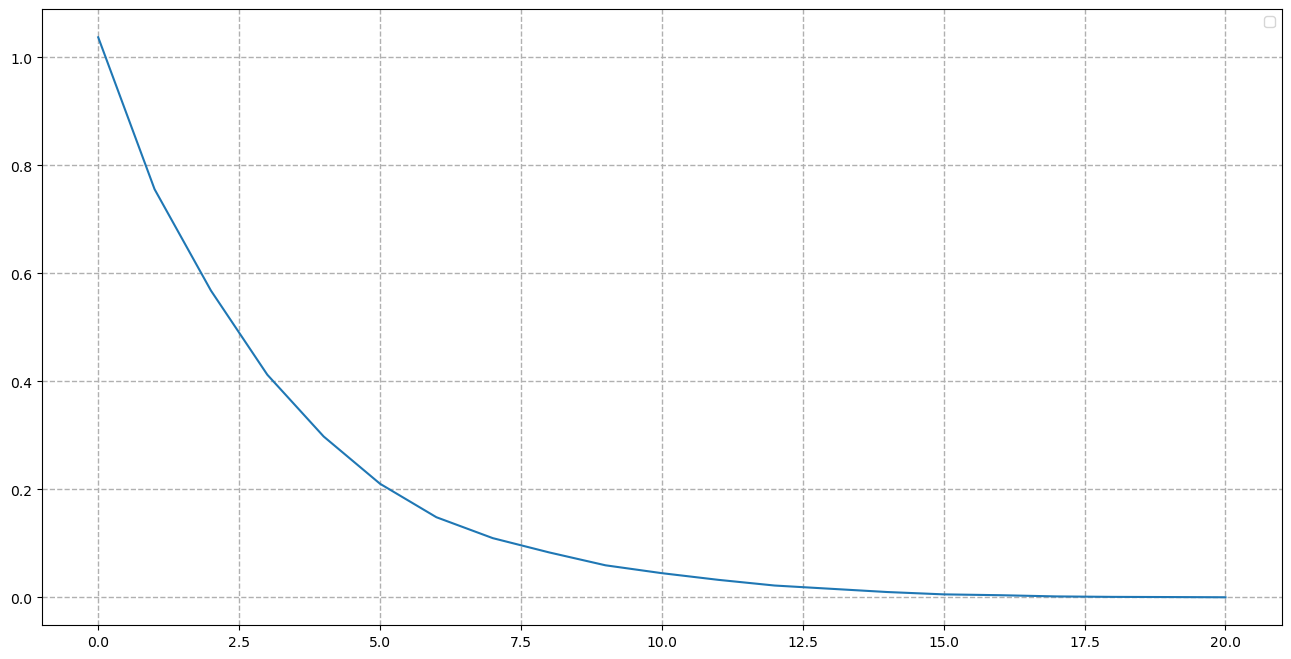

In [170]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.plot(log_df['epoch'],log_df['loss'])
#plt.plot(log_df['epoch'],log_df['learning_rate'])

plt.legend()

plt.grid(axis='x', which='major', linestyle='--', linewidth='1.0') #for presentation linewidth='2.0' better
plt.grid(axis='y', which='major', linestyle='--', linewidth='1.0')
plt.grid(axis='y', which='minor', linestyle=':', linewidth='1.0')

#plt.ylim(0,0.8)

#plt.title('Knowledge Injection',fontweight='bold',fontsize=TITLE_FONTSIZE)
#plt.xlabel(x_col,fontsize=AX_FONTSIZE)
#plt.ylabel(y_col,fontsize=AX_FONTSIZE)

plt.show()


In [ ]:
plot_df=log_df.copy()
#plot_df=plot_df.groupby('epoch').agg('mean').reset_index()
plot_df

,loss,grad_norm,learning_rate,epoch,step
0,1.7014,10.160701,1.999883e-04,0,1
1,1.6101,1.274801,1.999766e-04,0,2
2,1.8166,0.853062,1.999648e-04,0,3
3,1.7485,6.439350,1.999531e-04,0,4
4,1.3266,3.804995,1.999414e-04,0,5
...,...,...,...,...,...
17055,0.0003,0.014004,4.689332e-08,19,17056
17056,0.0002,0.009098,3.516999e-08,19,17057
17057,0.0006,0.023987,2.344666e-08,19,17058
17058,0.0001,0.002510,1.172333e-08,19,17059


In [ ]:
import matplotlib.pyplot as plt

TITLE_FONTSIZE=18
AX_FONTSIZE=14

plt.figure(figsize=(16, 8))


plt.plot(plot_df['epoch'],plot_row[y_col],**plot_row['styledict'])

plt.legend()

plt.grid(axis='x', which='major', linestyle='--', linewidth='1.0') #for presentation linewidth='2.0' better
plt.grid(axis='y', which='major', linestyle='--', linewidth='1.0')
plt.grid(axis='y', which='minor', linestyle=':', linewidth='1.0')

#plt.ylim(0,0.8)

plt.title('Knowledge Injection',fontweight='bold',fontsize=TITLE_FONTSIZE)
plt.xlabel(x_col,fontsize=AX_FONTSIZE)
plt.ylabel(y_col,fontsize=AX_FONTSIZE)

plt.show()



In [19]:
mce_df=callbacks_df[callbacks_df.evaluator_type=='mce'].copy()
mce_df.dropna(how='all', axis=1, inplace=True)
mce_df=mce_df.groupby('sample_id').agg(list).reset_index(drop=False)
mce_df['sample_id']=mce_df['sample_id'].astype(int)


knowledge_df=BaseDataset(6).df

add_cols=['s','p','o']
mce_df=mce_df.merge(knowledge_df[add_cols], left_on='sample_id', right_index=True, how='left')
mce_df

2025-02-14 13:56:02,742 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised


,sample_id,global_step,loss,epoch,evaluator_type,s,p,o
0,325,"[1, 3, 6]","[1.2153338193893433, 1.5197525024414062, 1.537...","[1, 2, 3]","[mce, mce, mce]","Andrena fulvida (Schenck, 1853)",Nistweise,endogäisch-selbstgegrabene Hohlräume
1,1561,"[1, 3, 7]","[0.8581979870796204, 1.1004188060760498, 0.674...","[1, 2, 3]","[mce, mce, mce]","Dasypoda hirtipes (Fabricius, 1793)",Umgangssprachliche Bezeichnungen,Dunkelfransige Hosenbiene
2,1750,"[0, 4, 6]","[0.6458176970481873, 0.4610402584075928, 0.730...","[1, 2, 3]","[mce, mce, mce]","Halictus submediterraneus (Pauly, 2015)",Pollensammelverhalten,polylektisch
3,2056,"[1, 3, 7]","[0.8615950345993042, 1.1242815256118774, 0.717...","[1, 2, 3]","[mce, mce, mce]","Hylaeus pictipes (Nylander, 1852)",Pollensammelverhalten,polylektisch (11 Familien)
4,2389,"[0, 4, 6]","[0.6871063709259033, 0.44807371497154236, 0.70...","[1, 2, 3]","[mce, mce, mce]","Lasioglossum parvulum (Schenck, 1853)",Familie,Halictidae
5,2693,"[2, 4, 7]","[7.627578258514404, 7.3950276374816895, 7.5127...","[1, 2, 3]","[mce, mce, mce]","Megachile nigriventris (Schenck, 1870)",Verbreitung,Die Art ist in den Gebirgen Mitteleuropas (bis...
6,2942,"[0, 3, 8]","[0.5408042073249817, 0.5992832779884338, 0.562...","[1, 2, 3]","[mce, mce, mce]","Nomada femoralis (Morawitz, 1869)",Familie,Apidae
7,2995,"[1, 4, 7]","[6.327451705932617, 4.996522426605225, 5.05516...","[1, 2, 3]","[mce, mce, mce]","Nomada fulvicornis (Fabricius, 1793)",Vorkommen und Lebensweise,"Die Art ist in Süd-, Mittel- und dem südlichen..."
8,3135,"[2, 5, 8]","[1.02451753616333, 1.5360527038574219, 1.63111...","[1, 2, 3]","[mce, mce, mce]","Nomada obscura (Zetterstedt, 1838)",Kurzbeschreibung,Nomada obscura ist eine Biene aus der Familie ...
9,3289,"[0, 5, 6]","[0.9544119238853455, 0.9566159844398499, 0.972...","[1, 2, 3]","[mce, mce, mce]","Nomada villosa (Thomson, 1870)",Umgangssprachliche Bezeichnungen,Zottige Wespenbiene


In [ ]:
mce_sample=

In [34]:
fns=os.listdir(experiment._path)
fns=[fn for fn in fns if 'qdq' in fn]

qdq_df=pd.DataFrame()
for fn in fns:
    df=pd.read_pickle(f"{experiment._path}/{fn}")
    qdq_df=pd.concat([qdq_df,df],ignore_index=True)

qdq_df

,question,target_attr,gold_items,prompt_messages,pred_completion,eval_dict
0,Welche Wildbienen der Familie Megachilidae sam...,Wissenschaftlicher Name,"[Megachile nigriventris (Schenck, 1870), Megac...","[{'role': 'user', 'content': 'You are provided...","Die Wildbienen der Familie Megachilidae, die P...",{'info': 'NotImplemented'}
1,Welche Wildbienen werden umgangssprachlich als...,Wissenschaftlicher Name,"[Andrena pauxilla (E.Stöckhert, 1935), Andrena...","[{'role': 'user', 'content': 'You are provided...",Welche Wildbienen werden umgangssprachlich als...,{'info': 'NotImplemented'}
2,Welche Wildbienen der Familie Halictidae bauen...,Wissenschaftlicher Name,"[Rophites algirus (Pérez, 1895), Rophites quin...","[{'role': 'user', 'content': 'You are provided...","Lasioglossum calcaris (Schulz, 1903); Lasioglo...",{'info': 'NotImplemented'}
3,Welche Wildbienen bauen ihre Nester oberirdisc...,Wissenschaftlicher Name,"[Anthidiellum strigatum (Panzer, 1804), Megach...","[{'role': 'user', 'content': 'You are provided...",Welche Wildbienen bauen ihre Nester oberirdisc...,{'info': 'NotImplemented'}
4,Welche Wildbienen der Familie Halictidae werde...,Wissenschaftlicher Name,"[Halictus langobardicus (Blüthgen, 1944), Hali...","[{'role': 'user', 'content': 'You are provided...",Die Furchenbienen der Familie Halictidae sind:...,{'info': 'NotImplemented'}
...,...,...,...,...,...,...
541,Welche Wildbienen leben solitär und bauen Nest...,Wissenschaftlicher Name,"[Lasioglossum nitidulum (Fabricius, 1804), Las...","[{'role': 'user', 'content': 'You are provided...","Osmia adunca (Panzer, 1798); Osmia leaiana (Ki...",{'info': 'NotImplemented'}
542,Welche Wildbienen haben keine Kuckucksbienen d...,Wissenschaftlicher Name,"[Lasioglossum lativentre (Schenck, 1853), Lasi...","[{'role': 'user', 'content': 'You are provided...","Lasioglossum leucopus (Kirby, 1802); Lasioglos...",{'info': 'NotImplemented'}
543,Welche Wildbienen haben keine Kuckucksbienen d...,Wissenschaftlicher Name,"[Lasioglossum lativentre (Schenck, 1853), Lasi...","[{'role': 'user', 'content': 'You are provided...","Lasioglossum leucopus (Kirby, 1802); Lasioglos...",{'info': 'NotImplemented'}
544,Welche Wildbienen leben sozial und sind Wirtsb...,Wissenschaftlicher Name,"[Lasioglossum morio (Fabricius, 1793), Lasiogl...","[{'role': 'user', 'content': 'You are provided...","Lasioglossum leucopus (Kirby, 1802); Lasioglos...",{'info': 'NotImplemented'}


In [45]:
chars_per_item=len(', '.join(sample.gold_items))/len(sample.gold_items)
chars_per_item

38.8

In [46]:
num_pred_items=len(sample.pred_completion)/chars_per_item
num_pred_items

6.288659793814434

In [ ]:
sample=qdq_df.sample(1).iloc[0]

print(sample.gold_items)
print(sample.pred_completion)

['Lasioglossum morio (Fabricius, 1793)', 'Lasioglossum calceatum (Scopoli, 1763)', 'Lasioglossum malachurum (Kirby, 1802)', 'Lasioglossum laticeps (Schenck, 1870)', 'Lasioglossum pauxillum (Schenck, 1853)']
Lasioglossum leucopus (Kirby, 1802); Lasioglossum minutissimum (Kirby, 1802); Lasioglossum morio (Fabricius, 1793); Lasioglossum punctatissimum (Schenck, 1853); Lasioglossum quadrinotatulum (Schenck, 1861); Lasioglossum villosulum (Kirby, 1802)


In [ ]:
def get_eval_dict(sample):

    tp, fp

    for gold_item in sample.gold_items:
        fuzzy_score=fuzz.partial_ratio(gold_item, sample.pred_completion)/100

        if fuzzy_score>=0.9:


        if gold_item in sample.pred_completion:
            return dict(tp=1)


In [42]:
for gold_item in sample.gold_items:

    print(f"{gold_item}\t {fuzz.partial_ratio(gold_item, sample.pred_completion)}")


Lasioglossum morio (Fabricius, 1793)	 100.0
Lasioglossum calceatum (Scopoli, 1763)	 66.66666666666667
Lasioglossum malachurum (Kirby, 1802)	 83.78378378378379
Lasioglossum laticeps (Schenck, 1870)	 72.97297297297297
Lasioglossum pauxillum (Schenck, 1853)	 76.31578947368422


In [12]:
experiment.get_log_history_df()

,loss,grad_norm,learning_rate,epoch,step
0,1.2147,19.249237,0.000178,0.333333,1
1,2.1734,4.110070,0.000156,0.666667,2
2,1.6658,2.172511,0.000133,1.000000,3
3,1.4254,4.632368,0.000111,1.333333,4
4,1.2734,1.372704,0.000089,1.666667,5
5,0.4541,4.610790,0.000067,2.000000,6
6,0.3370,2.522612,0.000044,2.333333,7
7,1.0441,1.608352,0.000022,2.666667,8
8,0.0725,1.861139,0.000000,3.000000,9


In [11]:
callbacks_df[callbacks_df.evaluator_type=='mce']

,global_step,sample_id,loss,epoch,evaluator_type,evaluator_id,sidx,kidx,tidx,add_kidc,add_tidc,emb_col,question,choices,answer,prompt_messages,pred_completion,eval_dict,mmluidx,subject
0,0,3289.0,0.954412,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2389.0,0.687106,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2942.0,0.540804,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1750.0,0.645818,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,325.0,1.215334,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,1561.0,0.858198,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2056.0,0.861595,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,2995.0,6.327452,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,2693.0,7.627578,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,3135.0,1.024518,1,mce,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
callbacks_df.iloc[0].pred_completion

'PredictionError: add_special_tokens conflicts with the method add_special_tokens in PreTrainedTokenizerFast'

In [22]:
fn=fns[3]
print(fn)
epoch,global_step,eval_type,eval_id=re.match(r'(\d+)-(\d+)_([a-z]+)(?:-(\d+))?.*',fn).groups()

print(epoch,global_step,eval_type,eval_id)

1-3_mcq-4_callback_df.pkl
1 3 mcq 4


,sidx,kidx,tidx,add_kidc,add_tidc,emb_col,question,choices,answer,prompt_messages,...,eval_dict,global_step,subtype,evaluator_id,mmluidx,subject,target_attr,gold_items,dataset_id,experiment_id
0,10.0,1420.0,1258.0,NaN,"[1302, 1301, 1300]",s,Welche Bienenarten sind bekannte Wirtsbienen v...,"[Megachile apicalis Spinola, 1808; Megachile l...",0.0,"[{'role': 'user', 'content': 'You are provided...",...,"{'pred_choice': 'c', 'gold_choice': 'a', 'tp': 0}",0,mcq,3,NaN,NaN,NaN,NaN,7,6
1,11.0,991.0,867.0,NaN,[],so,Woran kann man die Königin der Westlichen Honi...,[An ihrer Größe und dem verlängerten Hinterlei...,0.0,"[{'role': 'user', 'content': 'You are provided...",...,"{'pred_choice': 'a', 'gold_choice': 'a', 'tp': 1}",0,mcq,3,NaN,NaN,NaN,NaN,7,6
2,12.0,646.0,560.0,NaN,"[461, 310, 2160]",po,Welche Kuckucksbiene ist bei Andrena rhenana (...,"[Nomada femoralis Morawitz, 1869, Nomada rufic...",2.0,"[{'role': 'user', 'content': 'You are provided...",...,"{'pred_choice': 'd', 'gold_choice': 'c', 'tp': 0}",0,mcq,3,NaN,NaN,NaN,NaN,7,6
3,13.0,1172.0,1034.0,NaN,[],p,In welchem Lebensraum ist die Grauweiße Hummel...,[In den Küstenregionen Südosteuropas unterhalb...,2.0,"[{'role': 'user', 'content': 'You are provided...",...,"{'pred_choice': 'a', 'gold_choice': 'c', 'tp': 0}",0,mcq,3,NaN,NaN,NaN,NaN,7,6
4,14.0,3366.0,2956.0,NaN,[],spo,Welches Merkmal unterscheidet das Weibchen der...,"[Das Weibchen ist zwischen 12 und 14 mm lang.,...",1.0,"[{'role': 'user', 'content': 'You are provided...",...,"{'pred_choice': 'd', 'gold_choice': 'b', 'tp': 0}",0,mcq,3,NaN,NaN,NaN,NaN,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0.0,3028.0,2657.0,[2968],NaN,spo,Woran kann man die Männchen und Weibchen von N...,NaN,Die Männchen von Nomada guttulata sehen den We...,"[{'role': 'user', 'content': 'Woran kann man d...",...,{'info': 'NotImplemented'},17060,ffq,6,NaN,NaN,NaN,NaN,8,7
9908,1.0,2022.0,1783.0,"[2024, 2021]",NaN,s,Wie unterscheiden sich die Männchen und Weibch...,NaN,Die Weibchen von Hylaeus nigritus haben eine d...,"[{'role': 'user', 'content': 'Wie unterscheide...",...,{'info': 'NotImplemented'},17060,ffq,6,NaN,NaN,NaN,NaN,8,7
9909,2.0,222.0,194.0,[],NaN,so,Warum werden die Arten der Untergattung Cnemid...,NaN,Die Arten der Untergattung Cnemidandrena werde...,"[{'role': 'user', 'content': 'Warum werden die...",...,{'info': 'NotImplemented'},17060,ffq,6,NaN,NaN,NaN,NaN,8,7
9910,3.0,2943.0,2582.0,"[1924, 814]",NaN,p,Zu welcher Familie gehört die Bienenart Nomada...,NaN,Nomada femoralis gehört zur Familie der Apidae.,"[{'role': 'user', 'content': 'Zu welcher Famil...",...,{'info': 'NotImplemented'},17060,ffq,6,NaN,NaN,NaN,NaN,8,7


In [ ]:
# compressed_cols = ['age', 'city']  # Columns to be compressed

# df['compressed'] = df[compressed_cols].apply(lambda row: row.to_dict(), axis=1)

# # Drop the original compressed columns if needed
# df = df.drop(columns=compressed_cols)

# print(df)

In [168]:
evals_df.columns

Index(['sidx', 'kidx', 'tidx', 'add_kidc', 'add_tidc', 'emb_col', 'question',
       'choices', 'answer', 'prompt_messages', 'pred_completion', 'eval_dict',
       'global_step', 'subtype', 'evaluator_id', 'mmluidx', 'subject',
       'target_attr', 'gold_items', 'dataset_id', 'experiment_id', 'epoch'],
      dtype='object')

In [169]:
use_cols=[
    'experiment_id','evaluator_id','subtype',
    'global_step',
    'kidx','add_kidc','question','answer','pred_completion',
    'eval_dict'
]

evals_df[use_cols]

,experiment_id,evaluator_id,subtype,global_step,kidx,add_kidc,question,answer,pred_completion,eval_dict
0,6,3,mcq,0,1420.0,NaN,Welche Bienenarten sind bekannte Wirtsbienen v...,0.0,C,"{'pred_choice': 'c', 'gold_choice': 'a', 'tp': 0}"
1,6,3,mcq,0,991.0,NaN,Woran kann man die Königin der Westlichen Honi...,0.0,A,"{'pred_choice': 'a', 'gold_choice': 'a', 'tp': 1}"
2,6,3,mcq,0,646.0,NaN,Welche Kuckucksbiene ist bei Andrena rhenana (...,2.0,D,"{'pred_choice': 'd', 'gold_choice': 'c', 'tp': 0}"
3,6,3,mcq,0,1172.0,NaN,In welchem Lebensraum ist die Grauweiße Hummel...,2.0,A,"{'pred_choice': 'a', 'gold_choice': 'c', 'tp': 0}"
4,6,3,mcq,0,3366.0,NaN,Welches Merkmal unterscheidet das Weibchen der...,1.0,D,"{'pred_choice': 'd', 'gold_choice': 'b', 'tp': 0}"
...,...,...,...,...,...,...,...,...,...,...
9907,7,6,ffq,17060,3028.0,[2968],Woran kann man die Männchen und Weibchen von N...,Die Männchen von Nomada guttulata sehen den We...,"Die Männchen sind 10 bis 12 mm lang, die Weibc...",{'info': 'NotImplemented'}
9908,7,6,ffq,17060,2022.0,"[2024, 2021]",Wie unterscheiden sich die Männchen und Weibch...,Die Weibchen von Hylaeus nigritus haben eine d...,"Die Männchen sind ca. 7 bis 9 mm groß, die Wei...",{'info': 'NotImplemented'}
9909,7,6,ffq,17060,222.0,[],Warum werden die Arten der Untergattung Cnemid...,Die Arten der Untergattung Cnemidandrena werde...,Die Arten der Untergattung Cnemidandrena flieg...,{'info': 'NotImplemented'}
9910,7,6,ffq,17060,2943.0,"[1924, 814]",Zu welcher Familie gehört die Bienenart Nomada...,Nomada femoralis gehört zur Familie der Apidae.,Die Bienenart Nomada femoralis gehört zur Fami...,{'info': 'NotImplemented'}


In [61]:
reimport()

,experiment_id,evaluator_id,epoch,score
0,6,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6285714285714286, 0.7523809523809524, 0.695..."
1,6,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.63, 0.68, 0.66, 0.63, 0.63, 0.64, 0.62, 0.6..."
2,6,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.016297043010752684, 0.0, 0.0, 0.03230494995..."
3,7,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6285714285714286, 0.7142857142857143, 0.752..."
4,7,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.63, 0.63, 0.66, 0.63, 0.67, 0.64, 0.62, 0.6..."
5,7,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.016297043010752684, 0.0, 0.0, 0.03598901098..."


,experiment_id,evaluator_id,epoch,score,evaluator_styledict,experiment_styledict,styledict
0,6,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6285714285714286, 0.7523809523809524, 0.695...","{'label': 'MCQ BEESUP', 'marker': 'o'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'color': (0.0, 0.0, 1.0), 'marker': 'o'}"
1,6,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.63, 0.68, 0.66, 0.63, 0.63, 0.64, 0.62, 0.6...","{'label': 'MCQ MMLU', 'marker': '^'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'color': (0.0, 0.0, 1.0), 'marker': '^'}"
2,6,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.016297043010752684, 0.0, 0.0, 0.03230494995...","{'label': 'QDQ BEESUP', 'marker': '*'}","{'label': 'with tree', 'color': (0.0, 0.0, 1.0)}","{'color': (0.0, 0.0, 1.0), 'marker': '*'}"
3,7,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6285714285714286, 0.7142857142857143, 0.752...","{'label': 'MCQ BEESUP', 'marker': 'o'}","{'label': 'without tree', 'color': (0.0, 0.501...","{'color': (0.0, 0.5019607843137255, 0.0), 'mar..."
4,7,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.63, 0.63, 0.66, 0.63, 0.67, 0.64, 0.62, 0.6...","{'label': 'MCQ MMLU', 'marker': '^'}","{'label': 'without tree', 'color': (0.0, 0.501...","{'color': (0.0, 0.5019607843137255, 0.0), 'mar..."
5,7,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.016297043010752684, 0.0, 0.0, 0.03598901098...","{'label': 'QDQ BEESUP', 'marker': '*'}","{'label': 'without tree', 'color': (0.0, 0.501...","{'color': (0.0, 0.5019607843137255, 0.0), 'mar..."


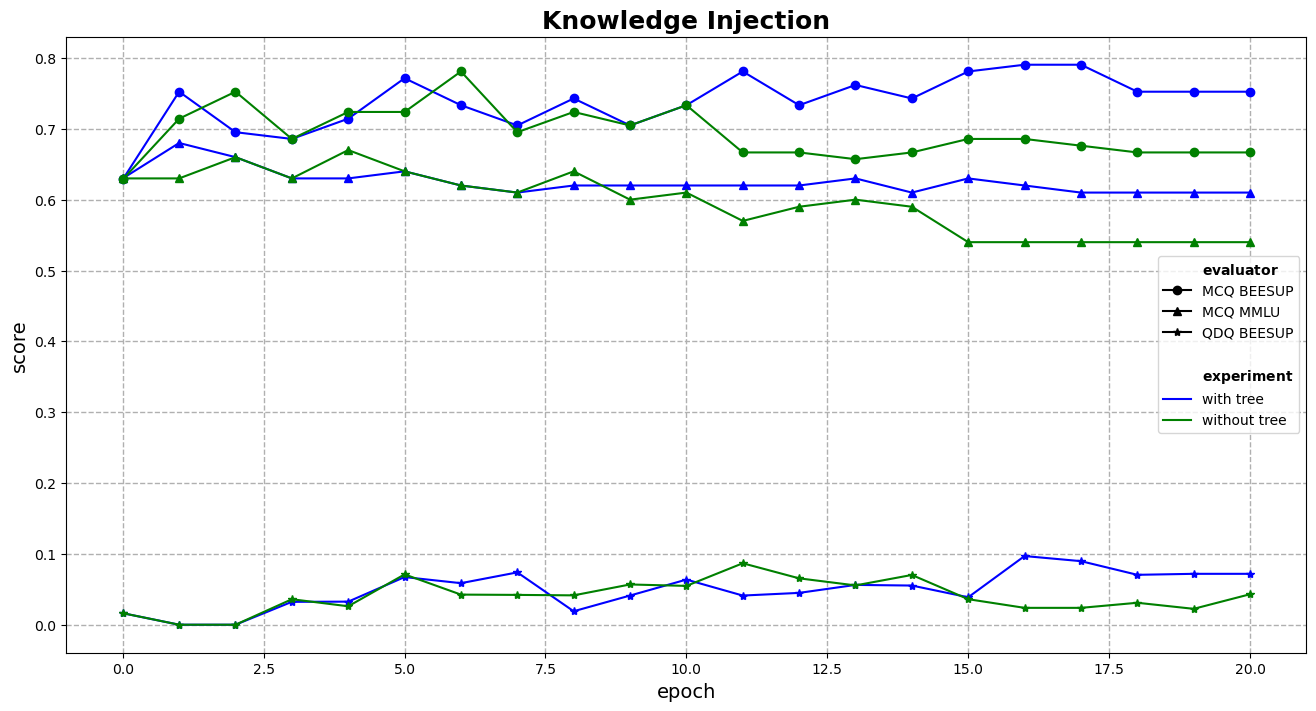

In [64]:
import matplotlib.pyplot as plt

TITLE_FONTSIZE=18
AX_FONTSIZE=14

plt.figure(figsize=(16, 8))

x_col='epoch'
y_col='score'

for i,plot_row in plot_df.iterrows():
    plt.plot(plot_row[x_col],plot_row[y_col],**plot_row['styledict'])

plt.legend(
    handles=get_handles(plot_df),
    #loc='lower right',
    #bbox_to_anchor=(1, 1.0,0.0,0.0),
    #ncol=1,
    #fontsize=AX_FONTSIZE
    )

plt.grid(axis='x', which='major', linestyle='--', linewidth='1.0') #for presentation linewidth='2.0' better
plt.grid(axis='y', which='major', linestyle='--', linewidth='1.0')
plt.grid(axis='y', which='minor', linestyle=':', linewidth='1.0')

#plt.ylim(0,0.8)

plt.title('Knowledge Injection',fontweight='bold',fontsize=TITLE_FONTSIZE)
plt.xlabel(x_col,fontsize=AX_FONTSIZE)
plt.ylabel(y_col,fontsize=AX_FONTSIZE)

plt.show()

In [34]:
knowledge_df=BaseDataset(6).df
knowledge_df

2025-02-12 06:22:48,703 - __init__.py - beesup_llm - __init__ - INFO - 0006_DATASET initialised


,s,p,o,source_name,attr_type,n_units,n_words,s_emb,p_emb,o_emb,spo,spo_emb,po,po_emb,so,so_emb
0,"Aglaoapis tridentata (Nylander, 1848)",Aussehen,"Die Biene ist schwarz, etwa 8–10 mm lang und m...",wikipedia,Text,1,33,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[-0.00241154, 0.018927356, 0.029465966, 0.0016...","[0.01207492, -0.00862774, 0.0006142589, -0.024...","Aglaoapis tridentata (Nylander, 1848)\nAussehe...","[0.017138824, -0.007862857, 0.0062451847, -0.0...","Aussehen\nDie Biene ist schwarz, etwa 8–10 mm ...","[0.013315118, -0.0025690868, -0.002520601, -0....","Aglaoapis tridentata (Nylander, 1848)\nDie Bie...","[0.015632853, -0.013067747, 0.005556736, -0.02..."
1,"Aglaoapis tridentata (Nylander, 1848)",Familie,Megachilidae,wildbienen-kataster,Attribute,1,1,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[-0.017521149, -0.0039982847, 0.023655187, 0.0...","[-0.009079237, -0.009580155, 0.016292965, 0.01...","Aglaoapis tridentata (Nylander, 1848)\nFamilie...","[0.005252384, -0.036279034, 0.006696027, -0.00...",Familie\nMegachilidae,"[-0.008217988, -0.017626682, 0.014735313, 0.00...","Aglaoapis tridentata (Nylander, 1848)\nMegachi...","[0.006705275, -0.036509484, 0.010870452, -0.00..."
2,"Aglaoapis tridentata (Nylander, 1848)",Kurzbeschreibung,"Dunkle Zweizahnbiene (Aglaoapis tridentata, Sy...",wikipedia,Text,1,23,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[0.005835669, 0.00046010816, 0.013336124, 0.00...","[0.0041770185, -0.026317475, 0.034765385, -0.0...","Aglaoapis tridentata (Nylander, 1848)\nKurzbes...","[0.0035359014, -0.01788473, 0.027300809, -0.01...",Kurzbeschreibung\nDunkle Zweizahnbiene (Aglaoa...,"[0.005021267, -0.020270793, 0.030479617, -0.01...","Aglaoapis tridentata (Nylander, 1848)\nDunkle ...","[0.0042278427, -0.021583805, 0.029263686, -0.0..."
3,"Aglaoapis tridentata (Nylander, 1848)",Lebensraum,"Die Biene lebt auf trockenen, blütenreichen Bö...",wikipedia,Text,1,38,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[-0.00676674, 0.005776319, 0.015435509, 0.0075...","[0.007754282, 0.005550979, 0.02731938, -0.0074...","Aglaoapis tridentata (Nylander, 1848)\nLebensr...","[0.013944852, -0.0064185373, 0.027355487, -0.0...","Lebensraum\nDie Biene lebt auf trockenen, blüt...","[0.010719752, 0.007365582, 0.02396487, -0.0069...","Aglaoapis tridentata (Nylander, 1848)\nDie Bie...","[0.012453266, -0.006588385, 0.027248787, -0.01..."
4,"Aglaoapis tridentata (Nylander, 1848)",Sozialverhalten,parasitisch,wildbienen-kataster,Attribute,1,1,"[0.009497706, -0.02880746, 0.008733329, 0.0057...","[0.0036254618, 0.009151482, 0.033454232, 0.006...","[0.003635382, 0.00020615666, 0.011989376, 0.01...","Aglaoapis tridentata (Nylander, 1848)\nSozialv...","[0.0068017743, -0.011348086, 0.027071316, 0.00...",Sozialverhalten\nparasitisch,"[0.0032968454, 0.00887096, 0.024923151, 0.0094...","Aglaoapis tridentata (Nylander, 1848)\nparasit...","[0.015163679, -0.020221671, 0.0124891335, 0.01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,"Xylocopa violacea (Linnaeus, 1758)",Pollensammelverhalten,polylektisch,wildbienen-kataster,Attribute,1,1,"[0.009752467, -0.021650426, -0.007450565, 0.01...","[0.0066927713, -0.009372412, 0.023364846, 0.00...","[-0.002670167, -0.006360698, 0.018829769, 0.00...","Xylocopa violacea (Linnaeus, 1758)\nPollensamm...","[0.010988698, -0.022081949, 0.0021539137, 0.00...",Pollensammelverhalten\npolylektisch,"[0.0017042567, -0.013260176, 0.028913721, 0.00...","Xylocopa violacea (Linnaeus, 1758)\npolylektisch","[0.013854192, -0.029805599, -0.0058516874, 0.0..."
3885,"Xylocopa violacea (Linnaeus, 1758)",Requisiten,Totholz,wildbienen-kataster,Attribute,1,1,"[0.009752467, -0.021650426, -0.007450565, 0.01...","[0.009611603, 0.002773139, 0.029174019, -0.006...","[-0.0038502081, -0.014879571, 0.025984177, 0.0...","Xylocopa violacea (Linnaeus, 1758)\nRequisiten...","[0.015425433, -0.014480818, 0.008214226, -0.00...",Requisiten\nTotholz,"[0.008261229, -0.0013367896, 0.031

In [37]:
ffq_evals_df=evals_df[evals_df.subtype=='ffq'].copy()
ffq_evals_df['add_kidc']=ffq_evals_df['add_kidc'].apply(tuple)
ffq_evals_df

group_cols=['experiment_id','question','answer','kidx','add_kidc']
list_cols=['epoch','pred_completion']

ffq_evals_df=ffq_evals_df[group_cols+list_cols].groupby(group_cols).agg(list).reset_index()
ffq_evals_df

,experiment_id,question,answer,kidx,add_kidc,epoch,pred_completion
0,6,Warum werden die Arten der Untergattung Cnemid...,Die Arten der Untergattung Cnemidandrena werde...,222.0,(),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Die Arten der Untergattung Cnemidandrena werd...
1,6,Welche Wirtsarten parasitiert Nomada trapezifo...,Nomada trapeziformis parasitiert vermutlich An...,3284.0,"(3298, 3194, 2987)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Ich konnte keine genauen Informationen über d...
2,6,Wie unterscheiden sich die Männchen und Weibch...,Die Weibchen von Hylaeus nigritus haben eine d...,2022.0,"(2024, 2021)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Die Maskenbiene Hylaeus nigritus ist eine Art...
3,6,Woran kann man die Männchen und Weibchen von N...,Die Männchen von Nomada guttulata sehen den We...,3028.0,"(2968,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Die Unterscheidung zwischen den Männchen und ...
4,6,Zu welcher Familie gehört die Bienenart Nomada...,Nomada femoralis gehört zur Familie der Apidae.,2943.0,"(1924, 814)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Die Bienenart Nomada femoralis gehört zur Fam...
5,7,Warum werden die Arten der Untergattung Cnemid...,Die Arten der Untergattung Cnemidandrena werde...,222.0,(),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Die Arten der Untergattung Cnemidandrena werd...
6,7,Welche Wirtsarten parasitiert Nomada trapezifo...,Nomada trapeziformis parasitiert vermutlich An...,3284.0,"(3298, 3194, 2987)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Ich konnte keine genauen Informationen über d...
7,7,Wie unterscheiden sich die Männchen und Weibch...,Die Weibchen von Hylaeus nigritus haben eine d...,2022.0,"(2024, 2021)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Die Maskenbiene Hylaeus nigritus ist eine Art...
8,7,Woran kann man die Männchen und Weibchen von N...,Die Männchen von Nomada guttulata sehen den We...,3028.0,"(2968,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Die Unterscheidung zwischen den Männchen und ...
9,7,Zu welcher Familie gehört die Bienenart Nomada...,Nomada femoralis gehört zur Familie der Apidae.,2943.0,"(1924, 814)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Die Bienenart Nomada femoralis gehört zur Fam...


In [46]:
print(knowledge_df.loc[kidc,['s','p','o']].iloc[0].o)

A. denticulata gehört zur Untergattung Cnemidandrena, zu der in Mitteleuropa auch A. freygessneri, A. fuscipes,  A. nigriceps und A. simillima gehören (nicht jedoch die sehr ähnliche A. flavipes). Die Arten der Untergattung Cnemidandrena fliegen alle relativ spät im Jahr, weshalb sie auch Herbstsandbienen genannt werden. 
Im Fernen Osten (Japan, Korea, China und Russland) wurde eine sehr ähnliche Art (A. seneciorum) beschrieben, die teilweise als Unterart (A. denticulata seneciorum) gesehen wird.


In [47]:
sample=ffq_evals_df.iloc[1]

print(f"CHUNKs: ")
kidc=[sample.kidx]+list(sample.add_kidc)
display(knowledge_df.loc[kidc,['s','p','o']])

print(f"QUESTION: {sample.question}\n")
print(f"ANSWER: {sample.answer}\n")
print(25*'#', end='\n\n')

for epoch, pred_completion in zip(sample.epoch, sample.pred_completion):
    print(f"EPOCH {epoch}: {pred_completion.strip()}\n\n")

CHUNKs: 


,s,p,o
3284,"Nomada trapeziformis (Schmiedeknecht, 1882)",Vorkommen und Lebensweise,"Die Art ist in Süddeutschland, Österreich und ..."
3298,"Nomada zonata (Panzer, 1798)",Vorkommen und Lebensweise,Die Art ist in Süd- und Mitteleuropa verbreite...
3194,"Nomada rhenana (Morawitz, 1872)",Vorkommen und Lebensweise,Die Art ist in Süd- und Mitteleuropa verbreite...
2987,"Nomada fucata (Panzer, 1798)",Vorkommen und Lebensweise,"Die Art ist in ganz Europa, östlich bis nach Z..."


QUESTION: Welche Wirtsarten parasitiert Nomada trapeziformis vermutlich?

ANSWER: Nomada trapeziformis parasitiert vermutlich Andrena barbareae und Andrena limata.

#########################

EPOCH 0: Ich konnte keine genauen Informationen über die Wirtsarten von Nomada trapeziformis finden. Es ist jedoch bekannt, dass Nomada trapeziformis eine Art der Gattung Nomada ist, die als Parasitoide bekannt ist. Diese Bienen parasitieren die Nester anderer Bienenarten und legen ihre Eier in die Nester der Wirtsbiene. Die Wirtsbiene wird dann getötet, bevor ihre Jungen schlüpfen.


EPOCH 1: Die Art parasitiert vermutlich die Arten der Gattung Andrena.


EPOCH 2: Die Art parasitiert vermutlich Andrena nitidiuscula und vielleicht auch Andrena nitidinata.


EPOCH 3: Andrena nitida


EPOCH 4: Die Wespenbienen Nomada fabriciana und Nomada goodeniana parasitieren Nomada trapeziformis.


EPOCH 5: Die Art parasitiert Andrena barbilabris und Andrena ventralis.


EPOCH 6: Andrena humilis


EPOCH 7: Andre